<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>

<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces </b><br>  
    </font>
     <font size="3">
        Implementation notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Implementation__

## __Install components__

In [ ]:
!pip install editdistance
!pip install pandas_read_xml
!pip install requests

## __Import libraries__

In [2]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Model__









In [76]:
class RankedWTAHash:

    def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', prototypesFilterThr=None, ngramms=3, similarityThreshold=None, maxOnly=None,earlyStop=0):
        '''
          Constructor
        '''
        self.max_numberOf_clusters = max_numberOf_clusters
        self.pairDictionary = dict()
        self.max_editDistance = max_editDistance
        self.windowSize = windowSize
        self.S_set = None
        self.S_index = None
        self.similarityThreshold = similarityThreshold
        self.maxOnly = maxOnly
        self.metric = metric
        self.min_numOfNodes = min_numOfNodes
        self.similarityVectors = similarityVectors
        self.number_of_permutations = number_of_permutations
        self.distanceMetric = distanceMetric
        self.distanceMetricEmbedding = distanceMetricEmbedding
        self.ngramms = ngramms
        self.jaccard_withchars =  jaccard_withchars
        self.prototypesFilterThr = prototypesFilterThr
        self.earlyStop = earlyStop
        self.selectionVariance = None

    def fit(self, X):
        """
          Fit the classifier from the training dataset.
          Parameters
          ----------
          X : Training data.
          Returns
          -------
          self : The fitted classifier.
        """
        print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

        if isinstance(X, list):
            input_strings = X
        else:
            input_strings = list(X)

        # print(input_strings)
        self.initialS_set = np.array(input_strings,dtype=object)
        self.S_set = np.array(input_strings,dtype=object)
        if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(self.S_set[i]), n=self.ngramms))
        elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(self.S_set[i], n=self.ngramms))
        # print(self.S_set)

        self.S_index = np.arange(0,len(input_strings),1)

        # print("\n\nString positions are:")
        # print(self.S_index)
        # print("\n")

        print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
        print("\n-> Finding prototypes and representatives of each cluster:")
        prototypes_time = time.time()
        self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
        print("\n- Prototypes selected")
        self.embeddingDim = self.prototypeArray.size
        print(self.prototypeArray)
        heatmapData = []
        for pr in self.prototypeArray:
            print(pr," -> ",self.initialS_set[pr])
            heatmapData.append(self.S_set[pr])
            
        if self.selected_numOfPrototypes > 2:
            self.selectionVariance = myHeatmap(self.prototypeArray,self.metric,self.EditDistance)
            print("\n- Mean variance in prototype selection: ",self.selectionVariance )
        print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
        prototypes_time = time.time() - prototypes_time
        print("\n# Finished in %.6s secs" % (prototypes_time))
        print("\n")

        if self.earlyStop==1:
            return self

        print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
        print("\n-> Creating Embeddings:")
        embeddings_time = time.time()
        self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
        print("- Embeddings created")
        print(self.Embeddings)
        embeddings_time = time.time() - embeddings_time
        print("\n# Finished in %.6s secs" % (embeddings_time))
        print("\n")

        if self.earlyStop==2:
            return self

        print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
        print("\n-> Creating WTA Buckets:")
        wta_time = time.time()
        self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
        print("- WTA buckets: ")
        for key in self.buckets.keys():
            print(key," -> ",self.buckets[key])
        print("\n- WTA number of buckets: ", len(self.buckets.keys()))
        print("\n- WTA RankedVectors after permutation:")
        print(self.rankedVectors)
        wta_time = time.time() - wta_time
        print("\n# Finished in %.6s secs" % (wta_time))
        print("\n")
        if self.earlyStop==3:
            return self

        print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
        print("\n-> Similarity checking:")
        if len(self.buckets.keys()) < 5:
            self.earlyStop=5
            return self

        similarity_time = time.time()

        if self.similarityVectors == 'ranked':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        elif self.similarityVectors == 'initial':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        else:
            warnings.warn("similarityVectors: Available options are: ranked,initial")
        #     print("- Similarity matrix (all values compared):")
        #     print(self.similarityProb_matrix)
        print("- Similarity mapping in a matrix")
        print(self.mapping_matrix)
        similarity_time = time.time() - similarity_time
        print("\n# Finished in %.6s secs" % (similarity_time))
        print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

        return self

    def EditDistance(self, str1,str2,verbose=False):
        if verbose:
            if str1 == None:
                print("1")
            elif str2 == None:
                print("2")
            print("-> "+str(str1))
            print("--> "+str(str2))
            print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))


        # NOTE: Duplicates inside the dictionary

        if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
            return self.pairDictionary[(str1,str2)]
        else:
            # if verbose:
            # print("++++++++++")
            # print(str1,str2)
            # print(self.S_set[str1],self.S_set[str2])
            # print("++++++++++")
            if self.distanceMetric == 'edit':
                distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
            elif self.distanceMetric == 'jaccard':
                #             print("-> "+str(self.initialS_set[str1]))
                #             print("--> "+str(self.initialS_set[str2]))
                distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
            #             # jaccard because we want DISSIMILARITY

            #             print(distance)
            else:
                warnings.warn("Available metrics for space creation: edit, jaccard ")
            self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
            return distance

    #####################################################################
    # 1. Prototype selection algorithm                                  #
    #####################################################################

    '''
    Clustering_Prototypes(S,k,d,r,C) 
    The String Clustering and Prototype Selection Algorithm
    is the main clustering method, that takes as input the intial strings S, 
    the max number of clusters to be generated in k,
    the maximum allowable distance of a string to join a cluster in var d
    and returns the prototype for each cluster in array Prototype
    '''
    def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):

        # ----------------- Initialization phase ----------------- #
        i = 0
        j = 0
        C = np.empty([S.size], dtype=int)
        r = np.empty([2,k],dtype=object)

        Clusters = [ [] for l in range(0,k)]

        for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
            while j < k :       # iteration through clusters, for all clusters
                if r[0][j] == None:      # case empty first representative for cluster j
                    r[0][j] = S[i]   # init cluster representative with string i
                    C[i] = j         # store in C that i-string belongs to cluster j
                    Clusters[j].append(S[i])
                    break
                elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative
                    r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                else:
                    j += 1
            i += 1

        # ----------------- Prototype selection phase ----------------- #

        Projections = np.empty([k],dtype=object)
        Prototypes = np.empty([k],dtype=int)
        sortedProjections = np.empty([k],dtype=object)

        Projections = []
        Prototypes = []
        sortedProjections = []

        if verbose:
            print("- - - - - - - - -")
            print("Cluster array:")
            print(C)
            print("- - - - - - - - -")
            print("Represantatives array:")
            print(r)
            print("- - - - - - - - -")
            print("Clusters:")
            print(Clusters)
            print("- - - - - - - - -")

        new_numofClusters = k

        # print("\n\n\n****** Prototype selection phase *********")
        prototype_index = 0
        for j in range(0,k,1):

            # IF small cluster
            # print("Len ",len(Clusters[j]))
            if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
                new_numofClusters-=1
                continue

            Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))
            # print(Projections[prototype_index])
            sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})


            Prototypes.append(self.Median(sortedProjections[prototype_index]))
            # print(Prototypes[prototype_index])

            prototype_index += 1

        # print("\n****** END *********\n")
        Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)

        return np.array(Prototypes),new_numofClusters


    def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
        # print("here")
        # print(clusterSet)
        # print(right_rep, left_rep)

        distances_vector = dict()

        if len(clusterSet) > 2:
            rep_distance     = self.EditDistance(right_rep,left_rep)

            for str_inCluster in range(0,len(clusterSet)):
                if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
                    # print(clusterSet[str_inCluster],right_rep,left_rep)
                    right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
                    left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])

                    if rep_distance == 0:
                        distances_vector[clusterSet[str_inCluster]] = 0
                    else:
                        distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
                        distances_vector[clusterSet[str_inCluster]] = distance

        else:
            #         print("set: ",clusterSet)
            #         print("left: ",left_rep)
            #         print("right: ",right_rep)
            if left_rep != None and right_rep == None:
                distances_vector[left_rep] = left_rep
                # print("l")
            elif right_rep != None and left_rep == None:
                distances_vector[right_rep] = right_rep
                # print("r")
            elif left_rep == None and right_rep == None:
                return None
            elif left_rep != None and right_rep != None:
                distances_vector[right_rep] = right_rep
                distances_vector[left_rep]  = left_rep
        # print(distances_vector)
        return distances_vector

    def Median(self, distances):
        '''
        Returns the median value of a vector
        '''
        keys = list(distances.keys())
        if keys == 1:
            return keys[0]

        # print(distances)
        keys = list(distances.keys())
        # print(keys)
        median_position = int(len(keys)/2)
        # print(median_position)
        median_value = keys[median_position]

        return median_value

    def optimize_clusterSelection(self,Prototypes,numOfPrototypes):

        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.prototypesFilterThr:
                    notwantedPrototypes.append(Prototypes[pr_2])

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))

        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)


    #####################################################################
    #       2. Embeddings based on the Vantage objects                  #
    #####################################################################

    '''
    CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
    '''
    def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):

        # ------- Distance computing ------- #
        vectors = []
        for s in tqdm(range(0,S.size)):
            string_embedding = []
            for p in range(0,VantageObjects.size):
                if VantageObjects[p] != None:
                    #                   print("-",VantageObjects[p])
                    string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))

            # --- Ranking representation ---- #
            ranked_string_embedding = stats.rankdata(string_embedding, method='dense')

            # ------- Vectors dataset ------- #
            vectors.append(ranked_string_embedding)

        return np.array(vectors)


    '''
    DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
    '''
    def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):

        if distanceMetricEmbedding == 'l_inf':
            max_distance = None

            for pp in range(0,VantageObjects.size):
                if VantageObjects[pp] != None:
                    string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                    VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                    abs_diff = abs(string_distance-VO_distance)

                    # --- Max distance diff --- #
                    if max_distance == None:
                        max_distance = abs_diff
                    elif abs_diff > max_distance:
                        max_distance = abs_diff
            return max_distance

        elif distanceMetricEmbedding == 'edit':
            return self.EditDistance(S[s],VantageObjects[p])
        elif distanceMetricEmbedding == 'jaccard':
            return jaccard_distance(S[s],VantageObjects[p])
        elif distanceMetricEmbedding == 'euclid_jaccard':
            return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
        elif distanceMetricEmbedding == 'euclidean':
            return euclidean(S[s],VantageObjects[p])
        else:
            warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")


    def dropNone(array):
        array = list(filter(None, list(array)))
        return np.array(array)


    #####################################################################
    #                 3. Similarity checking                            #
    #####################################################################

    def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]
        mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
        self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
        mapping = {}

        # Loop for every bucket
        for bucketid in tqdm(buckets.keys()):
            bucket_vectors = buckets[bucketid]
            numOfVectors = len(bucket_vectors)

            print(bucket_vectors)
            # For every vector inside the bucket
            for v_index in range(0,numOfVectors,1):
                v_vector_id = bucket_vectors[v_index]
                # Loop to all the other
                for i_index in range(v_index+1,numOfVectors,1):
                    i_vector_id = bucket_vectors[i_index]
                    if vectorDim == 1:
                        warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
                        metric = 'kendal'

                    if metric == None or metric == 'kendal':  # Simple Kendal tau metric
                        similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'customKendal':  # Custom Kendal tau
                        numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                        similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
                    elif metric == 'jaccard':
                        similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
                    elif metric == 'cosine':
                        similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
                    elif metric == 'pearson':
                        similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearman':
                        similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearmanf':
                        similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'hamming':
                        similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                    elif metric == 'kruskal':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'ndcg_score':
                        similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'rbo':
                        similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'mannwhitneyu':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
                    else:
                        warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")


                    self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob

                    if similarity_prob > threshold:
                        if v_vector_id not in mapping.keys():
                            mapping[v_vector_id] = []
                        mapping[v_vector_id].append(i_vector_id)  # insert into mapping
                        mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
                        mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix


        return mapping, np.triu(mapping_matrix)

    #####################################################################
    #                        4. WTA Hashing                             #
    #####################################################################

    def WTA(self,vectors,K,inputDim, number_of_permutations):
        '''
          Winner Take All hash - Yagnik
          .............................
    
          K: window size
        '''
        newVectors = []
        buckets = dict()

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]

        if vectorDim < K:
            K = vectorDim
            warnings.warn("Window size greater than vector dimension")

        C = np.zeros([numOfVectors,number_of_permutations], dtype=int)

        permutation_dimension = inputDim
        for permutation_index in range(0,number_of_permutations,1):
            theta = np.random.permutation(permutation_dimension)
            i=0;j=0;
            for v_index in range(0,numOfVectors,1):
                if permutation_index == 0:
                    X_new = self.permuted(vectors[v_index],theta)
                    newVectors.append(X_new)
                else:
                    X_new = self.permuted(newVectors[v_index],theta)
                    newVectors[v_index] = X_new

                C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
                i+=1
            permutation_dimension = K

        for c,i in zip(C,range(0,numOfVectors,1)):
            buckets = self.bucketInsert(buckets,str(c),i)

        return C,buckets,np.array(newVectors,dtype=np.intp)


    def permuted(self,vector,permutation):
        permuted_vector = [vector[x] for x in permutation]

        return permuted_vector


    def bucketInsert(self,buckets,bucket_id,item):
        if bucket_id not in buckets.keys():
            buckets[bucket_id] = []
        buckets[bucket_id].append(item)

        return buckets


### Various similarity metrics to check

#### Spearman footrule distance

In [77]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    
    return sdist/normalizer

#### Ravi Kumar generalized Kendall Tau

In [ ]:
def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall

#### Rank Biased Overlap (RBO) 
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

In [ ]:
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

#### Winner Takes All proposed 

In [ ]:
def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0


# __Evaluation__

## Load data from Drive in Colab

In [5]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [4]:
CORA_groundTruth = os.path.abspath("data/coraIdDuplicates.csv")
CORA = os.path.abspath("data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA = pd.read_csv(CORA,sep='|')
CORA

Entity Id            address  \
0             0  los alamitos, ca:   
1             1                NaN   
2             2                NaN   
3             3                NaN   
4             4                NaN   
...         ...                ...   
1290       1290                NaN   
1291       1291                NaN   
1292       1292                NaN   
1293       1293                NaN   
1294       1294                NaN   

                                                 author  \
0     p. auer, n. cesa-bianchi, y. freund, and r. e....   
1     a. blum, m. furst, m. j. kearns, and richard j...   
2     avrim blum, merrick furst, michael kearns, and...   
3     avrim blum, merrick furst, michael kearns, and...   
4              a. blum, m. furst, m. kearns, r. lipton.   
...                                                 ...   
1290               robert e. schapire and yoram singer.   
1291  schapire, r. e., freund, y., bartlett, p., & l...   
1292   robert e. schapire and yoram singer. boostexter:   
1293                   robert e. schapire yoram singer.   
1294                   robert e. schapire yoram singer.   

                              editor institution month  \
0                                NaN         NaN   NaN   
1                                NaN         NaN   NaN   
2                                NaN         NaN   NaN   
3     in douglas r. stinson, editor,         NaN   NaN   
4                                NaN         NaN   NaN   
...                              ...         ...   ...   
1290                             NaN         NaN   NaN   
1291                             NaN         NaN   NaN   
1292                             NaN         NaN   NaN   
1293                             NaN         NaN   NaN   
1294                             NaN         NaN   NaN   

                                            note              pages  \
0                                            NaN       pp. 322-331.   
1                                            NaN  pages 24.1-24.10,   
2                                            NaN  pages 24.1-24.10,   
3     lecture notes in computer science no. 773.     pages 278-291.   
4                                            NaN                NaN   
...                                          ...                ...   
1290                                         NaN                NaN   
1291           annals of statistics (to appear).                NaN   
1292                                         NaN                NaN   
1293               submitted for publication. 17                NaN   
1294                  submitted for publication.                NaN   

                         publisher  \
0     ieee computer society press,   
1                              NaN   
2                              NaN   
3                        springer,   
4                              NaN   
...                            ...   
1290                           NaN   
1291                           NaN   
1292                           NaN   
1293                           NaN   
1294                           NaN   

                                                  title  \
0     'gambling in a rigged casino: the adversarial ...   
1     cryptographic primitives based on hard learnin...   
2     cryptographic primitives based on hard learnin...   
3     cryptographic primitives based on hard learnin...   
4     cryptographic primitives based on hard learnin...   
...                                                 ...   
1290  improved boosting algorithms using confidence-...   
1291  boosting the margin: a new explanation for the...   
1292  a system for multiclass multi-label text categ...   
1293  improved boosting algorithms using confidence-...   
1294  improved boosting algorithms using confidence-...   

                                                  venue volume     year  \
0     in proc. 36th annual symposium on foundatio

In [5]:
CORA_groundTruth

id1  id2
0      987  990
1      987  991
2      987  988
3      987  989
4      987  994
...    ...  ...
17179  206  210
17180  206  211
17181  206  212
17182  206  213
17183  206  214

[17184 rows x 2 columns]

#### CENSUS

In [16]:
CENSUS_groundTruth = os.path.abspath("data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
CENSUS

Entity Id     attr1      attr2 attr3 attr4      attr5  Unnamed: 6
0            0  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
1            1  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
2            2  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
3            3  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
4            4   AQUENDO      CLARA     J   666    STARKEY         NaN
..         ...       ...        ...   ...   ...        ...         ...
836        836   WILLIAM     SHERRY     V   510  WOODHAVEN         NaN
837        837    WRIGHT      BRYAN   NaN   307  WOODHAVEN         NaN
838        838    WRIGHT     MAXINE     H   307  WOODHAVEN         NaN
839        839     YATES     CHANSE     E   403  WOODHAVEN         NaN
840        840     YATES  ALFREDICA     S   403  WOODHAVEN         NaN

[841 rows x 7 columns]

In [17]:
CENSUS_groundTruth

id1  id2
0     85  530
1    427  816
2    360  748
3     18  462
4    299  692
..   ...  ...
339  433  827
340  366  755
341  651  652
342  226  602
343  305  701

[344 rows x 2 columns]

#### CDDB

In [18]:
CDDB_groundTruth = os.path.abspath("data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
CDDB

Entity Id|artist    category  \
0                              pink floyd        data   
1                          Carlos Santana        data   
2                             Frans Bauer        data   
3                                    2Pac        data   
4                                Ì¤ï¿½ï¿½        data   
...                                   ...         ...   
9758                              Various  soundtrack   
9759                      James Patterson  soundtrack   
9760      Colin Baker & Nicholas Courtney  soundtrack   
9761                          Studio Cutz  soundtrack   
9762  Audio Adventures In Time & Space/2)  soundtrack   

                                                cdextra       genre  \
0                                             ID3G: 254        Data   
1                                                   NaN         NaN   
2                                                   NaN       Other   
3                                   YEAR: 1998 ID3G: 15         Rap   
4                                                   NaN         NaN   
...                                                 ...         ...   
9758                                                NaN         NaN   
9759                                                NaN  Soundtrack   
9760  Published by Big Finish Productions.\nhttp://w...  Soundtrack   
9761                                           ID3G: 24  Soundtrack   
9762  Published by BBV.\nhttp://www.bbvonline.co.uk/...         NaN   

                             title          track01  \
0                  the wall disc 1     in the flesh   
1                           Carlos    (Da Le) Yaleo   
2                     'n ons geluk     'n ONS geluk   
3              Greatest Hits (CD1)  Keep Ya Head Up   
4                         Ì¤ï¿½ï¿½  ï¿½È¥ï¿½Ã¥ï¿½ 1   
...                            ...              ...   
9758            Warriors of Virtue      You Can Fly   
9759    Pop Goes the Weasel - CD 4             4.01   
9760    The Spectre of Lanyon Moor        Episode 0   
9761                     Volume 25  All Access 3:12   
9762  Prosperity Island (Disk 2/2)       Chapter 15   

                                         track02  \
0                                   the thin ice   
1                                Love Of My Life   
2                                            NaN   
3     2 Of Amerikaz Most Wanted (Ft. Snoop Dogg)   
4                                ï¿½È¥ï¿½Ã¥ï¿½ 2   
...                                          ...   
9758                         A Beautiful Morning   
9759                                        4.02   
9760                            Episode 1 Part 1   
9761                         All Access 3:12 alt   
9762                                  Chapter 16   

                               track03                         track04  \
0     another brick in the wall part 1  the happiest days of our lives   
1               Put You Love Lights On                          Smooth   
2                                  NaN                             NaN   
3                          Temptations              God Bless The Dead   
4                      ï¿½È¥ï¿½Ã¥ï¿½ 3                 ï¿½È¥ï¿½Ã¥ï¿½ 4   
...                                ...                             ...   
9758                  Forces of Nature                   Inside of You   
9759                              4.03                            4.04   
9760                  Episode 1 Part 2                Episode 1 Part 3   
9761                    All Access :60                  All Access :30   
9762                        Chapter 17                      Chapter 18   

                               track05  ... track92 track93 track94 track95  \
0     another brick in the wall part 2  ...     NaN     NaN     NaN     NaN   
1                 Do You Like The Way?  ...     NaN     NaN     NaN     NaN   
2                                  NaN  ...     NaN     NaN     NaN     NaN

In [19]:
CDDB_groundTruth

id1  id2
0    315  384
1    456  457
2     11   18
3    133  134
4     65  148
..   ...  ...
294  206  207
295  345  446
296  407  425
297  229  350
298  271  450

[299 rows x 2 columns]

#### DBLP - ACM

In [33]:
ACM = os.path.abspath("ACM.csv")
DBLP = os.path.abspath("DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### Cora - 1st edition

In [15]:
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
cora_dataframe = cora
cora_dataframe['@id'] = pd.to_numeric(cora_dataframe['@id']).subtract(1)
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)

In [5]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(10,10))
    corr = np.corrcoef(matrix)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()
    return matrix.mean()

## __CORA Evaluation__

### Text Preprocess

In [49]:
def preprocess(row):

    paper_str = " ".join(row)

    # Lower letters 
    paper_str = paper_str.lower()
    
    # Remove unwanted chars 
    paper_str = paper_str.replace("\n", " ").replace("/z", " ")
    
    # Remove pancutation     
    paper_str = paper_str.translate(str.maketrans('', '', string.punctuation))
    
    return str(paper_str)

### Shuffle data

In [10]:
shuffled_df = dataset.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Inspecting CORA dataset 

In [45]:
def cora_createDataset(cora_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(cora_dataframe.iterrows()):
        index_to_id_dict[int(row['Entity Id'])] = i

        rawStr = []
        for field in fields:    # NAN
            
            if (isna(row[field]) and keepNone == True) or (keepNone == False and not isna(row[field])):
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(cora_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters

def isna(value):
    if isinstance(value, float) and math.isnanvalue == float('NaN'):
        return True 
    else:
        return False

In [66]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

data, true_labels, true_matrix, clusters = cora_createDataset(CORA, CORA_groundTruth, fields)

#### Dataset attributes

In [8]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

#### String length

In [63]:
data_length = [ len(x) for x in data ]
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Dataset size:  1295  strings-papers
Average length: 168
Min length: 43
Max length: 371
Median length: 168


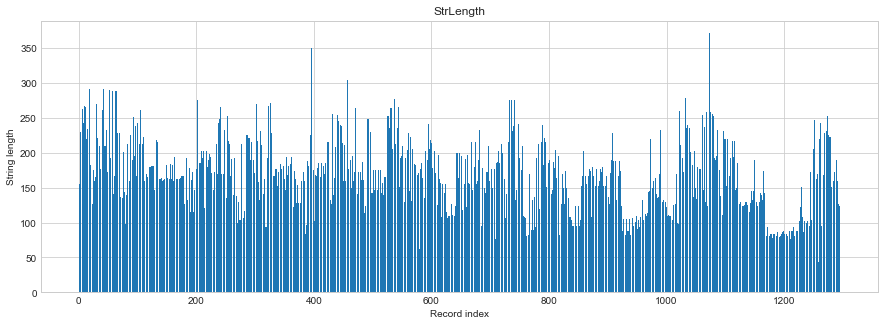

In [64]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [8]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### Jaccard VS Edit distance variance

In [10]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [15]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{('h', 'i', 's'), ('r', 'i', 'g'), ('f', ' ', 'b'), (' ', 'b', 'i'), ('m', 's', '!'), ('s', ' ', 'i'), ('d', ' ', 't'), ('b', 'i', 'g'), ('e', 'x', 'a'), ('a', 'n', 'd'), ('n', 'd', ' '), ('i', 'g', 'r'), ('r', 'a', 'm'), ('p', 'l', 'e'), (' ', 'i', 's'), ('a', 'n', ' '), ('n', ' ', 'e'), ('s', ' ', 'a'), ('l', 'e', ' '), ('t', 'r', 'i'), (' ', 'a', 'n'), ('m', 'm', 's'), ('m', 's', ' '), ('i', 's', ' '), ('o', 'f', ' '), (' ', 't', 'r'), ('e', ' ', 'o'), ('T', 'h', 'i'), ('m', 'p', 'l'), (' ', 'o', 'f'), ('x', 'a', 'm'), ('a', 'm', 'm'), (' ', 'e', 'x'), ('g', 'r', 'a'), ('a', 'm', 'p')}
{('of', 'bigramms', 'and'), ('This', 'is', 'an'), ('bigramms', 'and', 'trigramms'), ('and', 'trigramms', '!'), ('example', 'of', 'bigramms'), ('is', 'an', 'example'), ('an', 'example', 'of')}
0.0
0.0


### Prototype selection variance HeatMap

In [11]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [18]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

0.0784313725490196 0.22727272727272727 0.012987012987012988 0.13636363636363635
7


Results dataframe

In [47]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Best Jaccard execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.25
Prototypes before:
[2, 6, 8, 11, 14, 17, 19, 21, 23, 26, 29, 31, 34, 36, 38, 41, 45, 47, 49, 53, 56, 58, 64, 68, 72, 76, 78, 82, 84, 86, 88, 91, 94, 96, 98, 101, 103, 105, 107, 109, 111, 114, 116, 119, 122, 130, 133, 135, 137, 146, 149, 152, 154, 160, 162, 173, 176, 178, 180, 184, 186, 189, 191, 194, 196, 198, 200, 202, 206, 211, 213, 216, 218, 221, 224, 227, 229, 232, 235, 237, 239, 242, 245, 250, 253, 256, 259, 261, 263, 265, 269, 271, 274, 282, 290, 293, 295, 297, 299, 304, 307, 310, 313, 319, 321, 326, 328, 330, 332, 336, 341, 344, 346, 348, 351, 354, 358, 364, 366, 369, 372, 374, 376, 378, 380, 383, 385, 387, 389, 392, 395, 397, 401, 406, 411, 414, 416, 420, 424, 429, 431, 434, 436, 438, 440, 442, 445, 448, 451, 453, 455, 458, 461, 463, 469, 475, 478, 483, 485, 487, 490, 503, 507, 509, 514, 517, 524, 527, 530, 532, 534, 537, 539, 541, 544, 546, 549, 552, 554, 556, 559, 561, 563, 565, 567, 573, 577, 585, 588, 592, 594, 596, 598, 602, 605, 607, 611, 613, 615, 617, 620, 625, 62

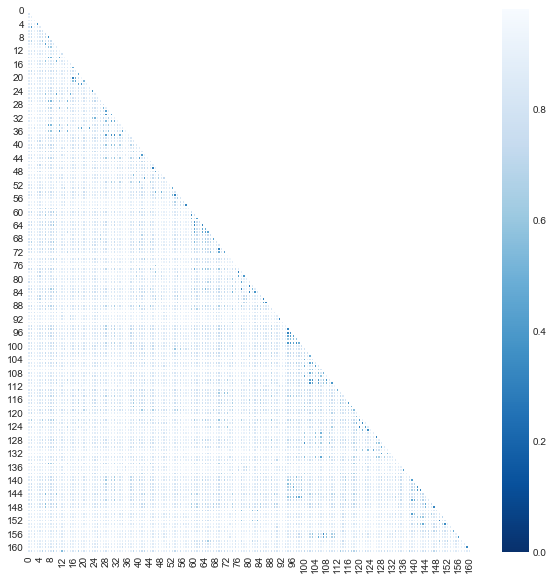


- Mean variance in prototype selection:  0.8380802735267402

- Final number of prototypes:  162

# Finished in 2.7898 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[138  48 156 ... 134 136  92]
 [  1  10  93 ... 133 136  49]
 [  1  19  94 ... 140  90  27]
 ...
 [148 107 113 ... 114 101 131]
 [146 129 154 ... 138 122 124]
 [147 130 155 ... 138 121 125]]

# Finished in 169.41 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[ 3 23 70 17 58 92 89 16 68 56 55  2 27 12 86 73 73 71 16 14 64 47 86 73
 13 15 61 45 73 85]  ->  [0, 16, 27, 28, 29, 61, 75, 76, 77, 78, 203, 260, 268, 269, 270, 287, 292, 296, 297, 304, 305, 308, 310, 328, 390, 391, 392, 393, 394, 395, 396, 398, 399, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 474, 531, 534, 545, 546, 547, 548, 549, 569, 570, 571, 573, 574, 575, 576, 577, 578, 579, 581, 582, 583, 584, 585, 922, 1065, 1097, 1101, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1253, 

[0, 16, 27, 28, 29, 61, 75, 76, 77, 78, 203, 260, 268, 269, 270, 287, 292, 296, 297, 304, 305, 308, 310, 328, 390, 391, 392, 393, 394, 395, 396, 398, 399, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 474, 531, 534, 545, 546, 547, 548, 549, 569, 570, 571, 573, 574, 575, 576, 577, 578, 579, 581, 582, 583, 584, 585, 922, 1065, 1097, 1101, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1253, 1254, 1264, 1266, 1267, 1273, 1275, 1280, 1281, 1291]
[1, 54, 55, 56, 82, 83, 89, 99, 152, 153, 156, 159, 163, 165, 170, 234, 236, 252, 253, 259, 267, 317, 321, 452, 460, 492, 497, 507, 517, 521, 528, 537, 543, 544, 604, 605, 627, 628, 629, 630, 631, 633, 634, 635, 636, 637, 638, 639, 640, 641, 664, 689, 705, 727, 728, 730, 733, 734, 735, 736, 737, 738, 740, 741, 743, 744, 745, 746, 748, 749, 750, 753, 779, 804, 805, 806, 887, 903, 925, 930, 934, 935, 937, 939, 950, 951, 952, 955, 959, 961, 962, 965, 1032, 1033, 1035, 1038, 1215, 1246]
[2, 5, 6, 7, 8, 9, 10,

In [75]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 0.3                 # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### CORA: Best Edit distance execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[2, 6, 8, 11, 14, 17, 19, 26, 29, 31, 34, 36, 38, 41, 45, 47, 50, 53, 56, 59, 68, 70, 73, 77, 81, 85, 88, 91, 94, 97, 101, 103, 105, 107, 109, 111, 114, 116, 119, 125, 127, 130, 134, 136, 150, 176, 180, 184, 189, 194, 197, 200, 206, 211, 213, 217, 220, 224, 232, 235, 237, 239, 242, 244, 250, 253, 256, 260, 265, 267, 272, 276, 282, 286, 290, 293, 296, 298, 303, 305, 307, 313, 315, 319, 321, 326, 328, 332, 336, 342, 345, 347, 349, 351, 353, 355, 358, 364, 368, 372, 374, 376, 378, 380, 383, 385, 387, 389, 392, 395, 401, 409, 414, 419, 424, 429, 431, 434, 436, 438, 440, 443, 446, 448, 452, 458, 460, 464, 467, 469, 475, 481, 488, 497, 503, 512, 525, 527, 529, 532, 534, 536, 539, 541, 544, 546, 549, 552, 554, 559, 561, 563, 565, 567, 575, 585, 588, 592, 594, 598, 602, 605, 608, 610, 615, 617, 620, 622, 624, 628, 640, 647, 651, 653, 656, 659, 661, 665, 668, 670, 672, 674, 676, 678, 681, 683, 686, 689, 691, 694, 700, 704, 708, 712, 715, 718, 723, 725, 728, 730, 732, 73

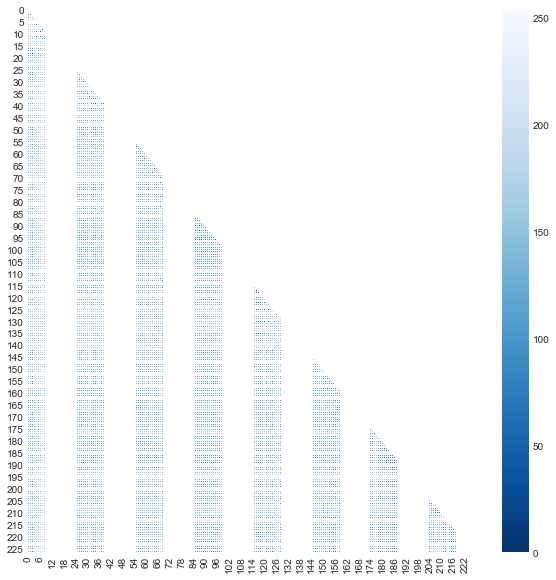


- Mean variance in prototype selection:  141.68177142968037

- Final number of prototypes:  227

# Finished in 3.4749 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


KeyboardInterrupt: 

In [74]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = False                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 100                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 30                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'l_inf'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors


start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### Grid search each section

#### GridSearch function

In [52]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars,prototypeFilter,earlyStop):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'prototypesFilterThr',"protSelectionVariance",'numOfPrototypes','numOfBuckets','averageBucketSize','Accuracy','Precision','Recall','F1','Time'])
    i=1
    for n1 in tqdm(max_numberOf_clusters):
        for n2 in (max_editDistance):
            for n3 in (similarityThreshold):
                for n4 in (windowSize):
                    for n5 in (metric):
                        for n6 in (similarityVectors):
                            for n7 in (distanceMetricEmbedding):
                                for n8 in (distanceMetric):
                                    for n9 in (number_of_permutations):
                                        for n10 in (withchars):
                                            for n11 in (withchars):
                                                for n12 in (prototypeFilter):
                                
                                                    print("+ ------------  ",i,"   ------------- +")
                                                    print('max_numberOf_clusters: ',n1)
                                                    print('max_editDistancez: ',n2)
                                                    print('similarityThreshold: ',n3)
                                                    print('windowSize: ',n4)
                                                    print('metric: ',n5)
                                                    print('similarityVectors: ',n6)
                                                    print('distanceMetricEmbedding: ',n7)
                                                    print('distanceMetric: ',n8)
                                                    print('number_of_permutations: ',n9)
                                                    print('withchars: ',n10)
                                                    print('ngramms: ',n11)
                                                    print('prototypeFilter: ',n12)
                                                    print("+ ----------------------------------- +")
                                                    start = time.time()
                                                    model = RankedWTAHash(
                                                      earlyStop = earlyStop,
                                                      max_numberOf_clusters= n1,
                                                      max_editDistance= n2,
                                                      windowSize= n4,
                                                      similarityThreshold= n3,
                                                      maxOnly= False,
                                                      metric=n5,
                                                      similarityVectors=n6,
                                                      number_of_permutations = n9,
                                                      distanceMetric= n8,
                                                      distanceMetricEmbedding = n7,
                                                      jaccard_withchars = n10,
                                                      ngramms= n11,                                                      
                                                      prototypesFilterThr = n12
                                                    )
                                                    model = model.fit(data)
                                                    exec_time = time.time() - start
                                                    if model.earlyStop==0:                                            
                                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                                        for key in model.buckets.keys():
                                                            tempListmodel.buckets[key]
                                                        averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                        numOfBuckets=len(model.buckets.keys())
                                                    else:
                                                        if model.earlyStop == 3:
                                                            acc = f1 = precision = recall = 'Not counted'
                                                            averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                            numOfBuckets=len(model.buckets.keys())
                                                        else:
                                                            numOfBuckets = averageBucketSize = acc = f1 = precision = recall = 'Not counted'
                                                    i+=1
                                                    results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n12,model.selectionVariance,model.selected_numOfPrototypes,numOfBuckets,averageBucketSize,acc,precision,recall,f1,exec_time]
    return results_dataframe

#### __[i]__ Fine tunning  __Prototype selection__


Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Parameters to fine tunne:

- ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
- ```max_editDistance```:  The threshold for the triangle inequality
- ```distanceMetric```:  Distance metric between the vectors when creating the space
- ```prototypesFilterThr```: Prototypes must differ more that threshold

All these parameters will be tested both for edit distance and jaccard with 3-grams.

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51]
Not wanted:
{51, 14, 31}
Final:
[4, 8, 12, 17, 22, 28]

- Prototypes selected
[ 4  8 12 17 22 28]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
22  ->  cesabianchi n freund y helmbold d haussler d schapire r and warmuth m how to use expert advice
28  ->  n cesabianchi y freund dp helmbold d haussler re schapire and mk warmuth how to use expert advice


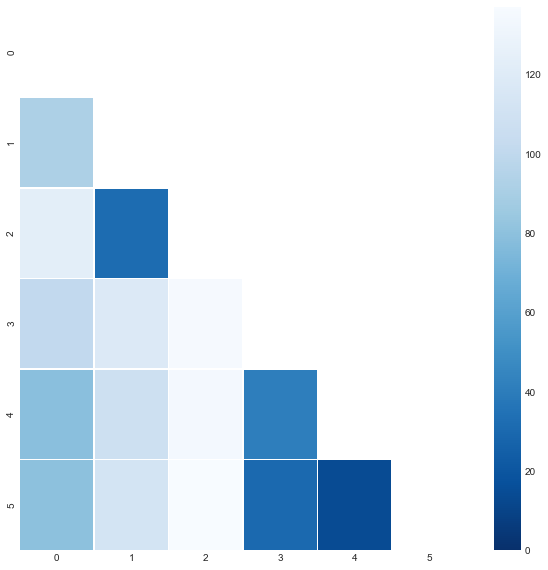


- Mean variance in prototype selection:  74.22222222222223

- Final number of prototypes:  6

# Finished in 0.5445 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51]
Not wanted:
{51, 28, 14, 31}
Final:
[4, 8, 12, 17, 22]

- Prototypes selected
[ 4  8 12 17 22]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
22  ->  cesabianchi n freund y helmbold d haussler d schapire r and warmuth m how to use expert advice


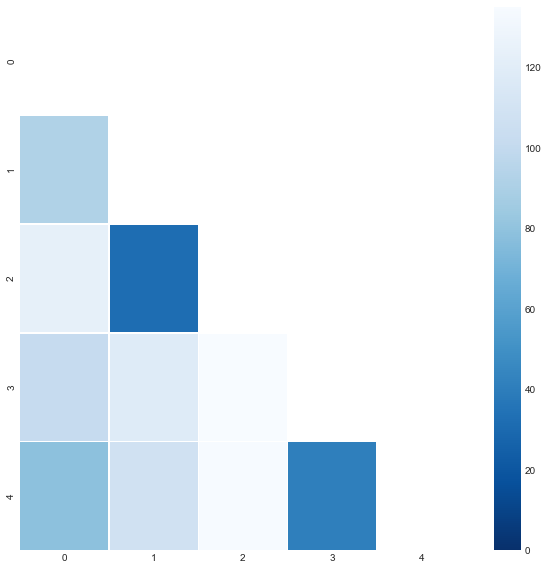


- Mean variance in prototype selection:  77.04

- Final number of prototypes:  5

# Finished in 0.4736 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51]
Not wanted:
{12, 14, 51, 28, 31}
Final:
[8, 17, 4, 22]

- Prototypes selected
[ 8 17  4 22]
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
22  ->  cesabianchi n freund y helmbold d haussler d schapire r and warmuth m how to use expert advice


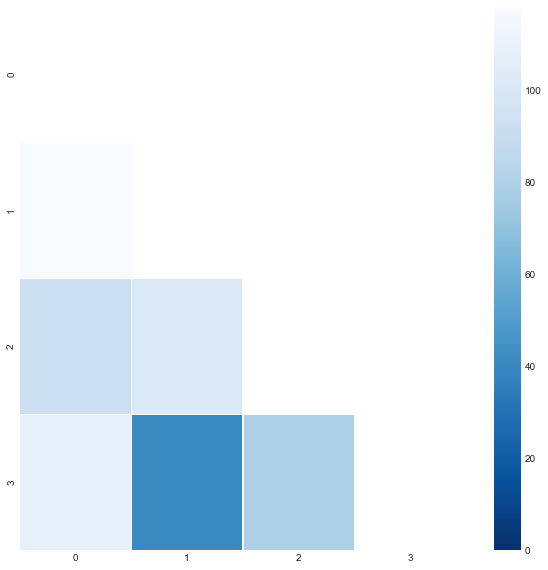


- Mean variance in prototype selection:  67.375

- Final number of prototypes:  4

# Finished in 0.4462 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51]
Not wanted:
{12, 14, 51, 22, 28, 31}
Final:
[8, 17, 4]

- Prototypes selected
[ 8 17  4]
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems


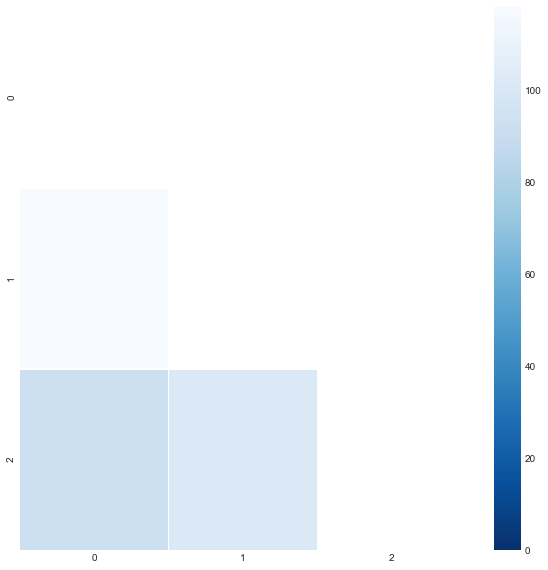


- Mean variance in prototype selection:  69.11111111111111

- Final number of prototypes:  3

# Finished in 0.5662 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51]
Not wanted:
{8, 12, 14, 51, 22, 28, 31}
Final:
[17, 4]

- Prototypes selected
[17  4]
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0482 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
###############################################################


50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77]
Not wanted:
{73}
Final:
[1, 65, 4, 69, 11, 77, 49, 53, 56]

- Prototypes selected
[ 1 65  4 69 11 77 49 53 56]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
65  ->  n cesabianchi y freund d haussler d p helmbold r e schapire and m k warmuth how to use expert advice ucsccrl9433 university of california santa cruz
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
69  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice univ of calif computer research lab
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
77  ->  n cesabianchi y freund d haussler d p helmbold r e schapire and m k warmuth how to use expert advice
49  ->  n cesabianch

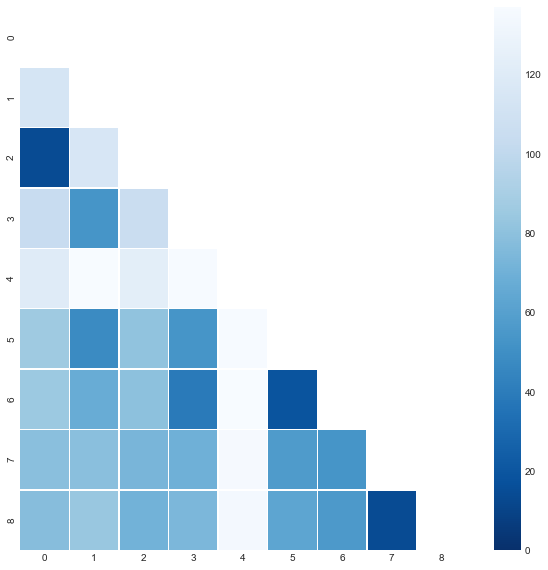


- Mean variance in prototype selection:  73.35802469135803

- Final number of prototypes:  9

# Finished in 0.5145 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77]
Not wanted:
{56, 73, 4, 77}
Final:
[65, 1, 69, 11, 49, 53]

- Prototypes selected
[65  1 69 11 49 53]
65  ->  n cesabianchi y freund d haussler d p helmbold r e schapire and m k warmuth how to use expert advice ucsccrl9433 university of california santa cruz
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
69  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice univ of calif computer research lab
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
49  ->  n cesabianchi y freund dp helmbold d haussler re schapire and mk warmuth how to use expert advice
53  ->  n cesabianchi y freund d p helmbold and m warmuth online prediction and conversion strategies


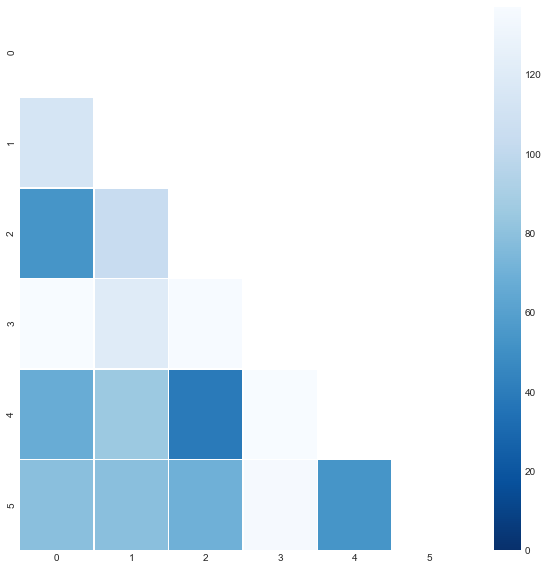


- Mean variance in prototype selection:  78.16666666666667

- Final number of prototypes:  6

# Finished in 0.4813 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77]
Not wanted:
{4, 69, 73, 77, 56}
Final:
[65, 1, 11, 49, 53]

- Prototypes selected
[65  1 11 49 53]
65  ->  n cesabianchi y freund d haussler d p helmbold r e schapire and m k warmuth how to use expert advice ucsccrl9433 university of california santa cruz
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
49  ->  n cesabianchi y freund dp helmbold d haussler re schapire and mk warmuth how to use expert advice
53  ->  n cesabianchi y freund d p helmbold and m warmuth online prediction and conversion strategies


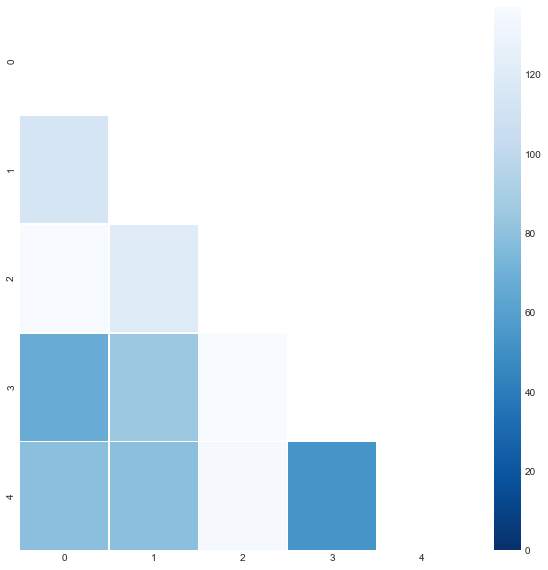


- Mean variance in prototype selection:  80.4

- Final number of prototypes:  5

# Finished in 0.4856 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77]
Not wanted:
{65, 4, 69, 73, 77, 53, 56}
Final:
[1, 11, 49]

- Prototypes selected
[ 1 11 49]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
49  ->  n cesabianchi y freund dp helmbold d haussler re schapire and mk warmuth how to use expert advice


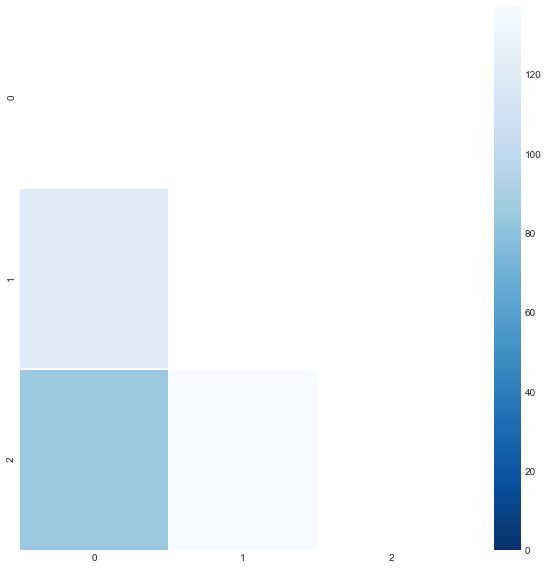


- Mean variance in prototype selection:  76.0

- Final number of prototypes:  3

# Finished in 0.4079 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77]
Not wanted:
{65, 4, 69, 73, 77, 49, 53, 56}
Final:
[1, 11]

- Prototypes selected
[ 1 11]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis

- Final number of prototypes:  2

# Finished in 0.0618 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts traini


100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397]
Not wanted:
set()
Final:
[353, 4, 133, 328, 12, 397, 209, 52, 312, 249]

- Prototypes selected
[353   4 133 328  12 397 209  52 312 249]
353  ->  freund y and schapire re experiments with a new boosting algorithm
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site 

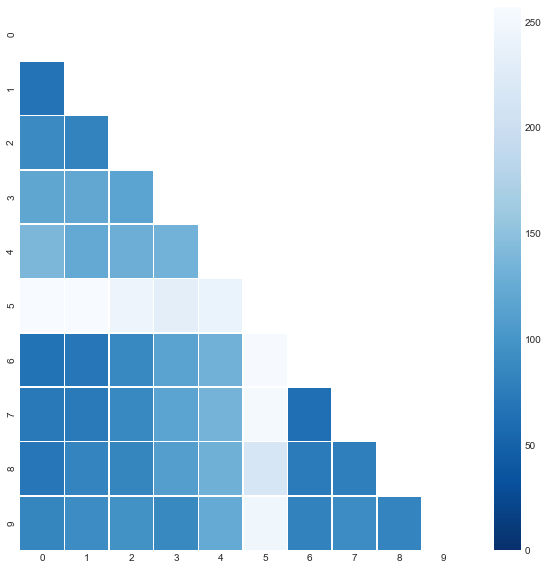


- Mean variance in prototype selection:  113.98

- Final number of prototypes:  10

# Finished in 0.6339 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397]
Not wanted:
set()
Final:
[353, 4, 133, 328, 12, 397, 209, 52, 312, 249]

- Prototypes selected
[353   4 133 328  12 397 209  52 312 249]
353  ->  freund y and schapire re experiments with a new boosting algorithm
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site 

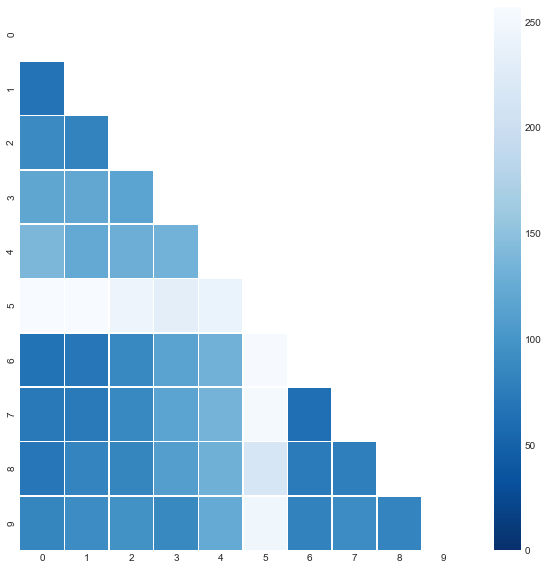


- Mean variance in prototype selection:  113.98

- Final number of prototypes:  10

# Finished in 0.5393 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397]
Not wanted:
set()
Final:
[353, 4, 133, 328, 12, 397, 209, 52, 312, 249]

- Prototypes selected
[353   4 133 328  12 397 209  52 312 249]
353  ->  freund y and schapire re experiments with a new boosting algorithm
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site 

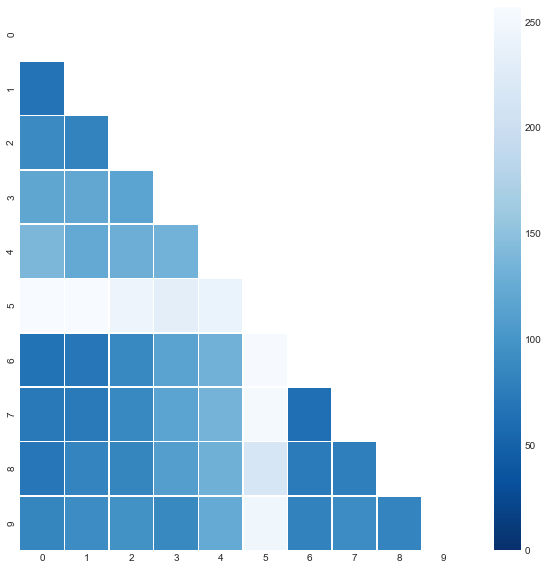


- Mean variance in prototype selection:  113.98

- Final number of prototypes:  10

# Finished in 0.5722 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397]
Not wanted:
{353, 209}
Final:
[4, 133, 328, 12, 397, 52, 312, 249]

- Prototypes selected
[  4 133 328  12 397  52 312 249]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract 

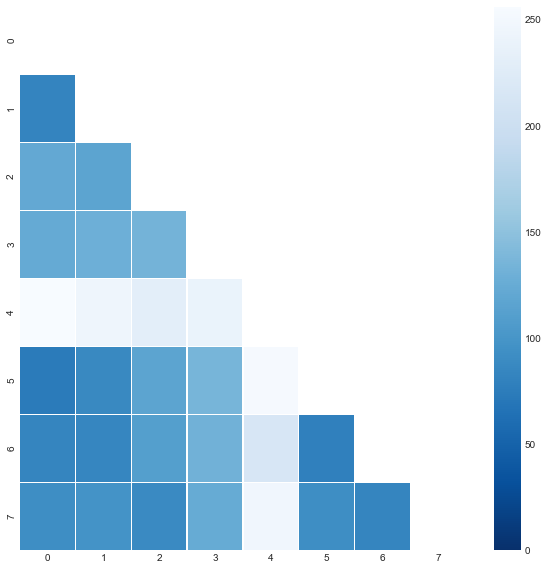


- Mean variance in prototype selection:  120.53125

- Final number of prototypes:  8

# Finished in 0.5121 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397]
Not wanted:
{353, 133, 328, 209, 52, 312, 249}
Final:
[4, 12, 397]

- Prototypes selected
[  4  12 397]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract appears in the proceedings of the second european conference on computational learning theory barcelona


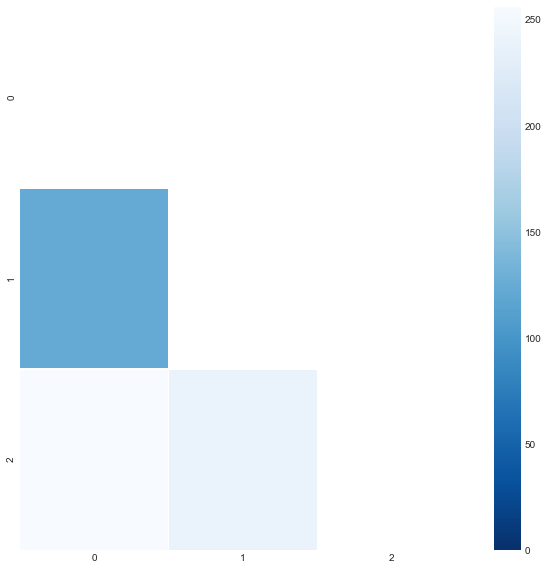


- Mean variance in prototype selection:  137.33333333333334

- Final number of prototypes:  3

# Finished in 0.4511 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


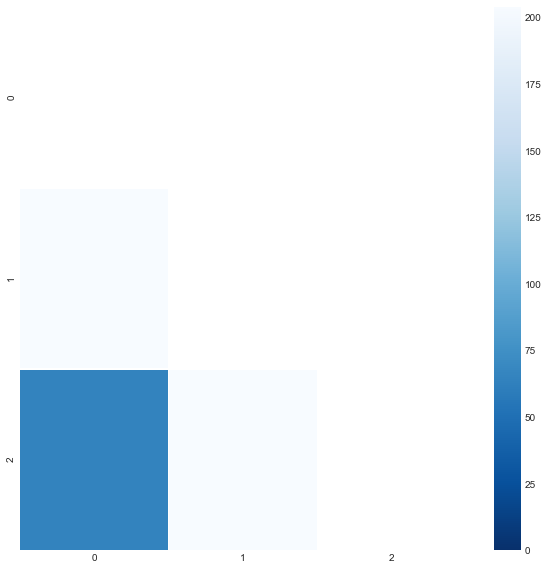


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5129 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


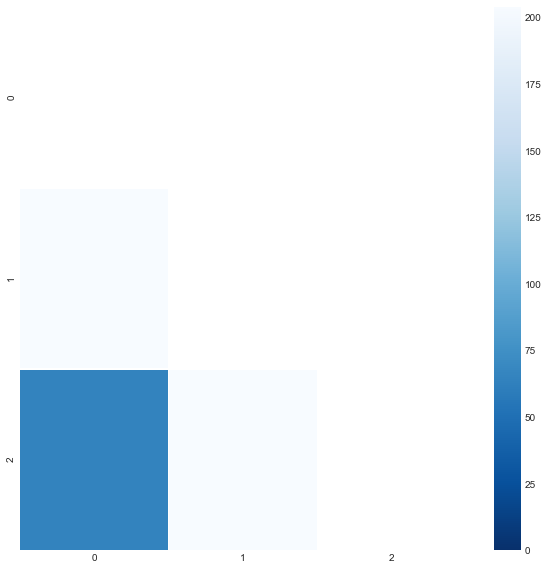


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.6523 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


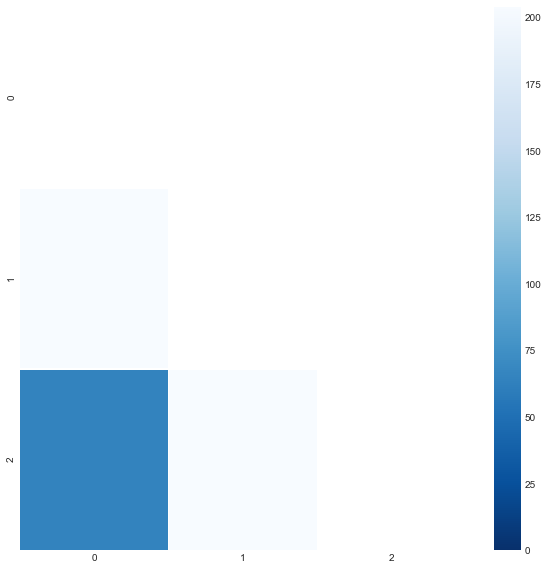


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5421 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1142 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAH


150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1440 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265]
Not wanted:
{256, 162, 168, 73, 107, 173, 14, 124, 51, 116, 151, 155, 60, 31}
Final:
[130, 4, 8, 265, 12, 140, 17, 22, 153, 28, 178, 180, 53, 190, 64, 68, 70, 77, 209, 82, 89, 97, 232, 238, 112, 114, 242]

- Prototypes selected
[130   4   8 265  12 140  17  22 153  28 178 180  53 190  64  68  70  77
 209  82  89  97 232 238 112 114 242]
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
265  ->  yoav freund data filtering and distribution modeling algorithms fo

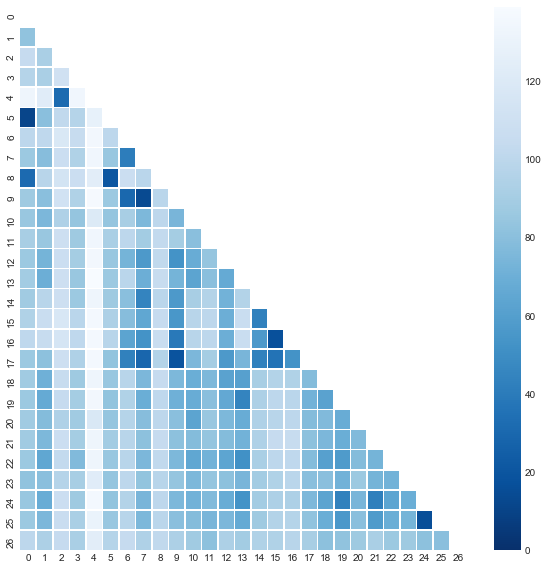


- Mean variance in prototype selection:  82.8559670781893

- Final number of prototypes:  27

# Finished in 1.0041 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265]
Not wanted:
{256, 140, 14, 151, 155, 28, 31, 162, 168, 173, 51, 60, 70, 73, 77, 107, 114, 116, 124}
Final:
[130, 4, 8, 265, 12, 17, 22, 153, 178, 180, 53, 190, 64, 68, 209, 82, 89, 97, 232, 238, 112, 242]

- Prototypes selected
[130   4   8 265  12  17  22 153 178 180  53 190  64  68 209  82  89  97
 232 238 112 242]
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
265  ->  yoav freund data filtering and distribution modeling algorithms for machine learning u

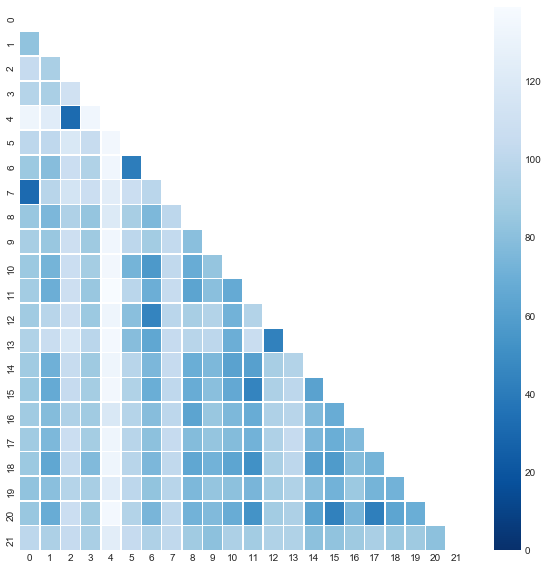


- Mean variance in prototype selection:  84.72727272727273

- Final number of prototypes:  22

# Finished in 0.8621 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265]
Not wanted:
{256, 12, 140, 14, 151, 153, 155, 28, 31, 162, 168, 173, 51, 60, 70, 73, 77, 107, 112, 114, 116, 124}
Final:
[130, 4, 8, 265, 17, 22, 178, 180, 53, 190, 64, 68, 209, 82, 89, 97, 232, 238, 242]

- Prototypes selected
[130   4   8 265  17  22 178 180  53 190  64  68 209  82  89  97 232 238
 242]
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
265  ->  yoav freund data filtering and distribution modeling algorithms for machine learning university of

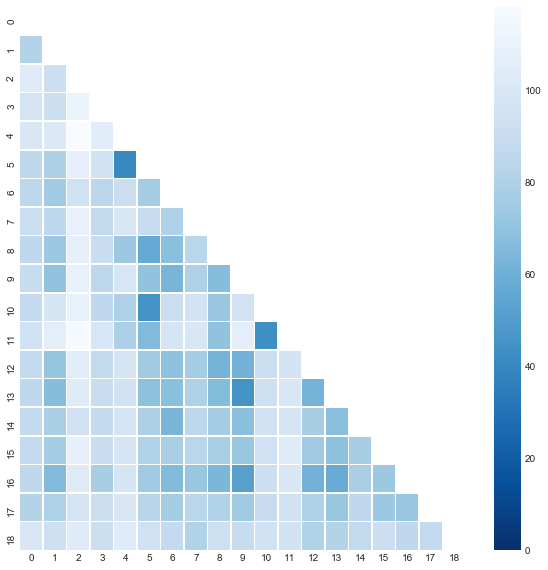


- Mean variance in prototype selection:  80.18282548476455

- Final number of prototypes:  19

# Finished in 0.7068 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265]
Not wanted:
{256, 12, 140, 14, 22, 151, 153, 155, 28, 31, 162, 168, 173, 178, 51, 53, 60, 190, 64, 68, 70, 73, 77, 209, 82, 89, 97, 232, 107, 238, 112, 114, 116, 124}
Final:
[130, 4, 8, 265, 17, 242, 180]

- Prototypes selected
[130   4   8 265  17 242 180]
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
8  ->  a blum m furst j jackson m kearns y mansour and s rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
265  ->  yoav freund data filtering and distribution modeling algorithms for machine learning university of california at santa cruz
17  ->  nicolo cesabian

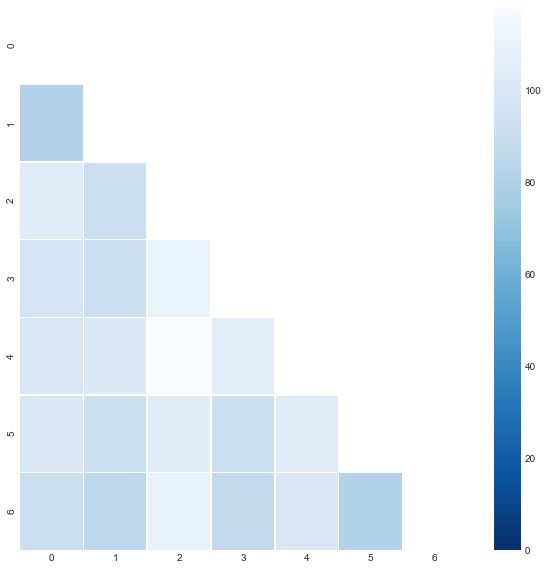


- Mean variance in prototype selection:  83.59183673469387

- Final number of prototypes:  7

# Finished in 0.5110 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265]
Not wanted:
{256, 130, 8, 265, 140, 12, 14, 22, 151, 153, 155, 28, 31, 162, 168, 173, 178, 51, 180, 53, 60, 190, 64, 68, 70, 73, 77, 209, 82, 89, 97, 232, 107, 238, 112, 114, 242, 116, 124}
Final:
[17, 4]

- Prototypes selected
[17  4]
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0772 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  


50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462]
Not wanted:
{101, 73, 394, 277, 122, 158}
Final:
[1, 130, 4, 136, 265, 11, 267, 406, 296, 424, 428, 49, 178, 435, 180, 53, 438, 56, 443, 190, 320, 65, 452, 69, 328, 458, 331, 77, 462, 209, 82, 339, 89, 97, 232, 105, 365, 238, 114, 119, 249]

- Prototypes selected
[  1 130   4 136 265  11 267 406 296 424 428  49 178 435 180  53 438  56
 443 190 320  65 452  69 328 458 331  77 462 209  82 339  89  97 232 105
 365 238 114 119 249]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learni

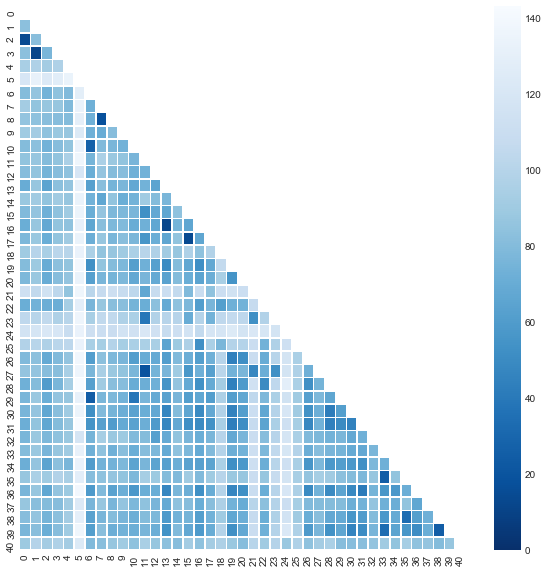


- Mean variance in prototype selection:  80.68411659726354

- Final number of prototypes:  41

# Finished in 1.3087 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462]
Not wanted:
{4, 101, 136, 73, 394, 77, 277, 406, 438, 56, 122, 158}
Final:
[1, 130, 265, 267, 11, 296, 424, 428, 49, 178, 435, 180, 53, 443, 190, 320, 65, 452, 69, 328, 458, 331, 462, 209, 82, 339, 89, 97, 232, 105, 365, 238, 114, 119, 249]

- Prototypes selected
[  1 130 265 267  11 296 424 428  49 178 435 180  53 443 190 320  65 452
  69 328 458 331 462 209  82 339  89  97 232 105 365 238 114 119 249]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
265  ->  yoav freund data filtering and distribution modeling algorithms for machine learning university of ca

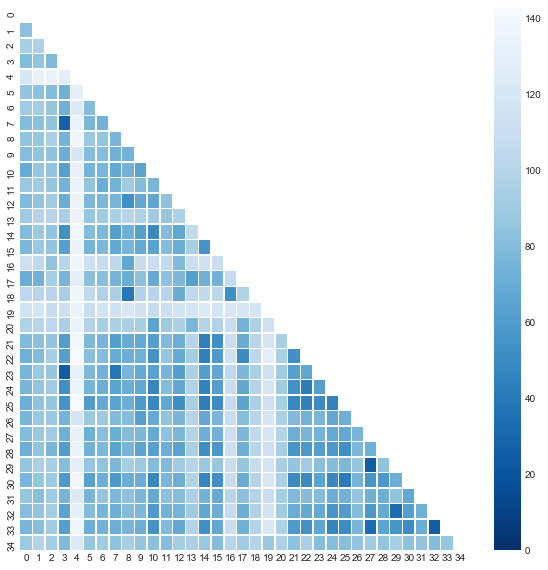


- Mean variance in prototype selection:  81.51836734693877

- Final number of prototypes:  35

# Finished in 1.2654 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462]
Not wanted:
{4, 69, 101, 136, 73, 105, 267, 428, 77, 394, 114, 277, 406, 119, 56, 438, 122, 158}
Final:
[1, 130, 265, 11, 296, 424, 49, 178, 435, 180, 53, 443, 190, 320, 65, 452, 328, 458, 331, 462, 209, 82, 339, 89, 97, 232, 365, 238, 249]

- Prototypes selected
[  1 130 265  11 296 424  49 178 435 180  53 443 190 320  65 452 328 458
 331 462 209  82 339  89  97 232 365 238 249]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
265  ->  yoav freund data filtering and distribution modeling algorithms for machine learning university of california at santa cruz
1

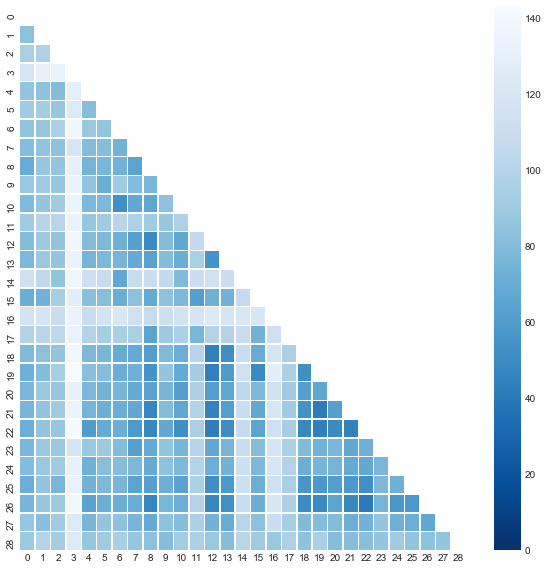


- Mean variance in prototype selection:  82.4256837098692

- Final number of prototypes:  29

# Finished in 1.1027 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462]
Not wanted:
{4, 136, 394, 267, 277, 406, 158, 424, 428, 178, 435, 53, 438, 56, 190, 320, 65, 452, 69, 73, 458, 331, 77, 462, 209, 82, 339, 89, 97, 101, 232, 105, 365, 114, 119, 122}
Final:
[1, 130, 296, 265, 328, 11, 238, 49, 180, 249, 443]

- Prototypes selected
[  1 130 296 265 328  11 238  49 180 249 443]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
296  ->  freund y and schapire r a decisiontheoretic generalization of online learning and an application to boosting
265  ->  yoav freund data filtering and distribution modeling algorithms for machine lear

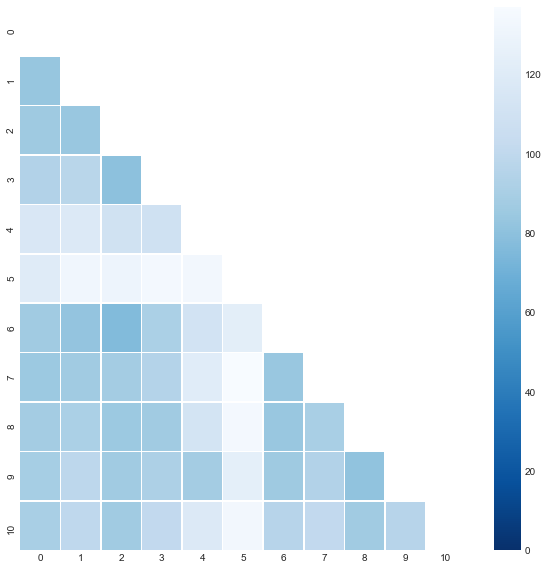


- Mean variance in prototype selection:  91.12396694214875

- Final number of prototypes:  11

# Finished in 0.6110 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462]
Not wanted:
{130, 4, 136, 265, 394, 267, 277, 406, 158, 296, 424, 428, 49, 178, 435, 180, 53, 438, 56, 443, 190, 320, 65, 452, 69, 328, 73, 458, 331, 77, 462, 209, 82, 339, 89, 97, 101, 232, 105, 365, 238, 114, 119, 249, 122}
Final:
[1, 11]

- Prototypes selected
[ 1 11]
1  ->  a blum m furst m j kearns and richard j lipton cryptographic primitives based on hard learning problems
11  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis

- Final number of prototypes:  2

# Finished in 0.1132 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
window


100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 1136, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069 1136  499   52  312  249  700
  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and

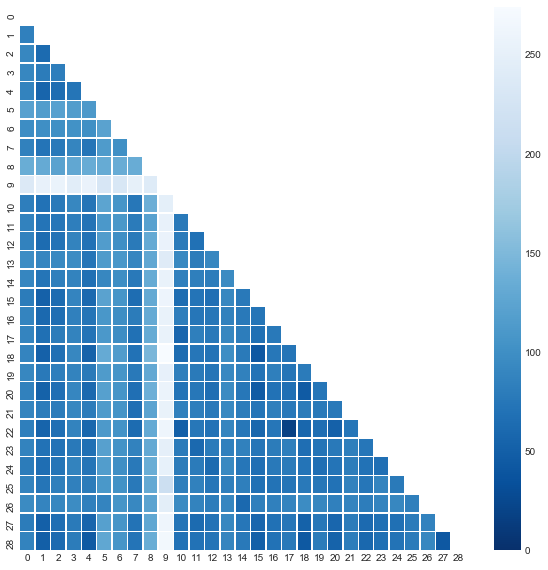


- Mean variance in prototype selection:  92.48038049940547

- Final number of prototypes:  29

# Finished in 1.0725 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

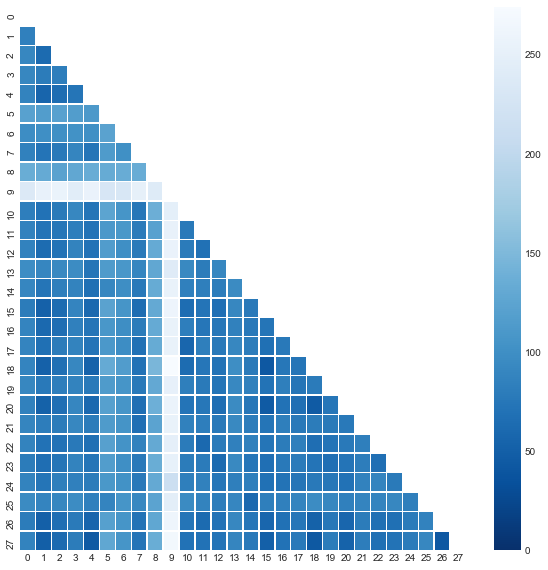


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0760 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

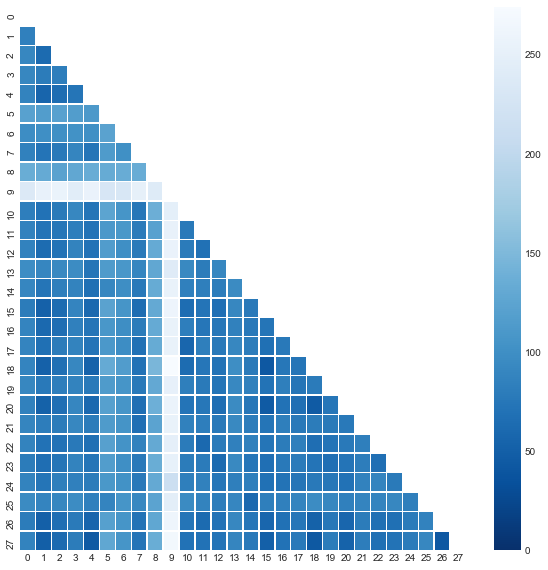


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0943 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{353, 961, 453, 1112, 1290, 588, 1166, 399, 1136, 209, 499, 916, 1239, 728, 1182, 700, 766, 607}
Final:
[1281, 4, 133, 328, 1034, 12, 397, 1069, 530, 52, 312, 249]

- Prototypes selected
[1281    4  133  328 1034   12  397 1069  530   52  312  249]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
1034  ->  kearns m j a bound on

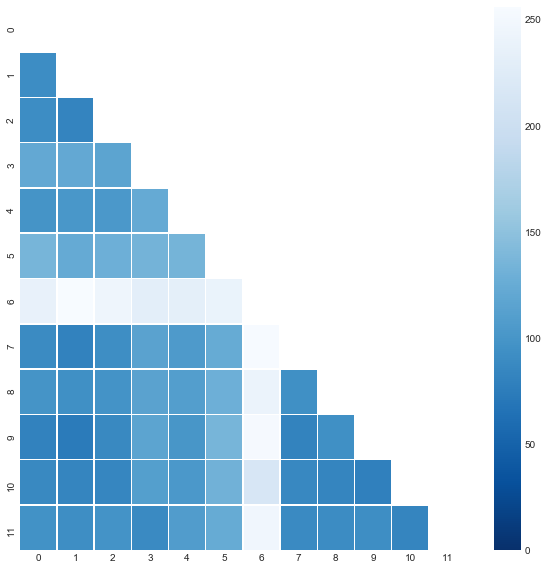


- Mean variance in prototype selection:  114.56944444444444

- Final number of prototypes:  12

# Finished in 0.6565 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1281, 133, 1290, 1034, 1166, 399, 530, 916, 1182, 1069, 52, 312, 700, 961, 453, 328, 588, 209, 1239, 728, 1112, 607, 353, 1136, 499, 249, 766}
Final:
[4, 12, 397]

- Prototypes selected
[  4  12 397]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract appears in the proceedings of the second european conference on computational learning theory barcelon

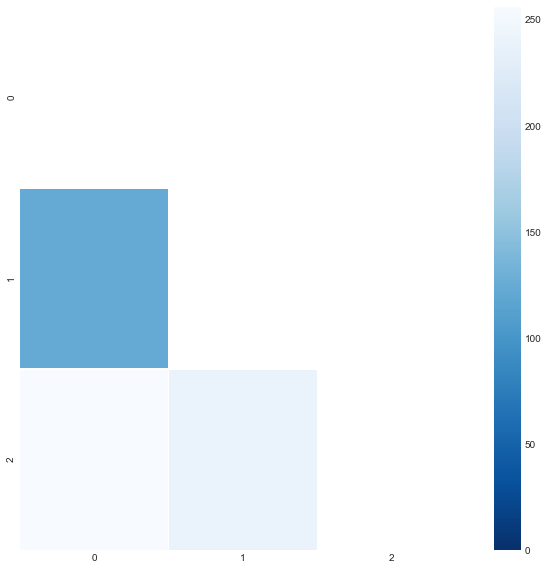


- Mean variance in prototype selection:  137.33333333333334

- Final number of prototypes:  3

# Finished in 0.5148 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


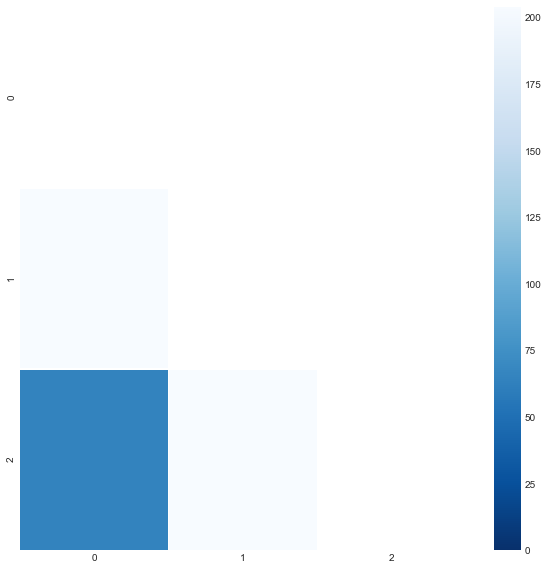


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5148 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


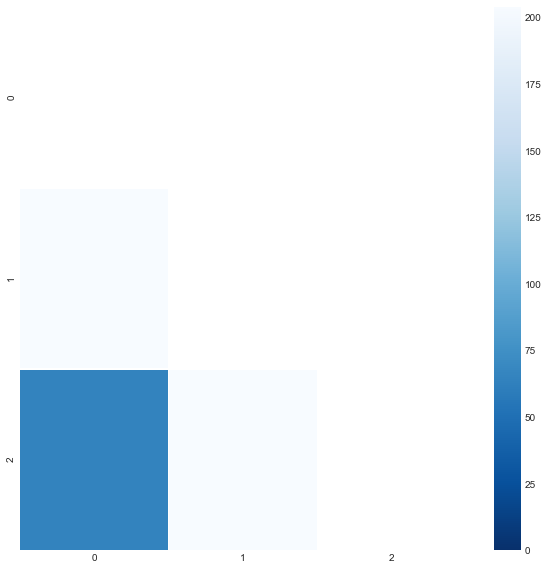


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.6671 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


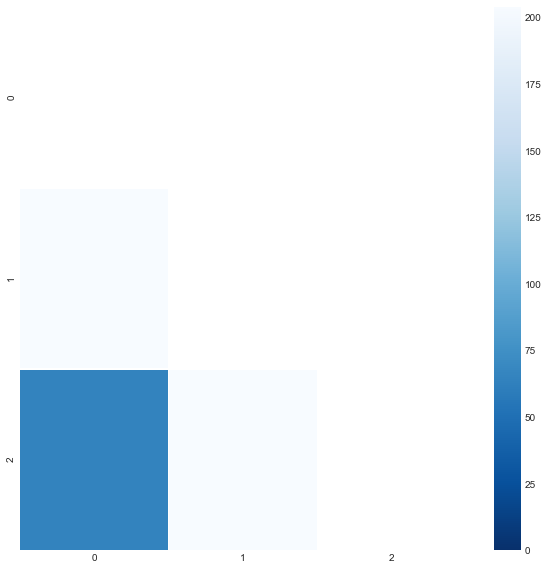


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4767 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1284 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAH


150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1233 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHa


25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570]
Not wanted:
{256, 512, 389, 518, 394, 14, 401, 277, 151, 155, 31, 162, 168, 173, 51, 567, 60, 447, 326, 328, 73, 489, 107, 116, 378, 124}
Final:
[130, 4, 8, 265, 267, 12, 140, 17, 532, 22, 153, 410, 28, 549, 296, 424, 557, 429, 431, 178, 563, 180, 53, 434, 438, 570, 442, 190, 64, 320, 323, 68, 452, 70, 458, 332, 77, 462, 209, 82, 337, 341, 89, 475, 350, 478, 97, 232, 238, 112, 114, 242, 509]

- Prototypes selected
[130   4   8 265 267  12 140  17 532  22 153 410  28 549 296 424 557 429
 431 178 563 180  53 434 438 570 442 190  64 320 323  68 452  70 458 332
  77 462 209  82 337 341  89 475 350

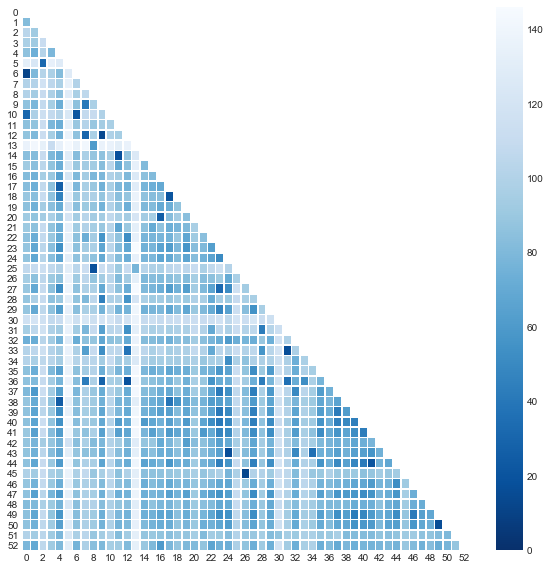


- Mean variance in prototype selection:  85.41473834104663

- Final number of prototypes:  53

# Finished in 1.7121 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570]
Not wanted:
{256, 512, 389, 518, 394, 140, 14, 401, 277, 151, 410, 155, 28, 31, 162, 168, 173, 51, 567, 570, 60, 447, 70, 326, 328, 73, 77, 475, 478, 489, 107, 114, 116, 378, 124}
Final:
[130, 4, 8, 265, 267, 12, 17, 532, 22, 153, 549, 296, 424, 557, 429, 431, 178, 563, 180, 53, 434, 438, 442, 190, 64, 320, 323, 68, 452, 458, 332, 462, 209, 82, 337, 341, 89, 350, 97, 232, 238, 112, 242, 509]

- Prototypes selected
[130   4   8 265 267  12  17 532  22 153 549 296 424 557 429 431 178 563
 180  53 434 438 442 190  64 320 323  68 452 458 332 462 209  82 337 341
  89 350  97 232 238 112 242 509]
13

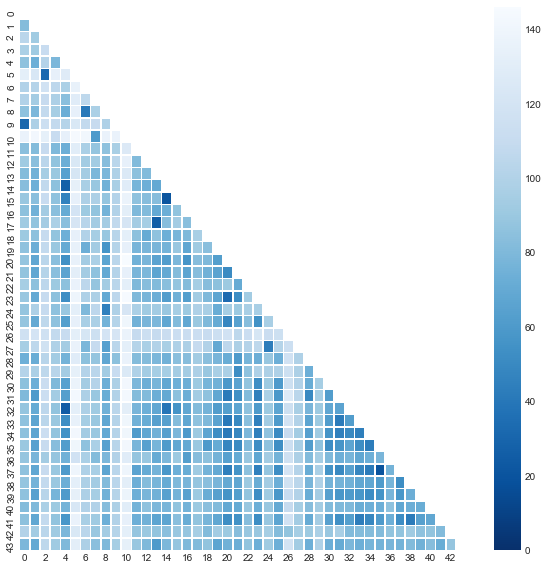


- Mean variance in prototype selection:  85.01756198347107

- Final number of prototypes:  44

# Finished in 1.2960 secs


+ ------------   43    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570]
Not wanted:
{256, 512, 389, 518, 394, 267, 12, 140, 14, 401, 277, 151, 153, 410, 155, 28, 31, 162, 168, 173, 429, 431, 434, 51, 563, 567, 570, 60, 447, 70, 326, 328, 73, 77, 475, 350, 478, 489, 107, 112, 114, 116, 378, 124}
Final:
[130, 4, 8, 265, 17, 532, 22, 549, 296, 424, 557, 178, 180, 53, 438, 442, 190, 64, 320, 323, 68, 452, 458, 332, 462, 209, 82, 337, 341, 89, 97, 232, 238, 242, 509]

- Prototypes selected
[130   4   8 265  17 532  22 549 296 424 557 178 180  53 438 442 190  64
 320 323  68 452 458 332 462 209  82 337 341  89  97 232 238 242 509]
130  ->  ehrenfeucht a haussler d kearn

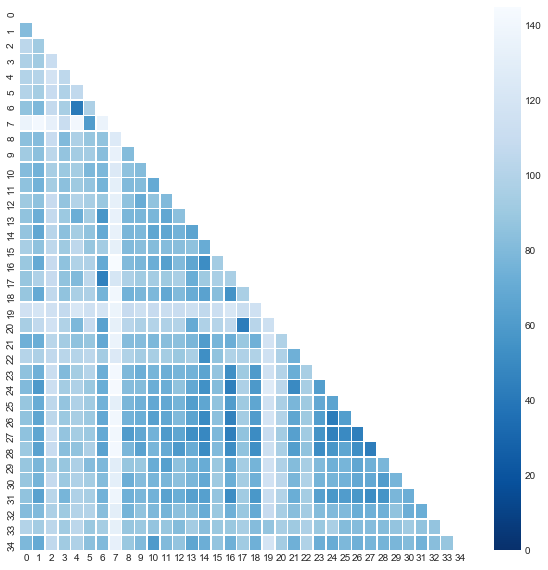


- Mean variance in prototype selection:  84.23020408163265

- Final number of prototypes:  35

# Finished in 1.2584 secs


+ ------------   44    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570]
Not wanted:
{512, 256, 389, 518, 394, 267, 12, 140, 14, 401, 277, 22, 151, 153, 410, 155, 28, 31, 162, 549, 168, 424, 429, 557, 173, 431, 434, 51, 178, 53, 438, 567, 563, 570, 60, 190, 447, 64, 320, 68, 452, 70, 326, 328, 73, 458, 332, 77, 462, 337, 82, 209, 341, 89, 475, 350, 478, 97, 232, 489, 107, 238, 112, 114, 116, 378, 124, 509}
Final:
[130, 323, 4, 8, 265, 296, 17, 242, 532, 180, 442]

- Prototypes selected
[130 323   4   8 265 296  17 242 532 180 442]
130  ->  ehrenfeucht a haussler d kearns m and valiant lg a general lower bound on the number of examples needed for learning
323  ->  y

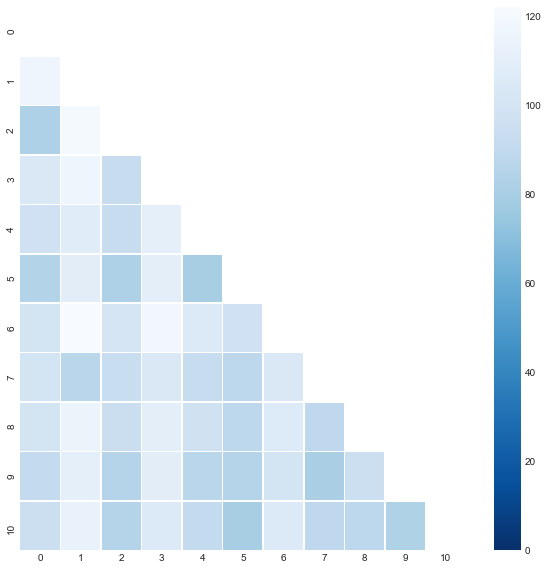


- Mean variance in prototype selection:  89.12396694214875

- Final number of prototypes:  11

# Finished in 0.6251 secs


+ ------------   45    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570]
Not wanted:
{512, 518, 8, 12, 14, 532, 22, 28, 31, 549, 557, 51, 563, 53, 567, 570, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509}
Final:
[17, 4]

- Prototypes selected
[17  4]
17  ->  nicolo cesabianchi yoav freund david p helmbold david haussler robert e schapire and manfred k warmuth how to use expert advice
4  ->  a blum m furst m kearns r lipto


50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071]
Not wanted:
{902, 519, 394, 277, 1051, 158, 802, 575, 584, 73, 588, 972, 847, 985, 101, 615, 489, 1010, 122}
Final:
[1, 4, 1029, 1033, 265, 11, 778, 1037, 267, 785, 532, 1045, 1047, 1055, 1057, 1059, 549, 806, 296, 1071, 49, 820, 53, 56, 568, 320, 65, 69, 328, 331, 77, 593, 82, 339, 598, 89, 606, 97, 866, 105, 619, 365, 114, 119, 638, 130, 136, 914, 406, 674, 424, 684, 428, 178, 435, 180, 438, 951, 698, 443, 190, 452, 713, 458, 462, 209, 475, 478, 739, 232, 238, 498, 756, 249, 1019, 767]

- Protot

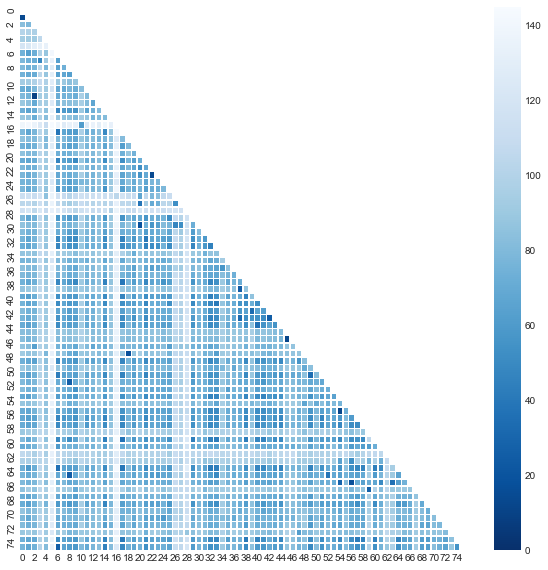


- Mean variance in prototype selection:  80.8126731301939

- Final number of prototypes:  76

# Finished in 1.7142 secs


+ ------------   47    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071]
Not wanted:
{4, 902, 519, 136, 394, 277, 406, 1047, 1051, 158, 802, 438, 56, 575, 584, 73, 588, 77, 972, 847, 985, 475, 101, 615, 489, 1010, 122}
Final:
[1, 130, 1029, 1033, 265, 11, 778, 1037, 267, 785, 914, 532, 1045, 1055, 1057, 674, 1059, 549, 806, 296, 424, 684, 428, 1071, 49, 178, 435, 180, 53, 820, 951, 568, 698, 443, 190, 320, 65, 452, 69, 328, 713, 458, 331, 462, 593, 82, 209, 339, 598, 89, 606, 478, 97, 866, 739, 232, 105, 619, 365, 238, 114, 498, 756, 119, 249, 1019, 638, 767]

- Protot

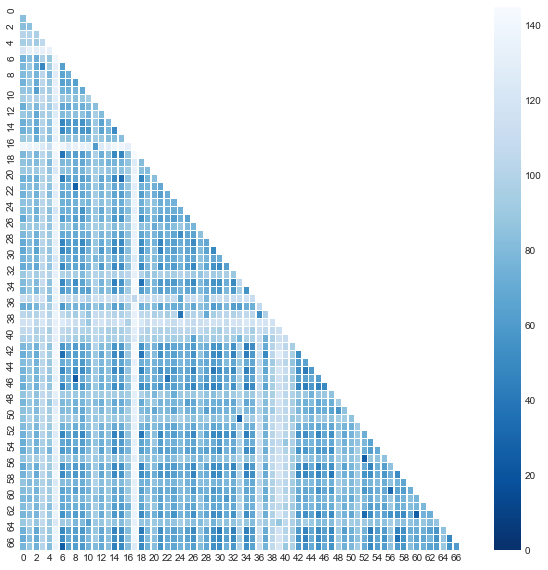


- Mean variance in prototype selection:  81.27032871972318

- Final number of prototypes:  68

# Finished in 1.4602 secs


+ ------------   48    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071]
Not wanted:
{4, 902, 519, 136, 394, 267, 778, 277, 406, 1047, 1051, 158, 802, 806, 428, 684, 438, 56, 575, 69, 584, 73, 588, 77, 972, 847, 985, 475, 478, 101, 615, 105, 489, 114, 1010, 119, 122, 638}
Final:
[1, 130, 1029, 1033, 265, 11, 1037, 785, 914, 532, 1045, 1055, 1057, 674, 1059, 549, 296, 424, 1071, 49, 178, 435, 180, 53, 820, 951, 568, 698, 443, 190, 320, 65, 452, 328, 713, 458, 331, 462, 593, 82, 209, 339, 598, 89, 606, 97, 866, 739, 232, 619, 365, 238, 498, 756, 249, 1019, 767]

- Protot

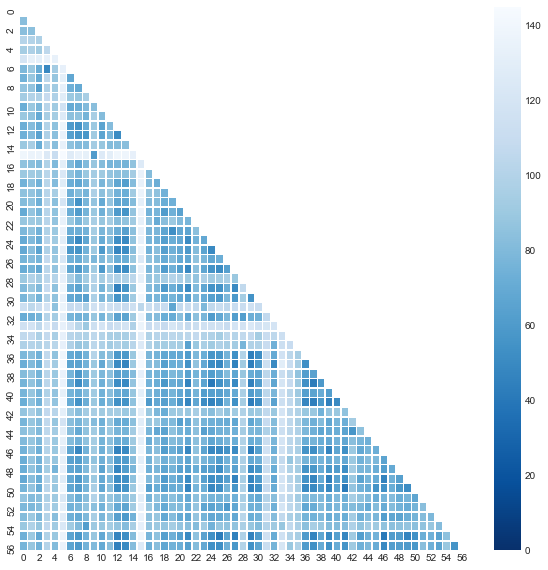


- Mean variance in prototype selection:  82.31271160357034

- Final number of prototypes:  57

# Finished in 1.4786 secs


+ ------------   49    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071]
Not wanted:
{4, 1029, 519, 1037, 1045, 1047, 1051, 1055, 1057, 549, 1071, 53, 56, 568, 575, 65, 69, 584, 73, 588, 77, 593, 82, 89, 606, 97, 101, 615, 105, 619, 114, 119, 122, 638, 136, 158, 674, 684, 178, 698, 190, 209, 739, 232, 756, 767, 778, 267, 785, 277, 802, 806, 820, 320, 331, 847, 339, 866, 365, 902, 394, 914, 406, 424, 428, 435, 438, 951, 452, 458, 972, 462, 985, 475, 478, 489, 1010, 498, 1019}
Final:
[1, 130, 1059, 296, 1033, 713, 11, 265, 328, 238, 49, 532, 180, 598, 249, 443]

- Protot

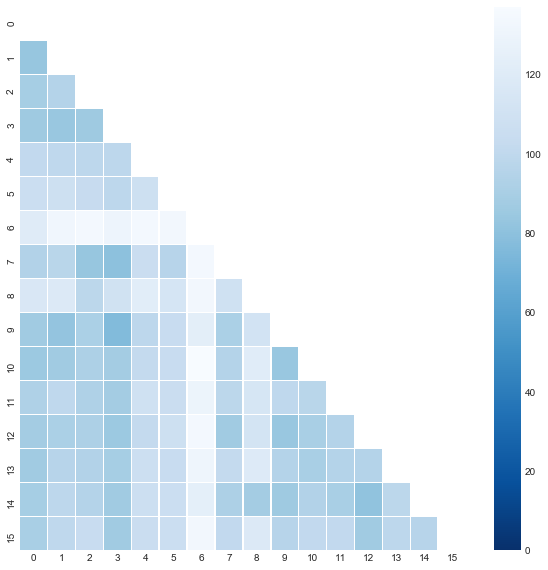


- Mean variance in prototype selection:  94.953125

- Final number of prototypes:  16

# Finished in 0.7561 secs


+ ------------   50    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071]
Not wanted:
{4, 1029, 519, 1033, 1037, 532, 1045, 1047, 1051, 1055, 1057, 1059, 549, 1071, 49, 53, 56, 568, 575, 65, 69, 584, 73, 588, 77, 593, 82, 598, 89, 606, 97, 101, 615, 105, 619, 114, 119, 122, 638, 130, 136, 158, 674, 684, 178, 180, 698, 190, 713, 209, 739, 232, 238, 756, 249, 767, 265, 778, 267, 785, 277, 802, 806, 296, 820, 320, 328, 331, 847, 339, 866, 365, 902, 394, 914, 406, 424, 428, 435, 438, 951, 443, 452, 458, 972, 462, 985, 475, 478, 489, 498, 1010, 1019}
Final:
[1, 11]

- Protot


100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 1136, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069 1136  499   52  312  249  700
  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and

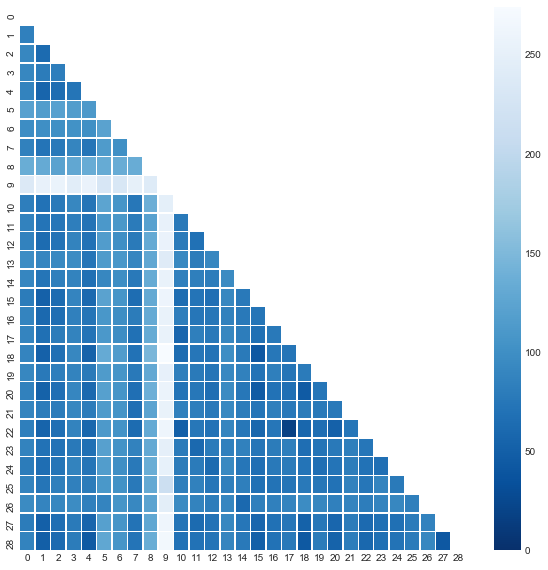


- Mean variance in prototype selection:  92.48038049940547

- Final number of prototypes:  29

# Finished in 1.1122 secs


+ ------------   52    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

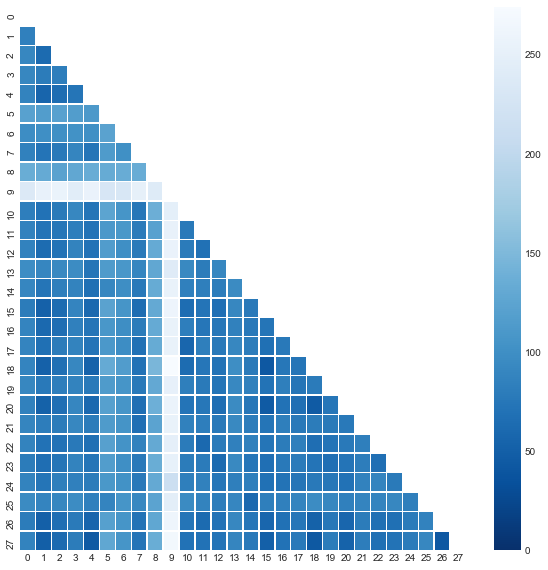


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0588 secs


+ ------------   53    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

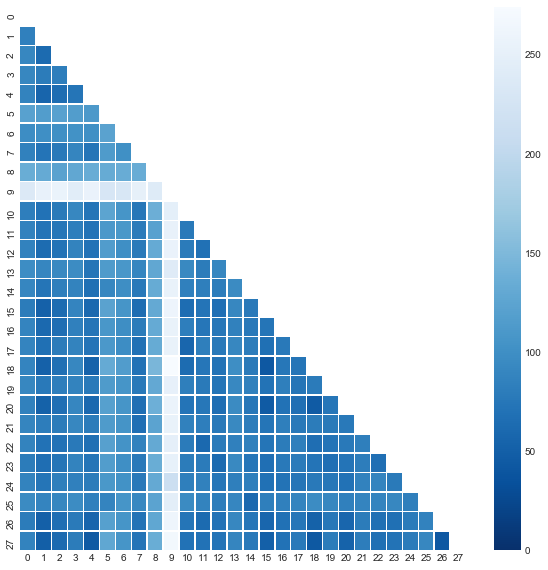


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0229 secs


+ ------------   54    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{353, 961, 453, 1112, 1290, 588, 1166, 399, 1136, 209, 499, 916, 1239, 728, 1182, 700, 766, 607}
Final:
[1281, 4, 133, 328, 1034, 12, 397, 1069, 530, 52, 312, 249]

- Prototypes selected
[1281    4  133  328 1034   12  397 1069  530   52  312  249]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
1034  ->  kearns m j a bound on

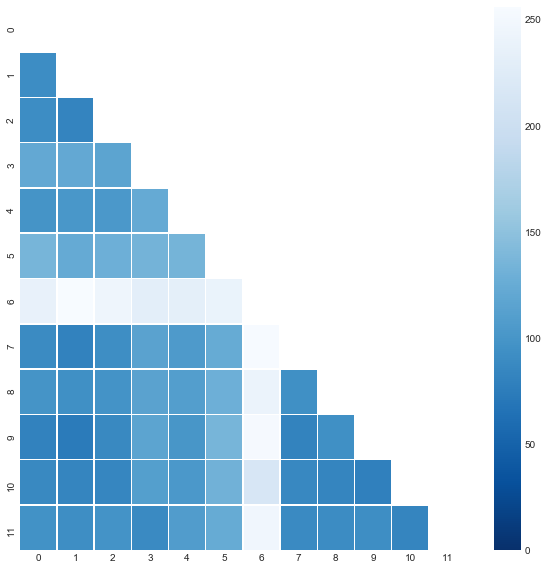


- Mean variance in prototype selection:  114.56944444444444

- Final number of prototypes:  12

# Finished in 0.7757 secs


+ ------------   55    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1281, 133, 1290, 1034, 1166, 399, 530, 916, 1182, 1069, 52, 312, 700, 961, 453, 328, 588, 209, 1239, 728, 1112, 607, 353, 1136, 499, 249, 766}
Final:
[4, 12, 397]

- Prototypes selected
[  4  12 397]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract appears in the proceedings of the second european conference on computational learning theory barcelon

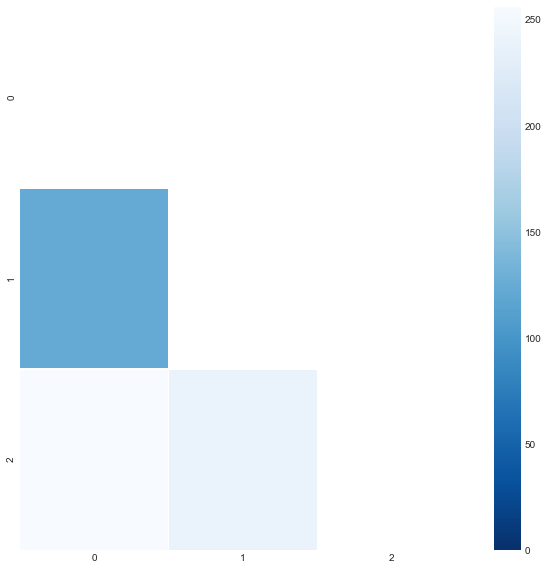


- Mean variance in prototype selection:  137.33333333333334

- Final number of prototypes:  3

# Finished in 0.4569 secs


+ ------------   56    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


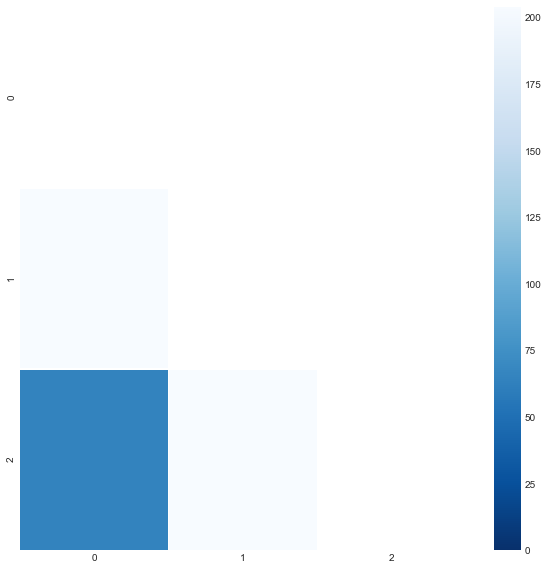


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4622 secs


+ ------------   57    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


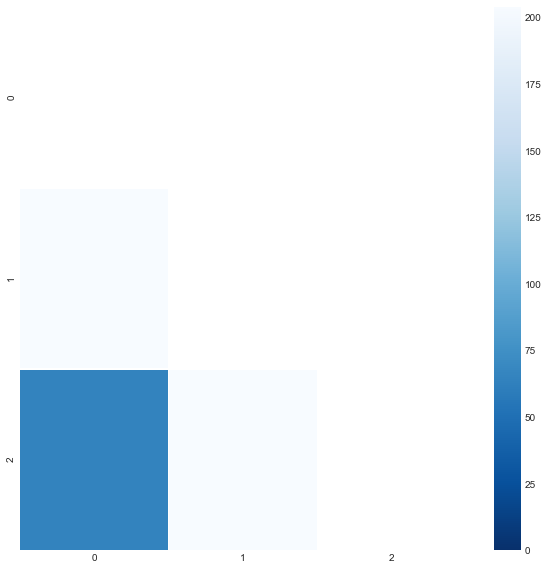


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4511 secs


+ ------------   58    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


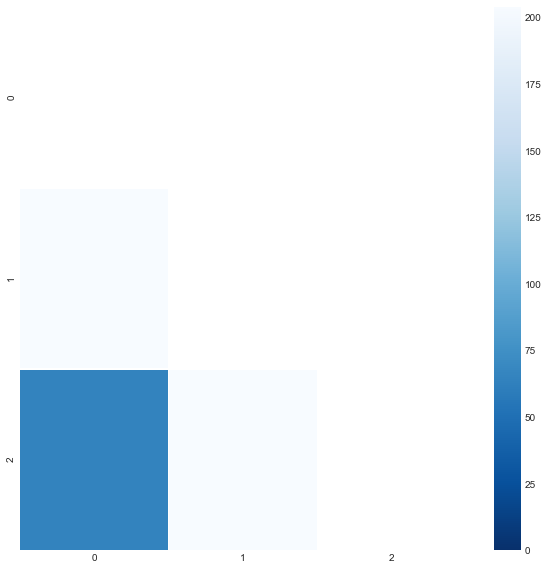


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5232 secs


+ ------------   59    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1219 secs


+ ------------   60    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTA


150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1104 secs


+ ------------   61    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHa


25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{256, 512, 896, 1155, 389, 518, 394, 778, 14, 1294, 1040, 401, 914, 1172, 277, 151, 155, 1

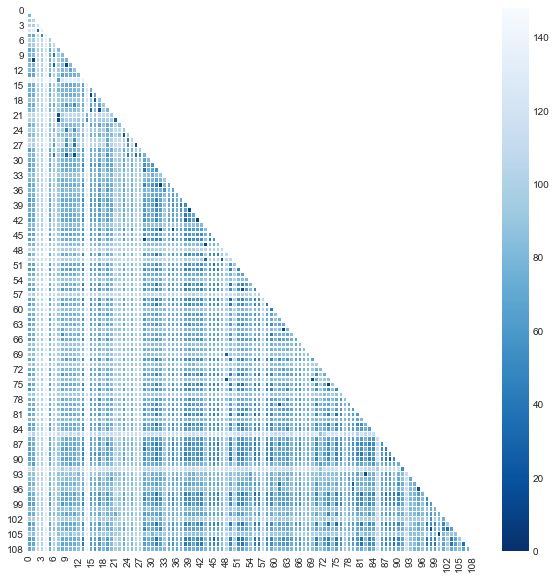


- Mean variance in prototype selection:  81.44701624442386

- Final number of prototypes:  109

# Finished in 1.7611 secs


+ ------------   62    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 518, 14, 1040, 1047, 1051, 28, 31, 1071, 51, 567, 570, 60, 572, 576, 1088, 70, 584, 

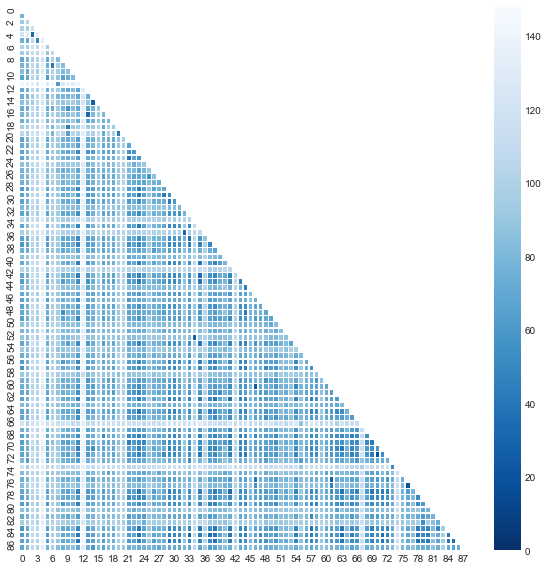


- Mean variance in prototype selection:  81.43724173553719

- Final number of prototypes:  88

# Finished in 1.7174 secs


+ ------------   63    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 518, 12, 14, 1040, 1047, 1051, 28, 31, 1071, 51, 563, 567, 1079, 570, 60, 572, 576, 

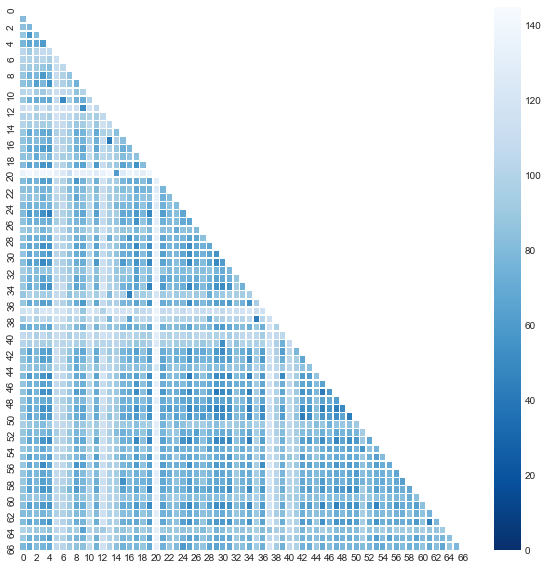


- Mean variance in prototype selection:  82.74404098908443

- Final number of prototypes:  67

# Finished in 1.7070 secs


+ ------------   64    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 1029, 518, 12, 14, 1038, 1040, 1045, 22, 1047, 1051, 28, 31, 1055, 1057, 549, 1064, 

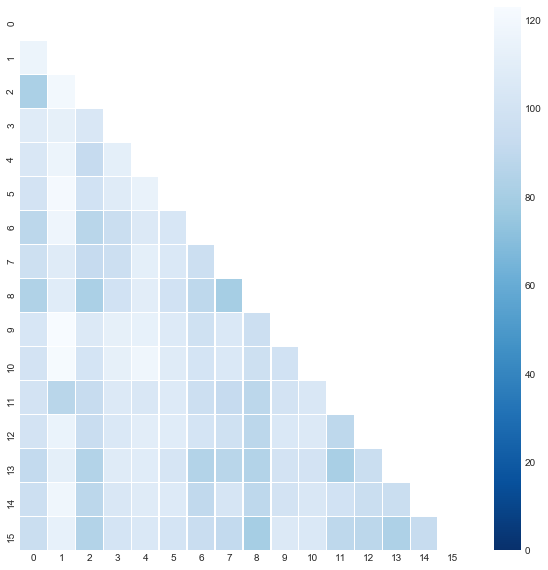


- Mean variance in prototype selection:  94.109375

- Final number of prototypes:  16

# Finished in 1.1069 secs


+ ------------   65    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 1029, 518, 8, 1033, 12, 14, 1038, 1040, 532, 1045, 22, 1047, 1051, 28, 1055, 31, 105


50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 902, 519, 394, 1294, 277, 1177, 1051, 158, 802, 1201, 575, 584, 73, 588, 972, 847, 985, 101, 615, 489, 1263, 1010, 1269, 1273, 122, 1279}
Final:
[1, 4, 1029, 1286, 1033, 265, 11, 778, 1037, 267, 1290, 1292, 785, 532, 1045, 1047, 1055, 1057, 1059, 549, 806, 296, 1071, 49, 820, 53, 1078, 56, 568, 1084, 1088, 6

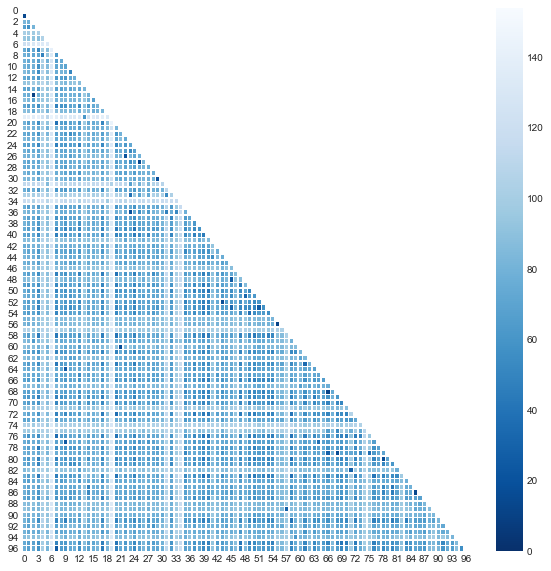


- Mean variance in prototype selection:  80.12116059092358

- Final number of prototypes:  97

# Finished in 2.0549 secs


+ ------------   67    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 4, 902, 519, 136, 394, 1294, 277, 406, 1047, 1177, 1051, 158, 802, 1201, 438, 56, 575, 1088, 584, 73, 588, 77, 972, 847, 985, 475, 1244, 101, 615, 1255, 489, 1263, 1010, 1269, 1142, 1273, 122, 1279}
Final:
[1, 1029, 1033, 11, 1037, 532, 1045, 1055, 1057, 1059, 549, 1071, 49, 53, 1078, 568, 1084, 65, 69, 1099

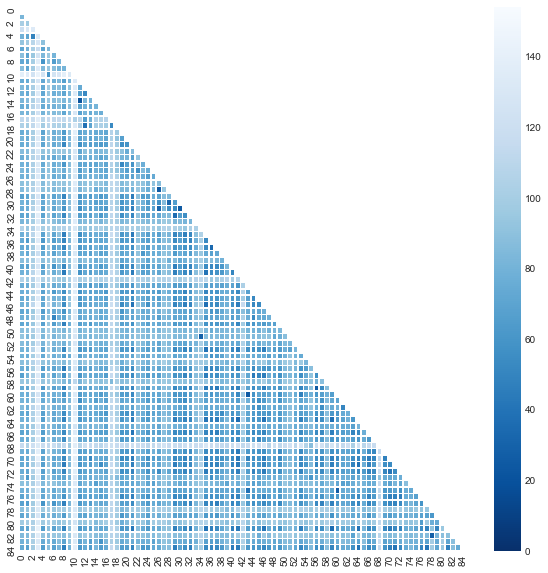


- Mean variance in prototype selection:  80.87640138408304

- Final number of prototypes:  85

# Finished in 1.8354 secs


+ ------------   68    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 4, 902, 519, 136, 394, 267, 778, 1294, 277, 406, 1047, 1177, 1051, 158, 802, 806, 428, 684, 1201, 438, 1078, 56, 575, 1088, 69, 584, 73, 588, 77, 972, 847, 985, 475, 1244, 478, 1248, 101, 615, 1255, 105, 489, 1260, 1263, 1265, 114, 1010, 1269, 1142, 119, 1273, 122, 638, 1279}
Final:
[1, 130, 1029, 1286, 1033

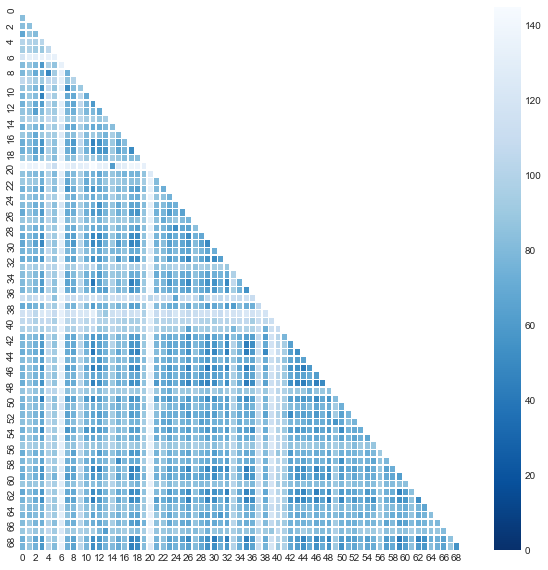


- Mean variance in prototype selection:  81.83387755102041

- Final number of prototypes:  70

# Finished in 1.6382 secs


+ ------------   69    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{4, 1029, 519, 1037, 1045, 1047, 1051, 1055, 1057, 549, 1071, 53, 1078, 56, 568, 1084, 575, 1088, 65, 69, 584, 73, 1099, 588, 77, 593, 82, 89, 1115, 606, 97, 101, 615, 105, 619, 114, 1142, 119, 122, 638, 136, 1168, 1177, 158, 674, 684, 1201, 178, 698, 190, 209, 1238, 1244, 1246, 1248, 739, 1251, 1255, 232, 1260, 12

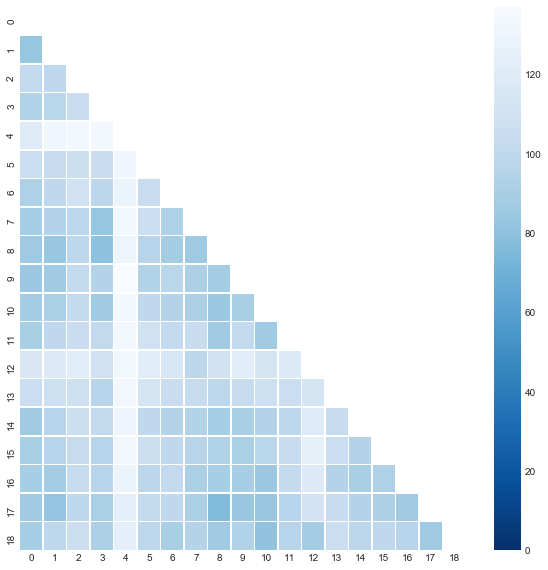


- Mean variance in prototype selection:  95.93351800554017

- Final number of prototypes:  19

# Finished in 1.0308 secs


+ ------------   70    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{4, 1029, 519, 1033, 1037, 532, 1045, 1047, 1051, 1055, 1057, 1059, 549, 1071, 49, 53, 1078, 56, 568, 1084, 575, 1088, 65, 69, 584, 73, 1099, 588, 77, 593, 82, 598, 89, 1115, 606, 97, 1121, 101, 615, 105, 619, 114, 1142, 119, 122, 638, 130, 136, 1165, 1168, 1177, 158, 674, 684, 1201, 178, 180, 698, 190, 713, 209, 1


100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 1136, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069 1136  499   52  312  249  700
  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and

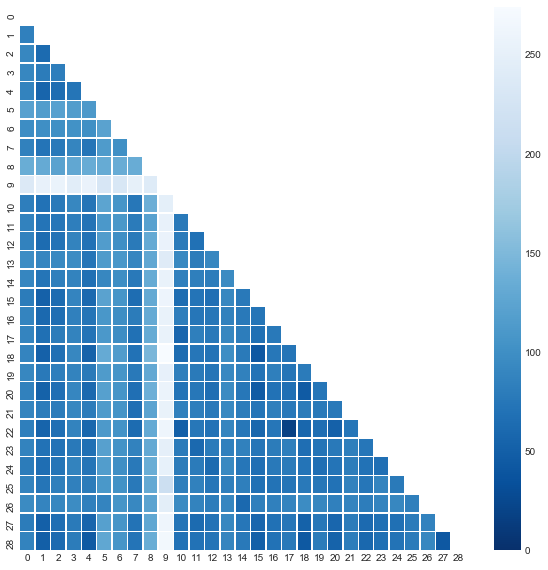


- Mean variance in prototype selection:  92.48038049940547

- Final number of prototypes:  29

# Finished in 1.0023 secs


+ ------------   72    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

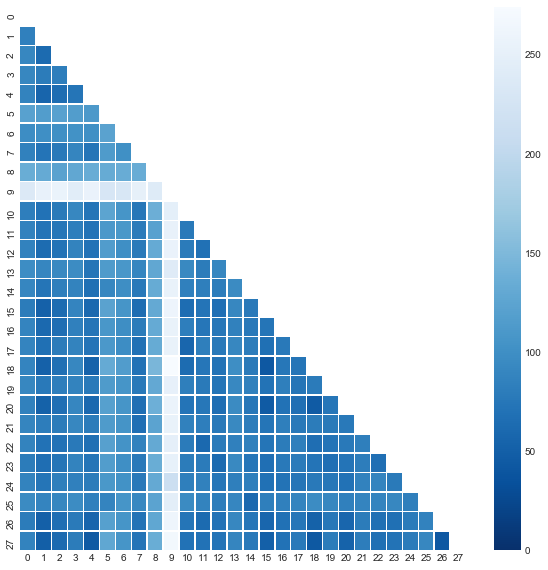


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0559 secs


+ ------------   73    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

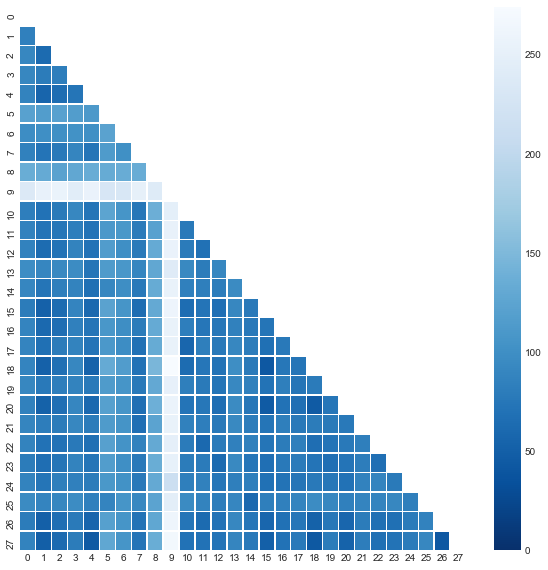


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0496 secs


+ ------------   74    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{353, 961, 453, 1112, 1290, 588, 1166, 399, 1136, 209, 499, 916, 1239, 728, 1182, 700, 766, 607}
Final:
[1281, 4, 133, 328, 1034, 12, 397, 1069, 530, 52, 312, 249]

- Prototypes selected
[1281    4  133  328 1034   12  397 1069  530   52  312  249]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
1034  ->  kearns m j a bound on

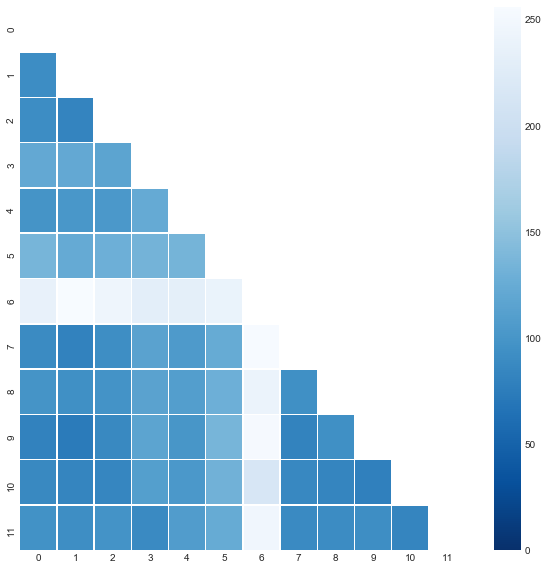


- Mean variance in prototype selection:  114.56944444444444

- Final number of prototypes:  12

# Finished in 0.5964 secs


+ ------------   75    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1281, 133, 1290, 1034, 1166, 399, 530, 916, 1182, 1069, 52, 312, 700, 961, 453, 328, 588, 209, 1239, 728, 1112, 607, 353, 1136, 499, 249, 766}
Final:
[4, 12, 397]

- Prototypes selected
[  4  12 397]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract appears in the proceedings of the second european conference on computational learning theory barcelon

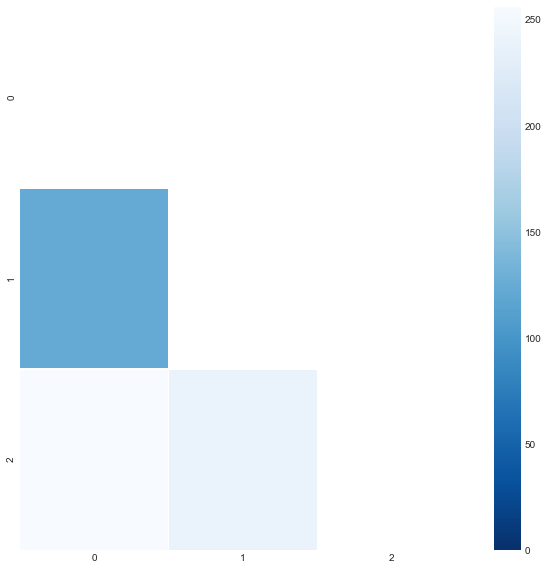


- Mean variance in prototype selection:  137.33333333333334

- Final number of prototypes:  3

# Finished in 0.4397 secs


+ ------------   76    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


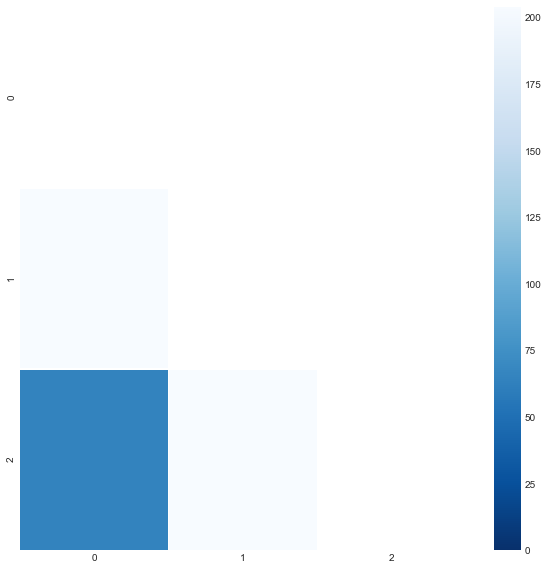


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4473 secs


+ ------------   77    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


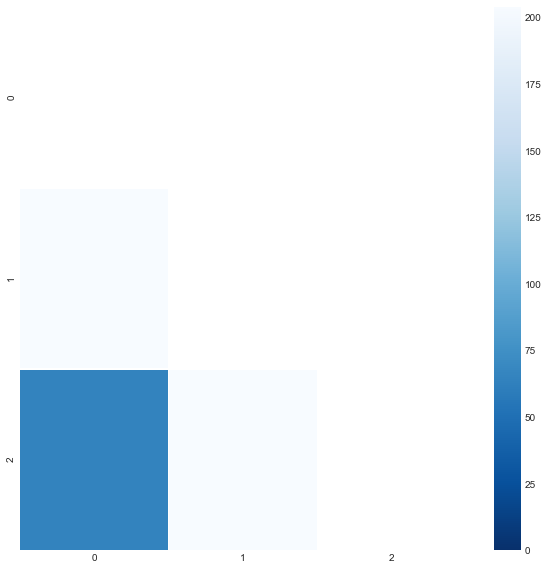


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4629 secs


+ ------------   78    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


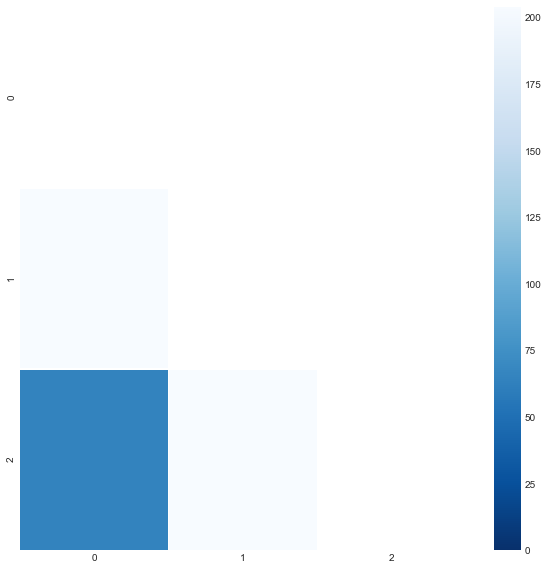


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5176 secs


+ ------------   79    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1591 secs


+ ------------   80    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTA


150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1330 secs


+ ------------   81    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAH


25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{256, 512, 896, 1155, 389, 518, 394, 778, 14, 1294, 1040, 401, 914, 1172, 277, 151, 155, 1

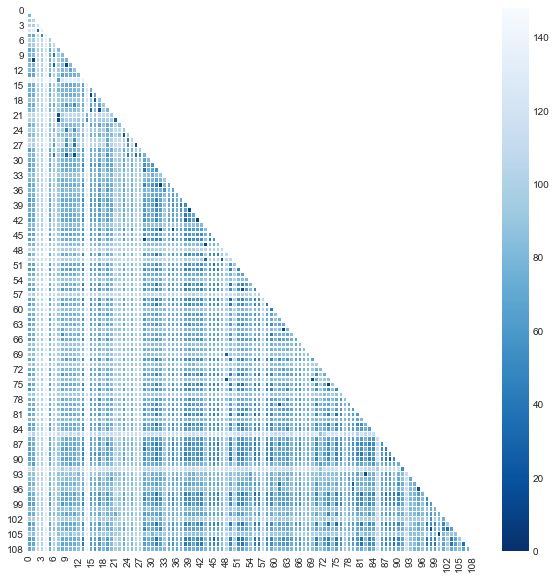


- Mean variance in prototype selection:  81.44701624442386

- Final number of prototypes:  109

# Finished in 1.9688 secs


+ ------------   82    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 518, 14, 1040, 1047, 1051, 28, 31, 1071, 51, 567, 570, 60, 572, 576, 1088, 70, 584, 

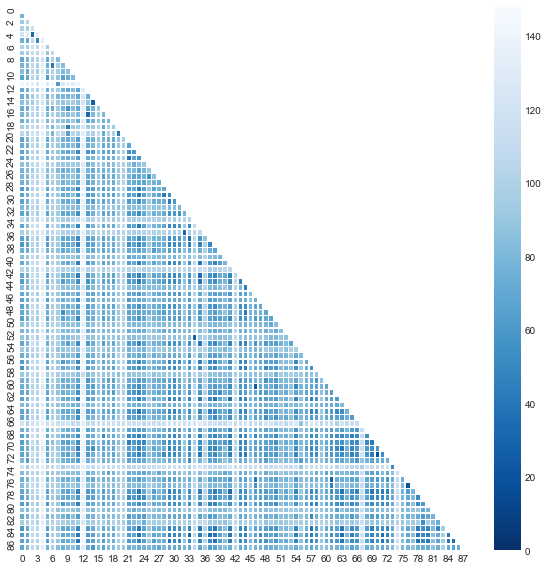


- Mean variance in prototype selection:  81.43724173553719

- Final number of prototypes:  88

# Finished in 1.7475 secs


+ ------------   83    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 518, 12, 14, 1040, 1047, 1051, 28, 31, 1071, 51, 563, 567, 1079, 570, 60, 572, 576, 

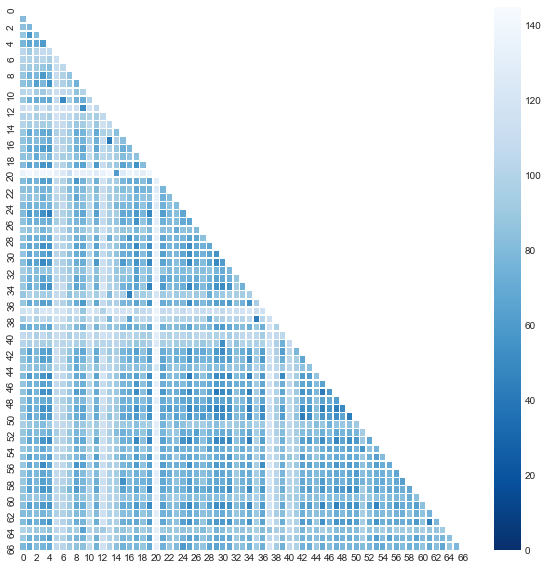


- Mean variance in prototype selection:  82.74404098908443

- Final number of prototypes:  67

# Finished in 1.4867 secs


+ ------------   84    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 1029, 518, 12, 14, 1038, 1040, 1045, 22, 1047, 1051, 28, 31, 1055, 1057, 549, 1064, 

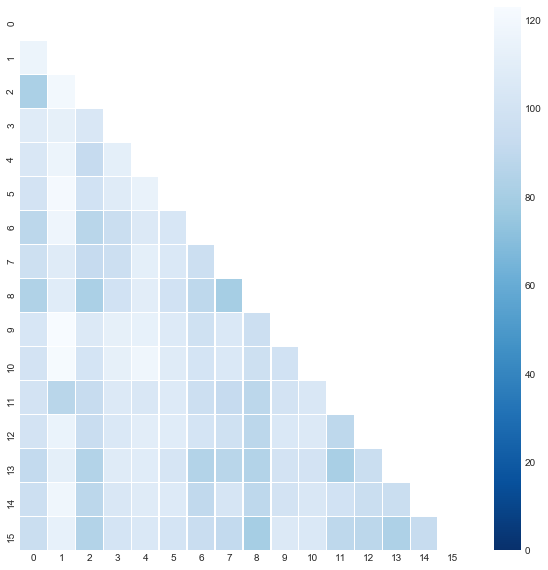


- Mean variance in prototype selection:  94.109375

- Final number of prototypes:  16

# Finished in 1.0383 secs


+ ------------   85    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 28, 31, 51, 53, 60, 64, 68, 70, 73, 77, 82, 89, 97, 107, 112, 114, 116, 124, 130, 140, 151, 153, 155, 162, 168, 173, 178, 180, 190, 209, 232, 238, 242, 256, 265, 267, 277, 296, 320, 323, 326, 328, 332, 337, 341, 350, 378, 389, 394, 401, 410, 424, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 518, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 606, 611, 615, 619, 624, 626, 630, 647, 682, 687, 706, 711, 713, 734, 741, 750, 756, 763, 773, 778, 794, 806, 820, 845, 858, 860, 875, 888, 896, 907, 909, 914, 951, 967, 973, 985, 1006, 1016, 1020, 1029, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1071, 1079, 1084, 1088, 1099, 1109, 1114, 1117, 1119, 1136, 1155, 1158, 1161, 1165, 1170, 1172, 1185, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1254, 1258, 1263, 1265, 1269, 1275, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 1029, 518, 8, 1033, 12, 14, 1038, 1040, 532, 1045, 22, 1047, 1051, 28, 1055, 31, 105


50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 902, 519, 394, 1294, 277, 1177, 1051, 158, 802, 1201, 575, 584, 73, 588, 972, 847, 985, 101, 615, 489, 1263, 1010, 1269, 1273, 122, 1279}
Final:
[1, 4, 1029, 1286, 1033, 265, 11, 778, 1037, 267, 1290, 1292, 785, 532, 1045, 1047, 1055, 1057, 1059, 549, 806, 296, 1071, 49, 820, 53, 1078, 56, 568, 1084, 1088, 6

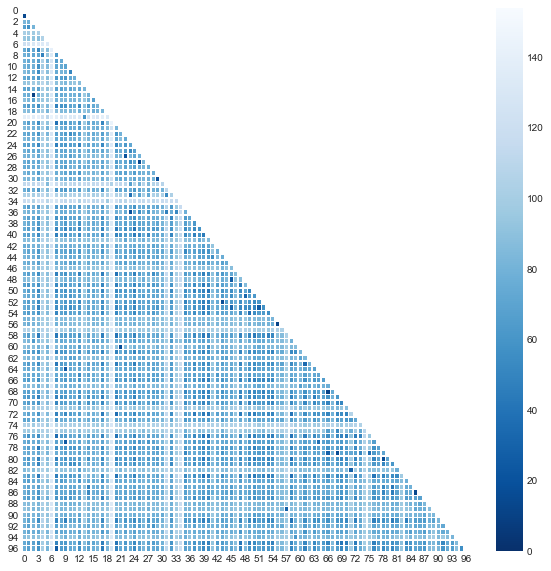


- Mean variance in prototype selection:  80.12116059092358

- Final number of prototypes:  97

# Finished in 1.7333 secs


+ ------------   87    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 4, 902, 519, 136, 394, 1294, 277, 406, 1047, 1177, 1051, 158, 802, 1201, 438, 56, 575, 1088, 584, 73, 588, 77, 972, 847, 985, 475, 1244, 101, 615, 1255, 489, 1263, 1010, 1269, 1142, 1273, 122, 1279}
Final:
[1, 1029, 1033, 11, 1037, 532, 1045, 1055, 1057, 1059, 549, 1071, 49, 53, 1078, 568, 1084, 65, 69, 1099

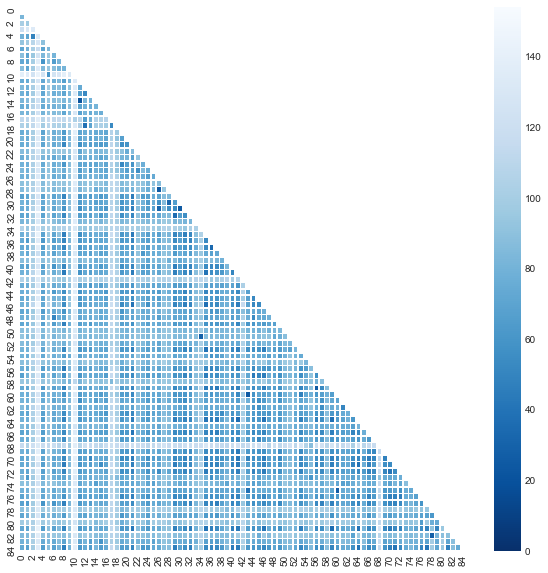


- Mean variance in prototype selection:  80.87640138408304

- Final number of prototypes:  85

# Finished in 1.6929 secs


+ ------------   88    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{1282, 4, 902, 519, 136, 394, 267, 778, 1294, 277, 406, 1047, 1177, 1051, 158, 802, 806, 428, 684, 1201, 438, 1078, 56, 575, 1088, 69, 584, 73, 588, 77, 972, 847, 985, 475, 1244, 478, 1248, 101, 615, 1255, 105, 489, 1260, 1263, 1265, 114, 1010, 1269, 1142, 119, 1273, 122, 638, 1279}
Final:
[1, 130, 1029, 1286, 1033

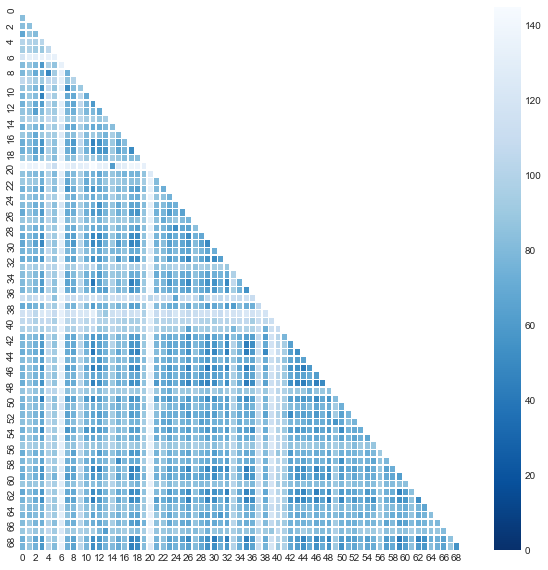


- Mean variance in prototype selection:  81.83387755102041

- Final number of prototypes:  70

# Finished in 1.6022 secs


+ ------------   89    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{4, 1029, 519, 1037, 1045, 1047, 1051, 1055, 1057, 549, 1071, 53, 1078, 56, 568, 1084, 575, 1088, 65, 69, 584, 73, 1099, 588, 77, 593, 82, 89, 1115, 606, 97, 101, 615, 105, 619, 114, 1142, 119, 122, 638, 136, 1168, 1177, 158, 674, 684, 1201, 178, 698, 190, 209, 1238, 1244, 1246, 1248, 739, 1251, 1255, 232, 1260, 12

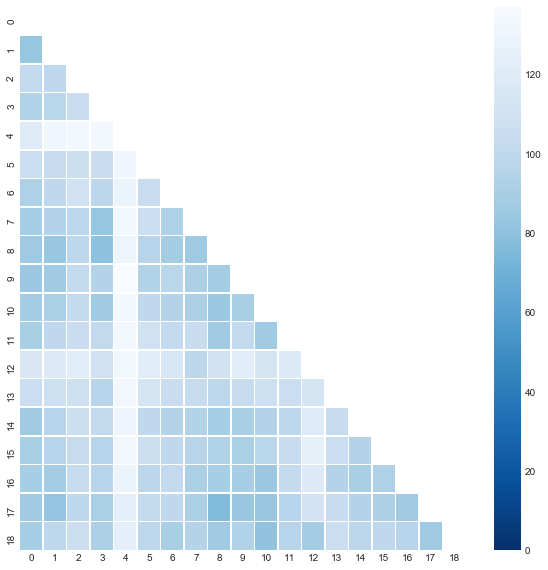


- Mean variance in prototype selection:  95.93351800554017

- Final number of prototypes:  19

# Finished in 0.9272 secs


+ ------------   90    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[1, 4, 11, 49, 53, 56, 65, 69, 73, 77, 82, 89, 97, 101, 105, 114, 119, 122, 130, 136, 158, 178, 180, 190, 209, 232, 238, 249, 265, 267, 277, 296, 320, 328, 331, 339, 365, 394, 406, 424, 428, 435, 438, 443, 452, 458, 462, 475, 478, 489, 498, 519, 532, 549, 568, 575, 584, 588, 593, 598, 606, 615, 619, 638, 674, 684, 698, 713, 739, 756, 767, 778, 785, 802, 806, 820, 847, 866, 902, 914, 951, 972, 985, 1010, 1019, 1029, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1059, 1071, 1078, 1084, 1088, 1099, 1115, 1121, 1142, 1165, 1168, 1177, 1201, 1238, 1244, 1246, 1248, 1251, 1255, 1258, 1260, 1263, 1265, 1269, 1273, 1279, 1282, 1286, 1290, 1292, 1294]
Not wanted:
{4, 1029, 519, 1033, 1037, 532, 1045, 1047, 1051, 1055, 1057, 1059, 549, 1071, 49, 53, 1078, 56, 568, 1084, 575, 1088, 65, 69, 584, 73, 1099, 588, 77, 593, 82, 598, 89, 1115, 606, 97, 1121, 101, 615, 105, 619, 114, 1142, 119, 122, 638, 130, 136, 1165, 1168, 1177, 158, 674, 684, 1201, 178, 180, 698, 190, 713, 209, 1


100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 1136, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069 1136  499   52  312  249  700
  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and

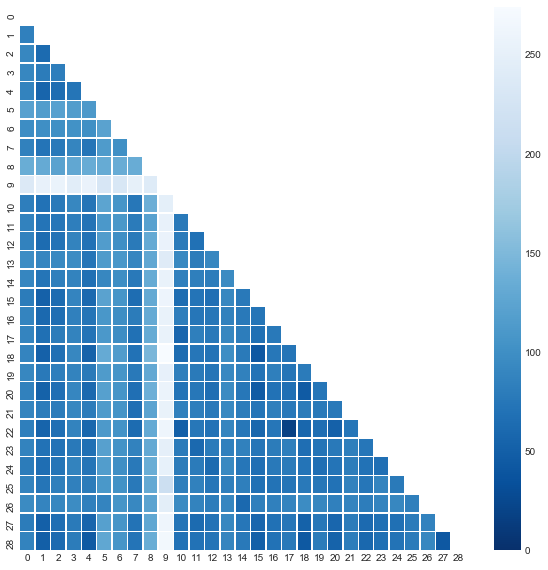


- Mean variance in prototype selection:  92.48038049940547

- Final number of prototypes:  29

# Finished in 1.1659 secs


+ ------------   92    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

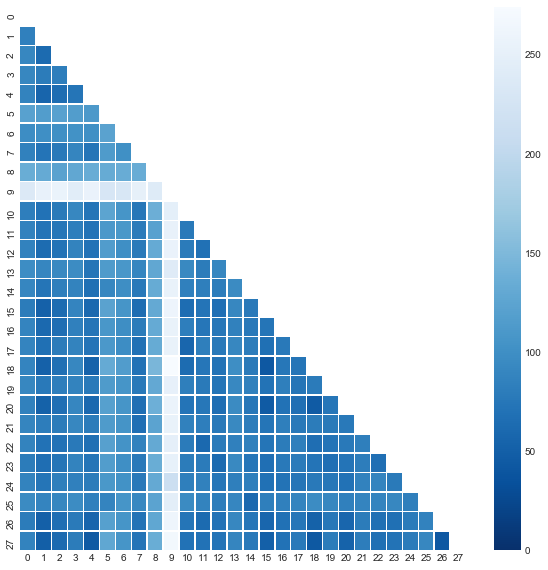


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0560 secs


+ ------------   93    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1136, 399}
Final:
[1281, 961, 4, 133, 453, 328, 1034, 1290, 12, 397, 1166, 588, 209, 530, 916, 1239, 728, 1112, 1182, 607, 353, 1069, 499, 52, 312, 249, 700, 766]

- Prototypes selected
[1281  961    4  133  453  328 1034 1290   12  397 1166  588  209  530
  916 1239  728 1112 1182  607  353 1069  499   52  312  249  700  766]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
961  ->  m kearns and u vazirani an introduction to computational learning theory
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
453  ->  s a goldman m j kearns and r e s

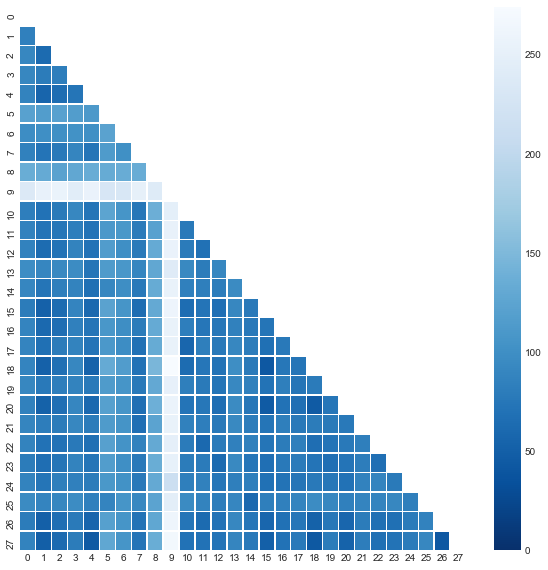


- Mean variance in prototype selection:  93.58163265306122

- Final number of prototypes:  28

# Finished in 1.0546 secs


+ ------------   94    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{353, 961, 453, 1112, 1290, 588, 1166, 399, 1136, 209, 499, 916, 1239, 728, 1182, 700, 766, 607}
Final:
[1281, 4, 133, 328, 1034, 12, 397, 1069, 530, 52, 312, 249]

- Prototypes selected
[1281    4  133  328 1034   12  397 1069  530   52  312  249]
1281  ->  r schapire y freund p bartlett and w lee boosting the margin a new explanation for the effectiveness of voting methods
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
133  ->  a ehrenfeucht d haussler m kearns and l g valiant a general lower bound on the number of examples needed for learning
328  ->  y freund m kearns y mansour d ron r rubinfeld and r e schapire efficient algorithms for learning to play repeated games against computationally bounded adversaries
1034  ->  kearns m j a bound on

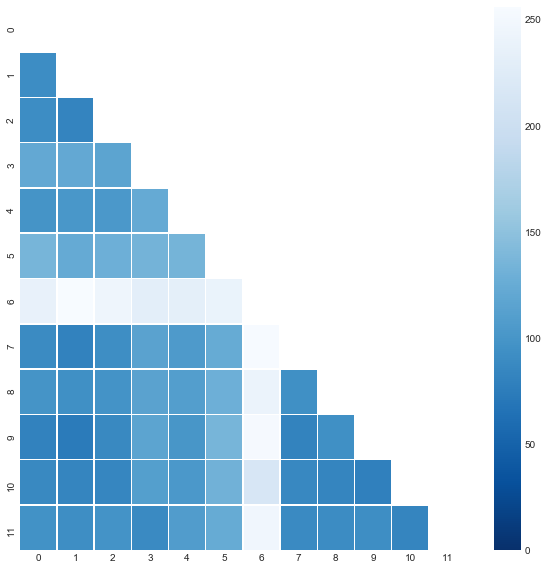


- Mean variance in prototype selection:  114.56944444444444

- Final number of prototypes:  12

# Finished in 0.6254 secs


+ ------------   95    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[4, 12, 52, 133, 209, 249, 312, 328, 353, 397, 399, 453, 499, 530, 588, 607, 700, 728, 766, 916, 961, 1034, 1069, 1112, 1136, 1166, 1182, 1239, 1281, 1290]
Not wanted:
{1281, 133, 1290, 1034, 1166, 399, 530, 916, 1182, 1069, 52, 312, 700, 961, 453, 328, 588, 209, 1239, 728, 1112, 607, 353, 1136, 499, 249, 766}
Final:
[4, 12, 397]

- Prototypes selected
[  4  12 397]
4  ->  a blum m furst m kearns r lipton cryptographic primitives based on hard learning problems
12  ->  avrim blum merrick furst jeffery jackson michael kearns yishay mansour and steven rudich weakly learning dnf and characterizing statistical query learning using fourier analysis
397  ->  freund y and schapire re a decisiontheoretic generalization of online learning and an application to boosting at web site httpwwwresearchattcomyoav or httpwwwresearchattcomorgsssrpeopleyoav an extended abstract appears in the proceedings of the second european conference on computational learning theory barcelon

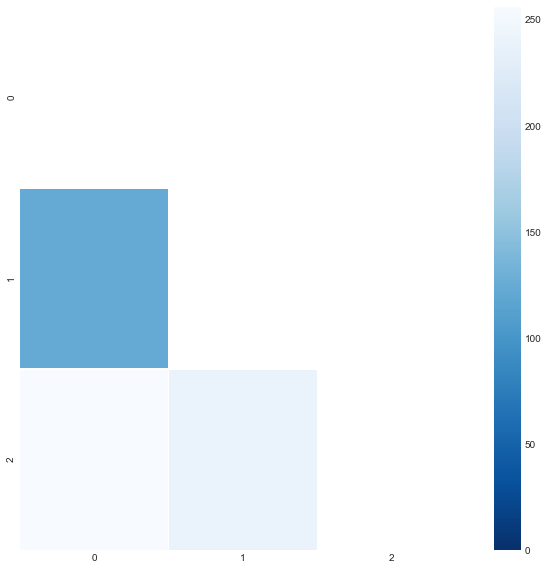


- Mean variance in prototype selection:  137.33333333333334

- Final number of prototypes:  3

# Finished in 0.4480 secs


+ ------------   96    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


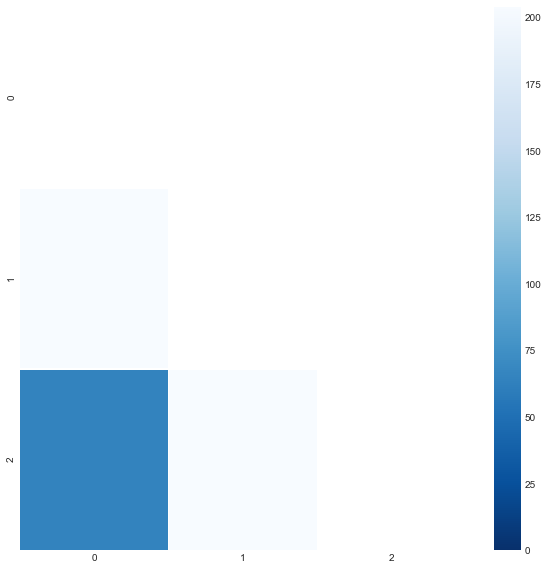


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.4629 secs


+ ------------   97    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


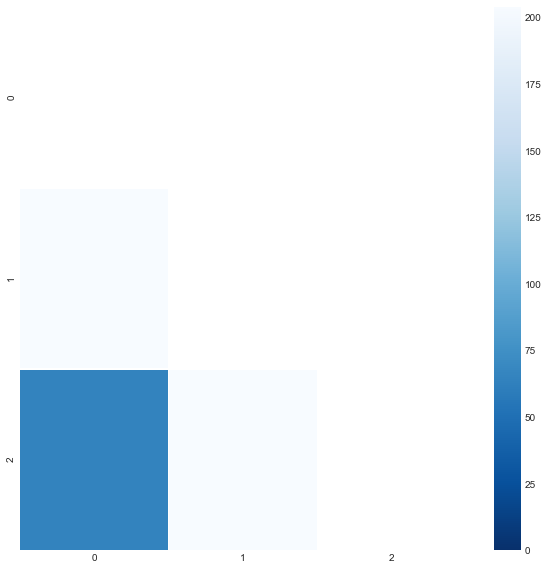


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.6217 secs


+ ------------   98    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
set()
Final:
[115, 398, 1071]

- Prototypes selected
[ 115  398 1071]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory
1071  ->  d lewis r schapire j callan and r papka training algorithms for linear text classifiers


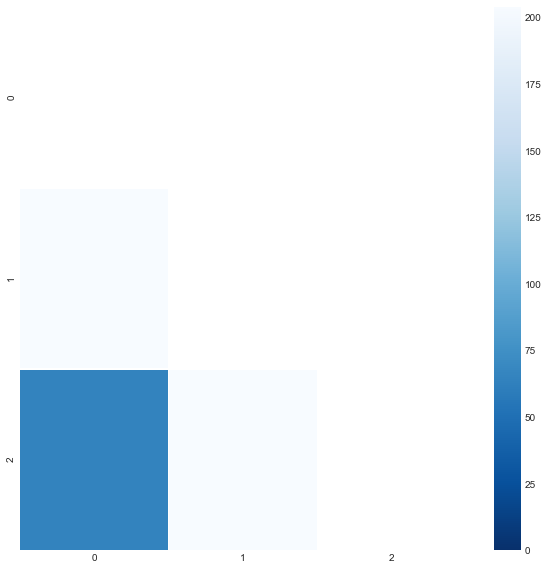


- Mean variance in prototype selection:  105.11111111111111

- Final number of prototypes:  3

# Finished in 0.5110 secs


+ ------------   99    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1190 secs


+ ------------   100    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedW


150.0
Prototypes before:
[115, 398, 1071]
Not wanted:
{1071}
Final:
[115, 398]

- Prototypes selected
[115 398]
115  ->  drucker h r schapire  p improving the performance in neural networks using a boosting algorithm
398  ->  yoav freund and robert e schapire a decisiontheoreticgeneralizationof online learning and an application to boosting unpublishedmanuscript available electronically on our web pages or by email request an extended abstract appeared in computational learning theory

- Final number of prototypes:  2

# Finished in 0.1340 secs





In [53]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [54]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

max_numberOf_clusters max_editDistance prototypesFilterThr numOfPrototypes  \
81                  1000               50                  10             109   
61                   500               50                  10             109   
86                  1000              100                  10              97   
66                   500              100                  10              97   
82                  1000               50                  20              88   
62                   500               50                  20              88   
67                   500              100                  20              85   
87                  1000              100                  20              85   
46                   100              100                  10              76   
88                  1000              100                  40              70   
68                   500              100                  40              70   
47                   100              100                  20              68   
63                   500               50                  40              67   
83                  1000               50                  40              67   
48                   100              100                  40              57   
41                   100               50                  10              53   
42                   100               50                  20              44   
26                    50              100                  10              41   
27                    50              100                  20              35   
43                   100               50                  40              35   

   protSelectionVariance  
81                81.447  
61                81.447  
86               80.1212  
66               80.1212  
82               81.4372  
62               81.4372  
67               80.8764  
87               80.8764  
46               80.8127  
88               81.8339  
68               81.8339  
47               81.2703  
63                82.744  
83                82.744  
48               82.3127  
41               85.4147  
42               85.0176  
26               80.6841  
27               81.5184  
43               84.2302

In [40]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

max_numberOf_clusters max_editDistance prototypesFilterThr  \
50                    100              100                 100   
70                    500              100                 100   
90                   1000              100                 100   
65                    500               50                 100   
45                    100               50                 100   
85                   1000               50                 100   
55                    100              200                 100   
95                   1000              200                 100   
35                     50              200                 100   
75                    500              200                 100   
44                    100               50                  70   
100                  1000              300                 100   
20                     10              300                 100   
40                     50              300                 100   
80                    500              300                 100   
60                    100              300                 100   
30                     50              100                 100   
94                   1000              200                  70   
54                    100              200                  70   
34                     50              200                  70   
74                    500              200                  70   
49                    100              100                  70   
19                     10              300                  70   
59                    100              300                  70   
39                     50              300                  70   
99                   1000              300                  70   
79                    500              300                  70   
42                    100               50                  20   
41                    100               50                  10   
38                     50              300                  40   
56                    100              300                  10   
96                   1000              300                  10   
18                     10              300                  40   
97                   1000              300                  20   
57                    100              300                  20   
36                     50              300                  10   
37                     50              300                  20   
58                    100              300                  40   
76                    500              300                  10   
77                    500              300                  20   
78                    500              300                  40   
16                     10              300                  10   
17                     10              300                  20   
98                   1000              300                  40   
64                    500               50                  70   
84                   1000               50                  70   
43                    100               50                  40   
29                     50              100                  70   
89                   1000              100                  70   
69                    500              100                  70   

    numOfPrototypes protSelectionVariance  
50                9               202.469  
70                9               202.469  
90                9               202.469  
65                8               201.344  
45                8               201.344  
85                8               201.344  
55                9               201.111  
95                9               201.111  
35                9               201.111  
75                9               201.111  
44               18               177.772  
100               3               176.667  
20                3               176.667  
40                3  

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179]
Not wanted:
{97, 11, 172, 48, 179, 89, 125}
Final:
[82, 3]

- Prototypes selected
[82  3]
82  ->  w w cohen r e shapire and y singer learning to order things
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0660 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

######################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179]
Not wanted:
{97, 11, 172, 48, 179, 89, 125}
Final:
[82, 3]

- Prototypes selected
[82  3]
82  ->  w w cohen r e shapire and y singer learning to order things
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0700 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

######################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179]
Not wanted:
{97, 11, 172, 48, 82, 179, 89, 125}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.0470 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase  


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179]
Not wanted:
{97, 11, 172, 48, 82, 179, 89, 125}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.0545 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase  


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179]
Not wanted:
{97, 11, 172, 48, 82, 179, 89, 125}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.0579 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase  


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832]
Not wanted:
{832, 609, 582, 524, 152, 93, 638, 767}
Final:
[345, 46]

- Prototypes selected
[345  46]
345  ->  freund y  re schapire 1996 experiments with a new boosting algo rithm
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  2

# Finished in 0.0982 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

######


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832]
Not wanted:
{832, 609, 582, 524, 152, 345, 93, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1640 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection pha


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832]
Not wanted:
{832, 609, 582, 524, 152, 345, 93, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0909 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection pha


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832]
Not wanted:
{832, 609, 582, 524, 152, 345, 93, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0879 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection ph


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832]
Not wanted:
{832, 609, 582, 524, 152, 345, 93, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0880 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection ph


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024]
Not wanted:
{1024, 932, 839, 619, 976, 598, 729, 958}
Final:
[880, 250]

- Prototypes selected
[880 250]
880  ->  m kearns efficient noisetolerant learning from statistical queries
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  2

# Finished in 0.0879 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
################################################


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024]
Not wanted:
{1024, 932, 839, 619, 976, 880, 598, 729, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0710 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########################################################


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024]
Not wanted:
{1024, 932, 839, 619, 880, 976, 598, 729, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0779 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########################################################


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024]
Not wanted:
{1024, 932, 839, 619, 880, 976, 598, 729, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0771 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########################################################


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024]
Not wanted:
{1024, 932, 839, 619, 880, 976, 598, 729, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0779 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0969 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0960 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0829 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0979 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0949 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644]
Not wanted:
{644, 266, 11, 638, 394, 398, 402, 277, 534, 415, 549, 424, 172, 302, 430, 48, 561, 434, 179, 438, 443, 575, 320, 452, 197, 326, 458, 586, 205, 334, 466, 212, 89, 602, 475, 97, 225, 484, 357, 614, 377, 619, 371, 249, 125, 510}
Final:
[82, 3]

- Prototypes selected
[82  3]
82  ->  w w cohen r e shapire and y singer learning to order things
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0869 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding: 


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644]
Not wanted:
{644, 266, 11, 394, 638, 398, 402, 277, 534, 415, 549, 424, 172, 302, 430, 48, 561, 434, 179, 438, 443, 575, 320, 452, 197, 326, 458, 586, 205, 334, 466, 212, 89, 602, 475, 97, 225, 484, 357, 614, 377, 619, 371, 249, 125, 510}
Final:
[82, 3]

- Prototypes selected
[82  3]
82  ->  w w cohen r e shapire and y singer learning to order things
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  2

# Finished in 0.0890 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding: 


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644]
Not wanted:
{644, 266, 11, 394, 638, 398, 402, 277, 534, 415, 549, 424, 172, 302, 430, 48, 561, 434, 179, 438, 443, 575, 320, 452, 197, 326, 458, 586, 205, 334, 82, 466, 212, 89, 602, 475, 97, 225, 484, 357, 614, 377, 619, 371, 249, 125, 510}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.0876 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644]
Not wanted:
{644, 266, 11, 394, 638, 398, 402, 277, 534, 415, 549, 424, 172, 302, 430, 48, 561, 434, 179, 438, 443, 575, 320, 452, 197, 326, 458, 586, 205, 334, 82, 466, 212, 89, 602, 475, 97, 225, 484, 357, 614, 377, 619, 371, 249, 125, 510}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.1349 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644]
Not wanted:
{644, 266, 11, 394, 638, 398, 402, 277, 534, 415, 549, 424, 172, 302, 430, 48, 561, 434, 179, 438, 443, 575, 320, 452, 197, 326, 458, 586, 205, 334, 82, 466, 212, 89, 602, 475, 97, 225, 484, 357, 614, 377, 619, 371, 249, 125, 510}
Final:
[3]

- Prototypes selected
[3]
3  ->  avrim blum merrick furst michael kearns and richard j lipton cryptographic primitives based on hard learning problems

- Final number of prototypes:  1

# Finished in 0.0900 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 1245, 93, 609, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[345, 1122, 46, 879]

- Prototypes selected
[ 345 1122   46  879]
345  ->  freund y  re schapire 1996 experiments with a new boosting algo rithm
1122  ->  r rivest and r schapire inference of finite automata using homing sequences
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries


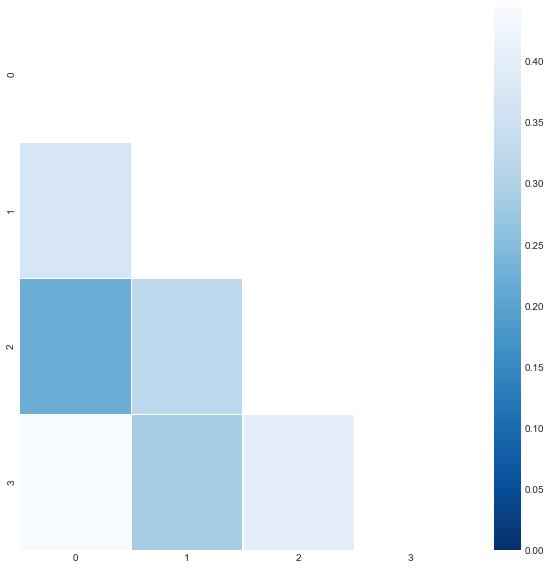


- Mean variance in prototype selection:  0.2553439153439153

- Final number of prototypes:  4

# Finished in 0.4730 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[46, 879]

- Prototypes selected
[ 46 879]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries

- Final number of prototypes:  2

# Finished in 0.0869 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

###########


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1079 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0939 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1129 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 598, 729, 1274, 958}
Final:
[880, 250]

- Prototypes selected
[880 250]
880  ->  m kearns efficient noisetolerant learning from statistical queries
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  2

# Finished in 0.1060 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #



0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 880, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0965 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0920 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1060 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0959 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#########


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0999 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0939 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0960 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1005 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1239 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 212, 732, 225, 756, 249, 769, 266, 780, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 357, 877, 371, 888, 377, 896, 394, 398, 402, 917, 415, 424, 430, 945, 434, 438, 443, 452, 968, 458, 466, 980, 475, 484, 1007, 

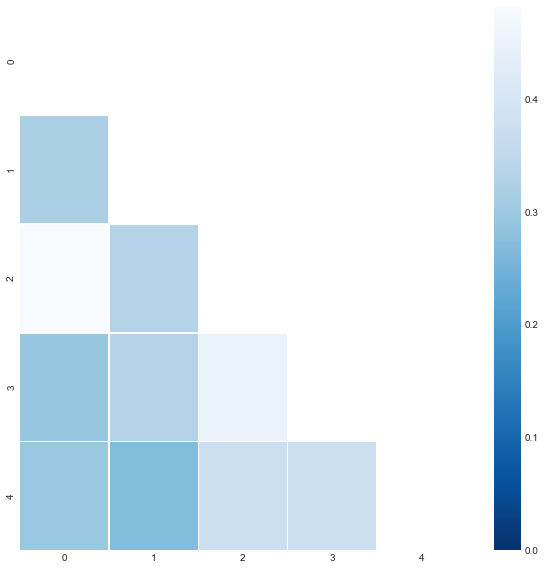


- Mean variance in prototype selection:  0.28250527250527246

- Final number of prototypes:  5

# Finished in 0.5933 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 212, 732, 225, 756, 249, 769, 266, 780, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 858, 357, 877, 371, 888, 377, 896, 394, 398, 402, 917, 415, 424, 430, 945, 434, 438, 443, 452, 968, 458, 466, 980, 475, 


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 212, 732, 225, 756, 249, 769, 266, 780, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 858, 357, 877, 371, 888, 377, 896, 394, 398, 402, 917, 415, 424, 430, 945, 434, 438, 443, 452, 968, 458, 466, 980, 4


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 212, 732, 225, 756, 249, 769, 266, 780, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 858, 357, 877, 371, 888, 377, 896, 394, 398, 402, 917, 415, 424, 430, 945, 434, 438, 443, 452, 968, 458, 466, 980, 4


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 212, 732, 225, 756, 249, 769, 266, 780, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 858, 357, 877, 371, 888, 377, 896, 394, 398, 402, 917, 415, 424, 430, 945, 434, 438, 443, 452, 968, 458, 466, 980, 4


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 1245, 93, 609, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[345, 1122, 46, 879]

- Prototypes selected
[ 345 1122   46  879]
345  ->  freund y  re schapire 1996 experiments with a new boosting algo rithm
1122  ->  r rivest and r schapire inference of finite automata using homing sequences
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries


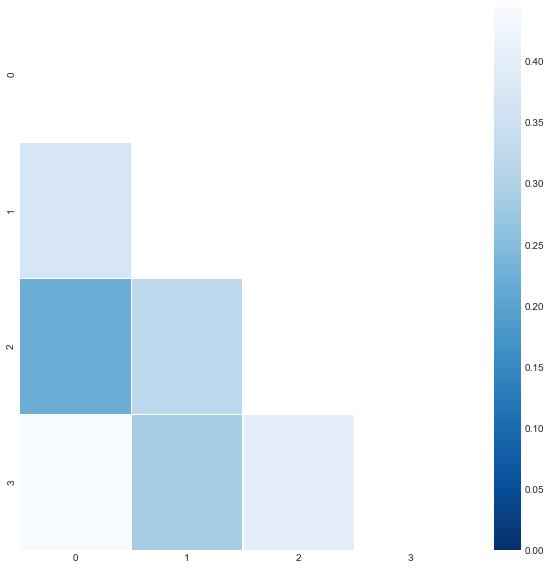


- Mean variance in prototype selection:  0.2553439153439153

- Final number of prototypes:  4

# Finished in 0.5132 secs


+ ------------   47    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[46, 879]

- Prototypes selected
[ 46 879]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries

- Final number of prototypes:  2

# Finished in 0.1229 secs


+ ------------   48    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

##########


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1405 secs


+ ------------   49    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.125 secs


+ ------------   50    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1315 secs


+ ------------   51    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 598, 729, 1274, 958}
Final:
[880, 250]

- Prototypes selected
[880 250]
880  ->  m kearns efficient noisetolerant learning from statistical queries
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  2

# Finished in 0.1270 secs


+ ------------   52    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 880, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1620 secs


+ ------------   53    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1385 secs


+ ------------   54    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1250 secs


+ ------------   55    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.0969 secs


+ ------------   56    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1040 secs


+ ------------   57    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0909 secs


+ ------------   58    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1009 secs


+ ------------   59    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1060 secs


+ ------------   60    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0970 secs


+ ------------   61    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 357, 8

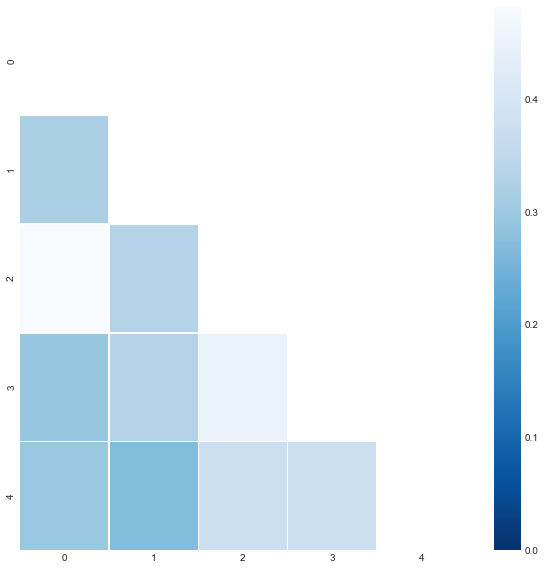


- Mean variance in prototype selection:  0.28250527250527246

- Final number of prototypes:  5

# Finished in 0.7364 secs


+ ------------   62    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 1245, 93, 609, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[345, 1122, 46, 879]

- Prototypes selected
[ 345 1122   46  879]
345  ->  freund y  re schapire 1996 experiments with a new boosting algo rithm
1122  ->  r rivest and r schapire inference of finite automata using homing sequences
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries


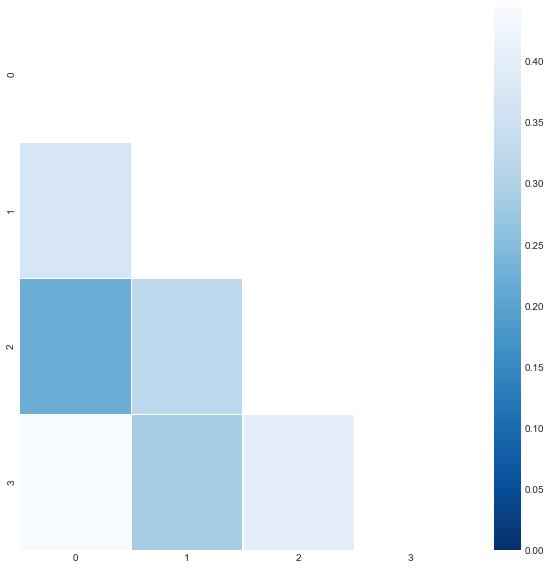


- Mean variance in prototype selection:  0.2553439153439153

- Final number of prototypes:  4

# Finished in 0.6131 secs


+ ------------   67    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[46, 879]

- Prototypes selected
[ 46 879]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries

- Final number of prototypes:  2

# Finished in 0.1316 secs


+ ------------   68    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

##########


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1310 secs


+ ------------   69    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1289 secs


+ ------------   70    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1360 secs


+ ------------   71    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHas


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 598, 729, 1274, 958}
Final:
[880, 250]

- Prototypes selected
[880 250]
880  ->  m kearns efficient noisetolerant learning from statistical queries
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  2

# Finished in 0.1300 secs


+ ------------   72    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 880, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1279 secs


+ ------------   73    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1240 secs


+ ------------   74    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1155 secs


+ ------------   75    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1190 secs


+ ------------   76    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

########


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1506 secs


+ ------------   77    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1265 secs


+ ------------   78    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1340 secs


+ ------------   79    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1560 secs


+ ------------   80    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
################################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1301 secs


+ ------------   81    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###############################################


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 357, 8

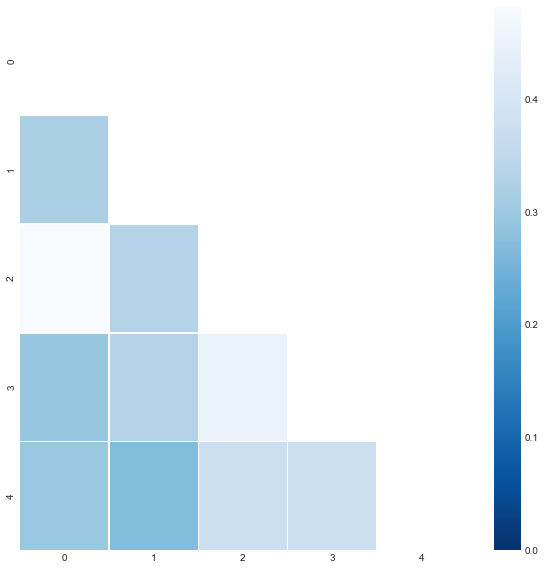


- Mean variance in prototype selection:  0.28250527250527246

- Final number of prototypes:  5

# Finished in 0.6821 secs


+ ------------   82    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.3
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 334, 


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.15
Prototypes before:
[3, 11, 48, 82, 89, 97, 125, 172, 179, 197, 205, 212, 225, 249, 266, 277, 302, 320, 326, 334, 357, 371, 377, 394, 398, 402, 415, 424, 430, 434, 438, 443, 452, 458, 466, 475, 484, 510, 534, 549, 561, 575, 586, 602, 614, 619, 638, 644, 657, 673, 682, 684, 698, 713, 732, 756, 769, 780, 795, 811, 820, 826, 845, 858, 877, 888, 896, 917, 945, 968, 980, 1007, 1016, 1019, 1024, 1039, 1044, 1047, 1053, 1057, 1059, 1064, 1078, 1083, 1088, 1099, 1114, 1121, 1125, 1148, 1161, 1166, 1170, 1184, 1211, 1225, 1234, 1242, 1246, 1251, 1258, 1263, 1266, 1277, 1288, 1294]
Not wanted:
{1024, 11, 1039, 1044, 534, 1047, 1053, 1057, 1059, 549, 1064, 48, 561, 1078, 1083, 575, 1088, 586, 1099, 82, 89, 602, 1114, 97, 1121, 1125, 614, 619, 1148, 125, 638, 644, 1161, 1166, 657, 1170, 1184, 673, 682, 172, 684, 179, 698, 1211, 197, 713, 1225, 205, 1234, 212, 1242, 732, 1246, 225, 1251, 1258, 1263, 1266, 756, 249, 1277, 769, 1288, 266, 780, 1294, 277, 795, 811, 302, 820, 826, 320, 326, 845, 3


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 1245, 93, 609, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[345, 1122, 46, 879]

- Prototypes selected
[ 345 1122   46  879]
345  ->  freund y  re schapire 1996 experiments with a new boosting algo rithm
1122  ->  r rivest and r schapire inference of finite automata using homing sequences
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries


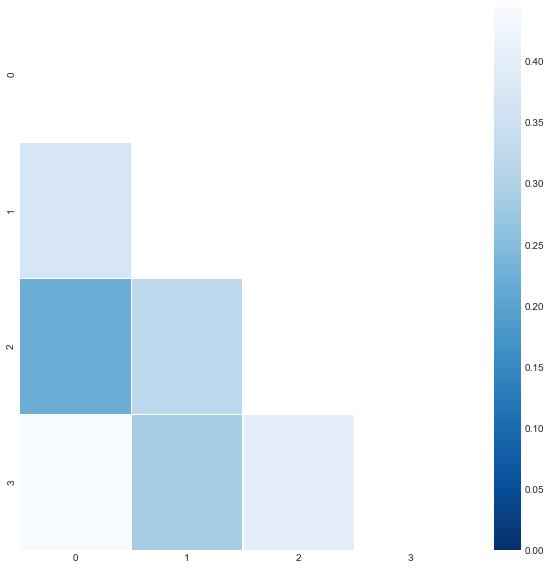


- Mean variance in prototype selection:  0.2553439153439153

- Final number of prototypes:  4

# Finished in 0.5449 secs


+ ------------   87    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 1141, 1016, 1274, 638, 767}
Final:
[46, 879]

- Prototypes selected
[ 46 879]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice
879  ->  m kearns efficient noisetolerant learning from statistical queries

- Final number of prototypes:  2

# Finished in 0.1009 secs


+ ------------   88    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#########


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0965 secs


+ ------------   89    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHa


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.1090 secs


+ ------------   90    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHa


0.3
Prototypes before:
[46, 93, 152, 345, 524, 582, 609, 638, 767, 832, 879, 930, 958, 978, 1016, 1024, 1067, 1083, 1122, 1141, 1170, 1184, 1209, 1240, 1245, 1254, 1262, 1274]
Not wanted:
{1024, 524, 1170, 152, 1184, 930, 1067, 1209, 1083, 958, 832, 582, 978, 1240, 345, 93, 1245, 609, 1122, 1254, 1262, 879, 1141, 1016, 1274, 638, 767}
Final:
[46]

- Prototypes selected
[46]
46  ->  n cesabianchi y freund d p helmbold d haussler r e schapire and m k warmuth how to use expert advice

- Final number of prototypes:  1

# Finished in 0.0889 secs


+ ------------   91    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHa


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 598, 729, 1274, 958}
Final:
[880, 250]

- Prototypes selected
[880 250]
880  ->  m kearns efficient noisetolerant learning from statistical queries
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  2

# Finished in 0.1019 secs


+ ------------   92    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 976, 880, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1090 secs


+ ------------   93    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#######


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1150 secs


+ ------------   94    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#######


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1113 secs


+ ------------   95    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#######


0.35
Prototypes before:
[250, 598, 619, 729, 839, 880, 932, 958, 976, 1024, 1066, 1184, 1217, 1274]
Not wanted:
{1024, 1184, 1217, 932, 839, 1066, 619, 880, 976, 598, 729, 1274, 958}
Final:
[250]

- Prototypes selected
[250]
250  ->  y freund m kearns d ron r rubinfeld r schapire and l sellie efficient learning of typical finite automata from random walks

- Final number of prototypes:  1

# Finished in 0.1354 secs


+ ------------   96    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

#######


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.1237 secs


+ ------------   97    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###############################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0921 secs


+ ------------   98    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.4
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###############################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0887 secs


+ ------------   99    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.7
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###############################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0916 secs


+ ------------   100    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  True
prototypeFilter:  0.8
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
##############################################


0.4
Prototypes before:
[509]
Not wanted:
set()
Final:
[509]

- Prototypes selected
[509]
509  ->  d haussler m kearns n littlestone and m k warmuth equivalence of models for polynomial learnability

- Final number of prototypes:  1

# Finished in 0.0971 secs





In [57]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [58]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

max_numberOf_clusters  max_editDistance  prototypesFilterThr  \
41                   100               0.3                  0.2   
81                  1000               0.3                  0.2   
61                   500               0.3                  0.2   
26                    50               0.6                  0.2   
86                  1000               0.6                  0.2   
46                   100               0.6                  0.2   
66                   500               0.6                  0.2   
2                     10               0.3                  0.3   
27                    50               0.6                  0.3   
31                    50               0.7                  0.2   
42                   100               0.3                  0.3   
47                   100               0.6                  0.3   
1                     10               0.3                  0.2   
22                    50               0.3                  0.3   
67                   500               0.6                  0.3   
71                   500               0.7                  0.2   
82                  1000               0.3                  0.3   
87                  1000               0.6                  0.3   
91                  1000               0.7                  0.2   
62                   500               0.3                  0.3   

   numOfPrototypes protSelectionVariance  
41               5              0.282505  
81               5              0.282505  
61               5              0.282505  
26               4              0.255344  
86               4              0.255344  
46               4              0.255344  
66               4              0.255344  
2                2                  None  
27               2                  None  
31               2                  None  
42               2                  None  
47               2                  None  
1                2                  None  
22               2                  None  
67               2                  None  
71               2                  None  
82               2                  None  
87               2                  None  
91               2                  None  
62               2                  None

In [60]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=True).head(50)

max_numberOf_clusters  max_editDistance  prototypesFilterThr  \
26                    50               0.6                  0.2   
46                   100               0.6                  0.2   
66                   500               0.6                  0.2   
86                  1000               0.6                  0.2   
41                   100               0.3                  0.2   
61                   500               0.3                  0.2   
81                  1000               0.3                  0.2   
1                     10               0.3                  0.2   
2                     10               0.3                  0.3   
3                     10               0.3                  0.4   
4                     10               0.3                  0.7   
5                     10               0.3                  0.8   
6                     10               0.6                  0.2   
7                     10               0.6                  0.3   
8                     10               0.6                  0.4   
9                     10               0.6                  0.7   
10                    10               0.6                  0.8   
11                    10               0.7                  0.2   
12                    10               0.7                  0.3   
13                    10               0.7                  0.4   
14                    10               0.7                  0.7   
15                    10               0.7                  0.8   
16                    10               0.8                  0.2   
17                    10               0.8                  0.3   
18                    10               0.8                  0.4   
19                    10               0.8                  0.7   
20                    10               0.8                  0.8   
21                    50               0.3                  0.2   
22                    50               0.3                  0.3   
23                    50               0.3                  0.4   
24                    50               0.3                  0.7   
25                    50               0.3                  0.8   
27                    50               0.6                  0.3   
28                    50               0.6                  0.4   
29                    50               0.6                  0.7   
30                    50               0.6                  0.8   
31                    50               0.7                  0.2   
32                    50               0.7                  0.3   
33                    50               0.7                  0.4   
34                    50               0.7                  0.7   
35                    50               0.7                  0.8   
36                    50               0.8                  0.2   
37                    50               0.8                  0.3   
38                    50               0.8                  0.4   
39                    50               0.8                  0.7   
40                    50               0.8                  0.8   
42                   100               0.3                  0.3   
43                   100               0.3                  0.4   
44                   100               0.3                  0.7   
45                   100               0.3                  0.8   

   numOfPrototypes protSelectionVariance  
26               4              0.255344  
46               4              0.255344  
66               4              0.255344  
86               4              0.255344  
41               5              0.282505  
61               5              0.282505  
81               5              0.282505  
1                2                  None  
2                2                  None  
3                1                  None  
4                1                  None  
5                1                  None  
6                2        

##### Remarks

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### [ii] Fine tunning  __Embedding phase__

At the end, when the model will be fine tunned alltogether

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Model final fine tunning


##### Edit distance

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


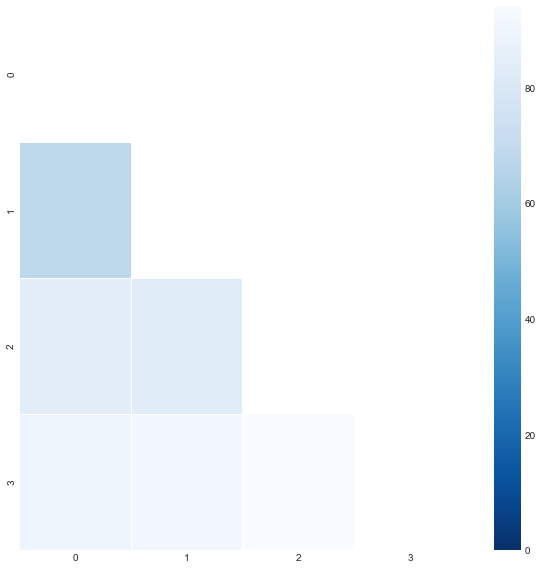


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.5147 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


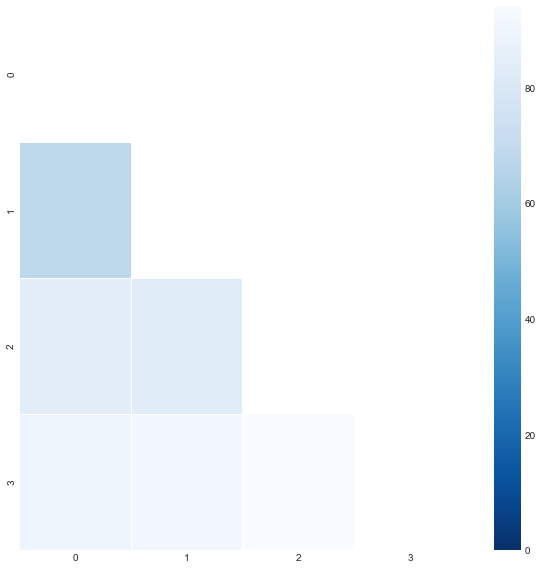


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.6833 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


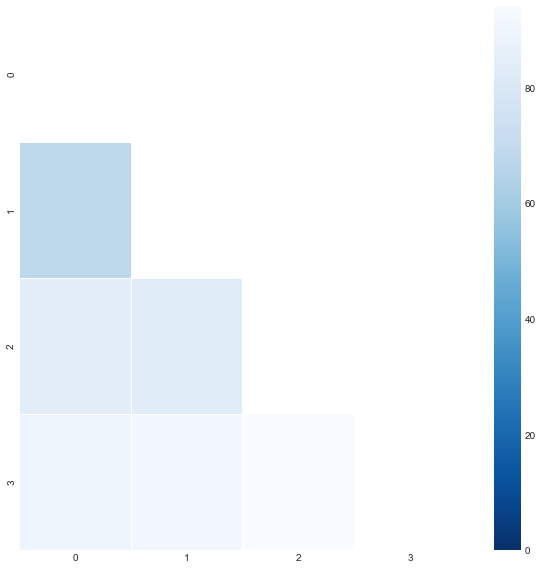


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.1947 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{21}
Final:
[17, 3, 13]

- Prototypes selected
[17  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


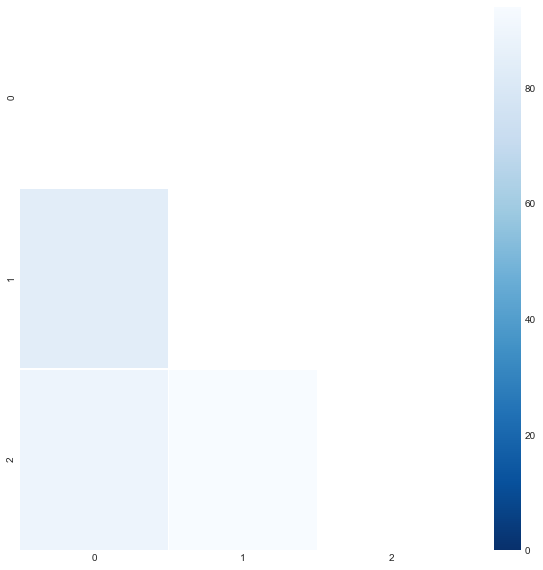


- Mean variance in prototype selection:  59.333333333333336

- Final number of prototypes:  3

# Finished in 0.1970 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{17, 21, 13}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0210 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#############################


50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


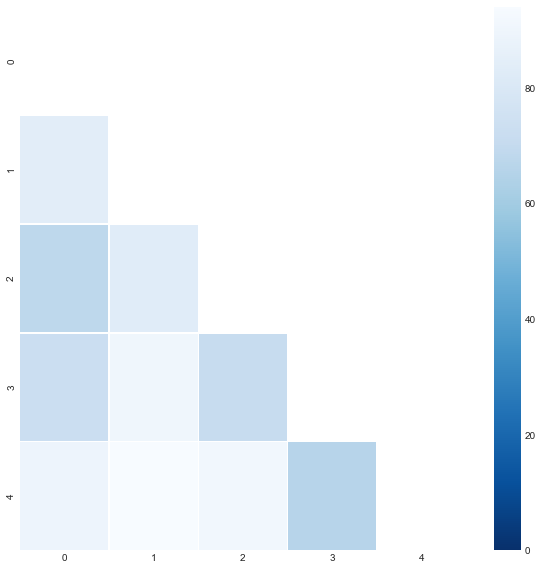


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.2140 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


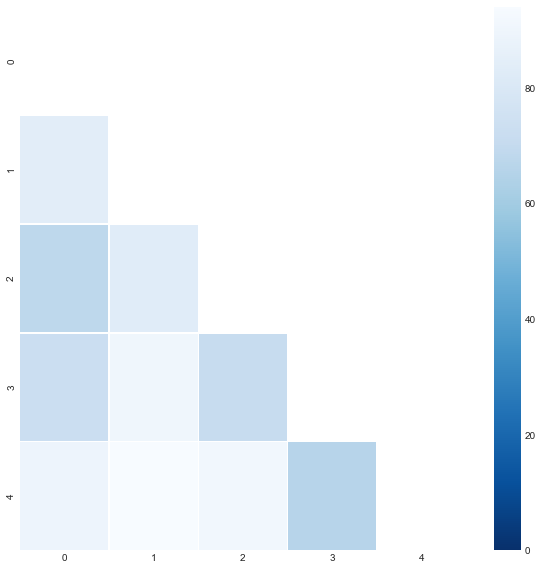


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1912 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


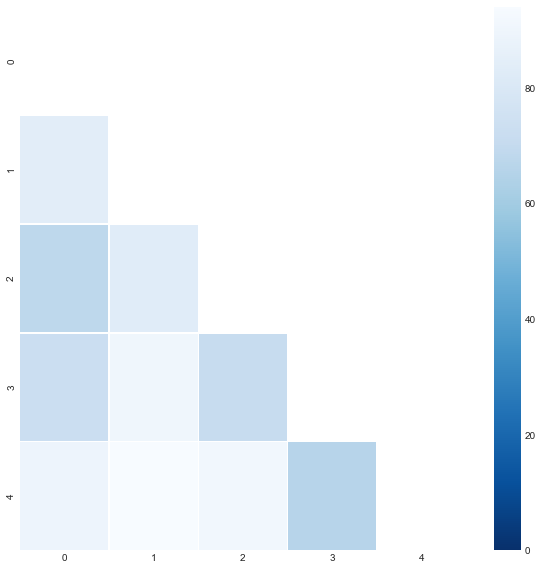


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1887 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{21, 13}
Final:
[9, 3, 17]

- Prototypes selected
[ 9  3 17]
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan


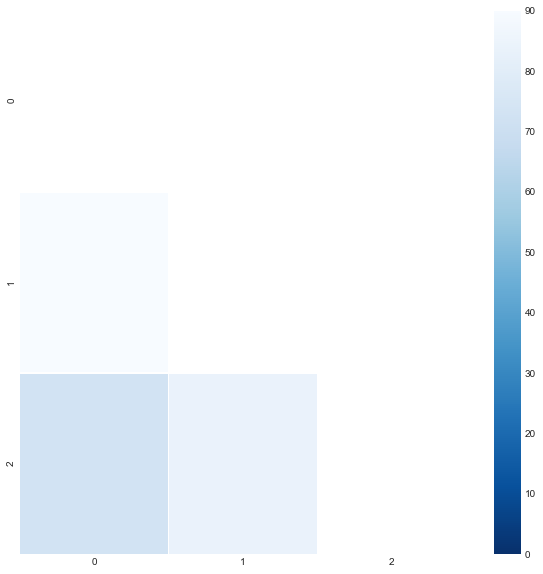


- Mean variance in prototype selection:  54.888888888888886

- Final number of prototypes:  3

# Finished in 0.1891 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{9, 21, 13, 17}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0189 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
######################


100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

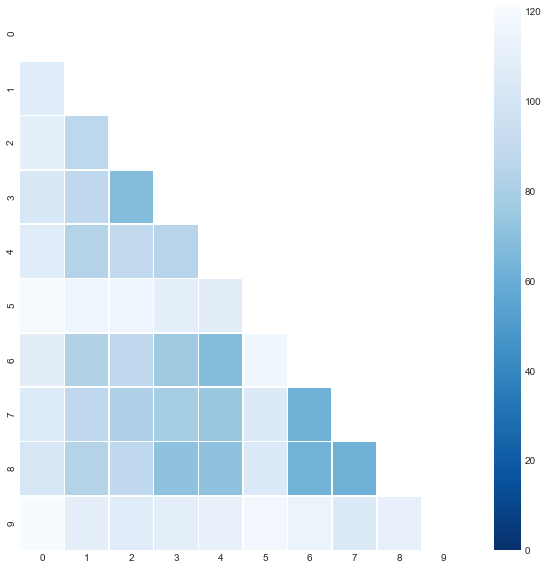


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2408 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

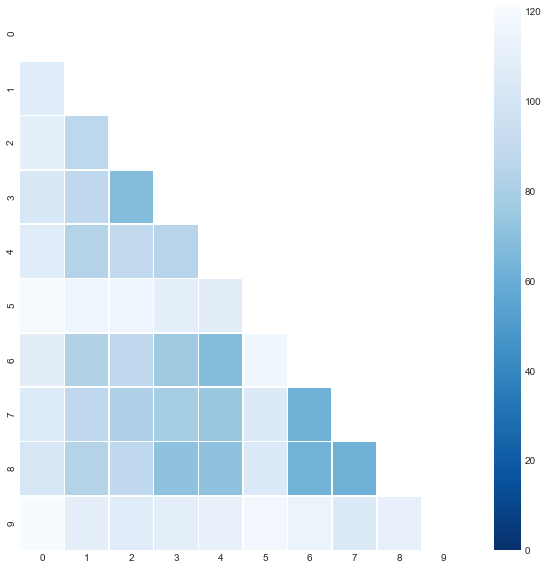


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2330 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

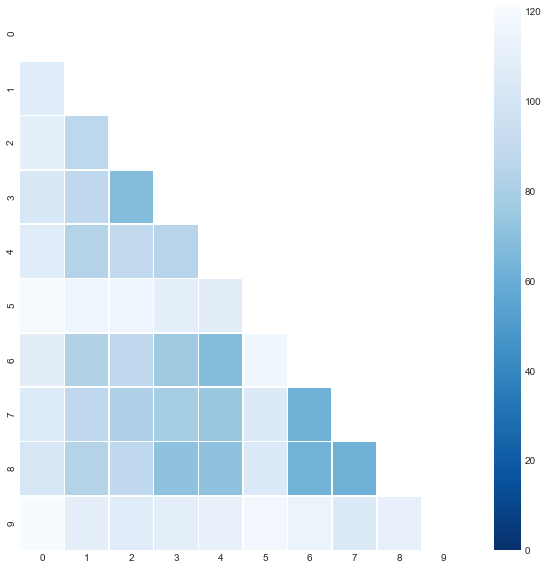


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2314 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{24, 28, 21, 46}
Final:
[34, 3, 38, 17, 51, 30]

- Prototypes selected
[34  3 38 17 51 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


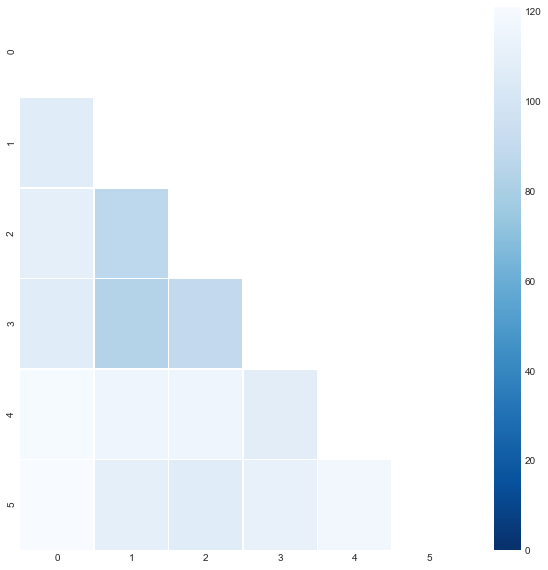


- Mean variance in prototype selection:  89.38888888888889

- Final number of prototypes:  6

# Finished in 0.2120 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{38, 46, 17, 21, 24, 28}
Final:
[51, 34, 3, 30]

- Prototypes selected
[51 34  3 30]
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


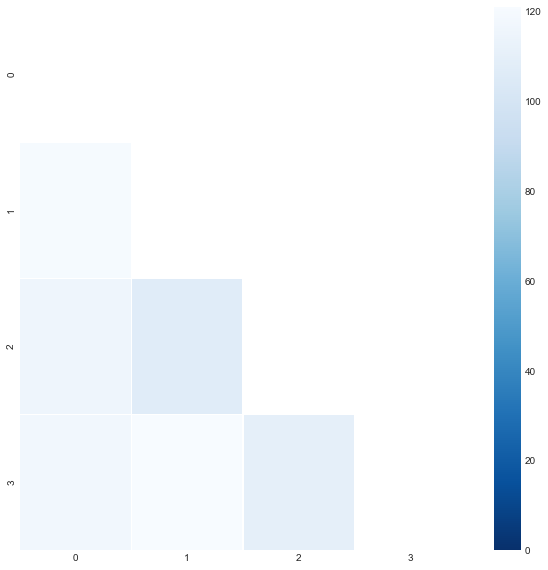


- Mean variance in prototype selection:  86.25

- Final number of prototypes:  4

# Finished in 0.2762 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

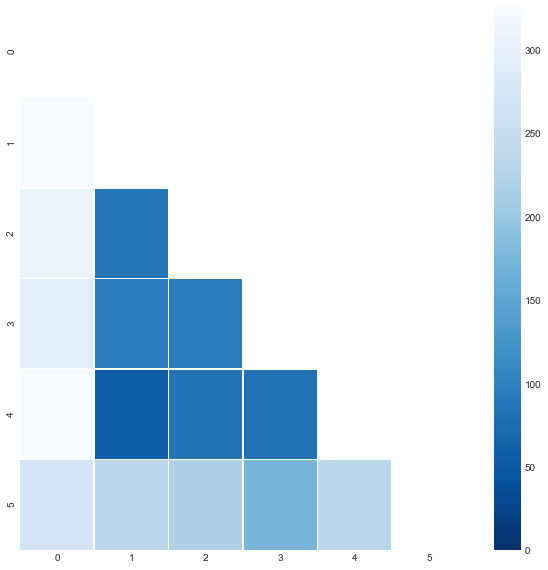


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2551 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

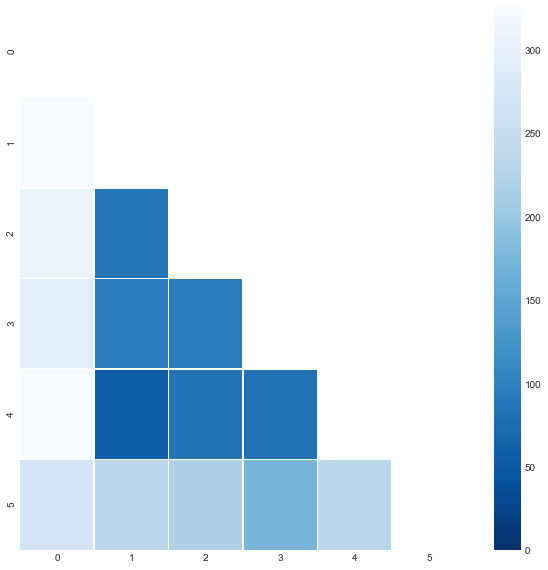


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2778 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

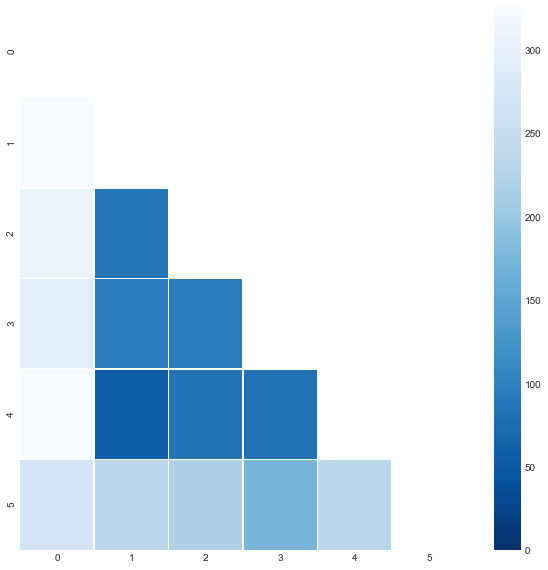


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2579 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

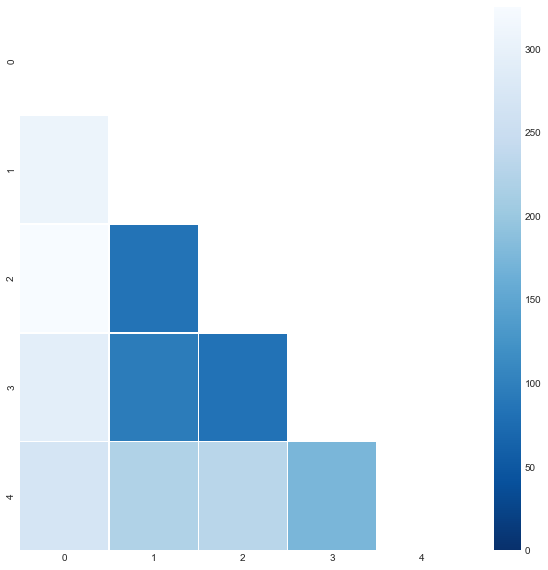


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2586 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


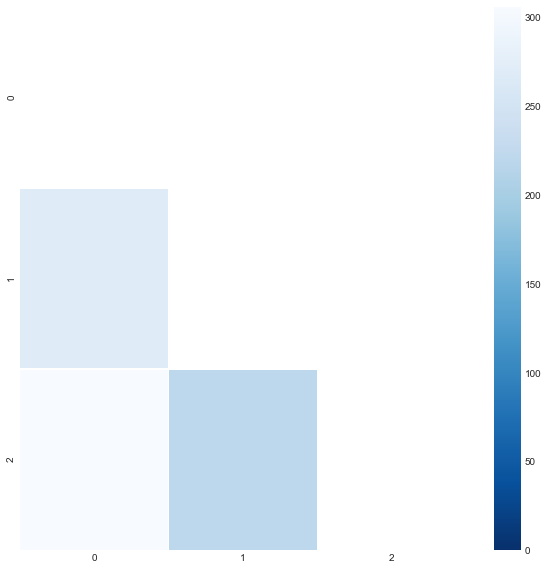


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2408 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 136, 110, 244, 309, 250, 284, 190}
Final:
[384, 3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 41, 44, 47, 178, 51, 59, 65, 203, 97, 100, 105, 107]

- Prototypes selected
[384   3  13  17  21 405 152  28  30 415  32  34 419  39  41  44  47 178
  51  59  65 203  97 100 105 107]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  

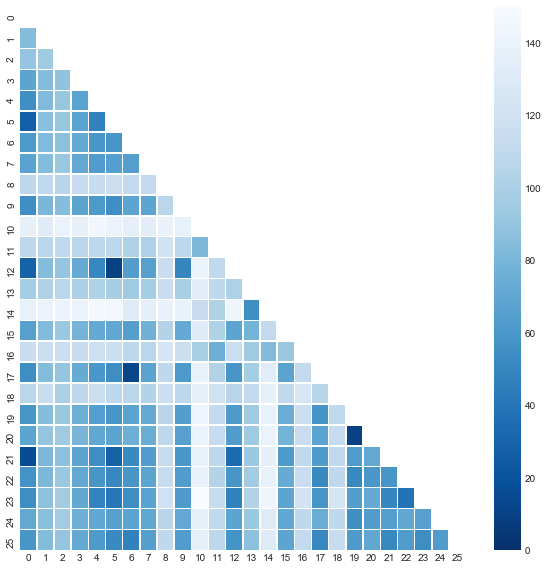


- Mean variance in prototype selection:  86.1508875739645

- Final number of prototypes:  26

# Finished in 0.4247 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 136, 110, 178, 244, 309, 250, 284, 190}
Final:
[3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 100, 105, 107]

- Prototypes selected
[  3  13  17  21 405 152  28  30 415  32  34  39  41  44  47  51  59 203
  97 100 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
405  ->  s. fahlman. the recurrent cascade-correlation architecture. nan
152  ->  fahlman  s. e. an e

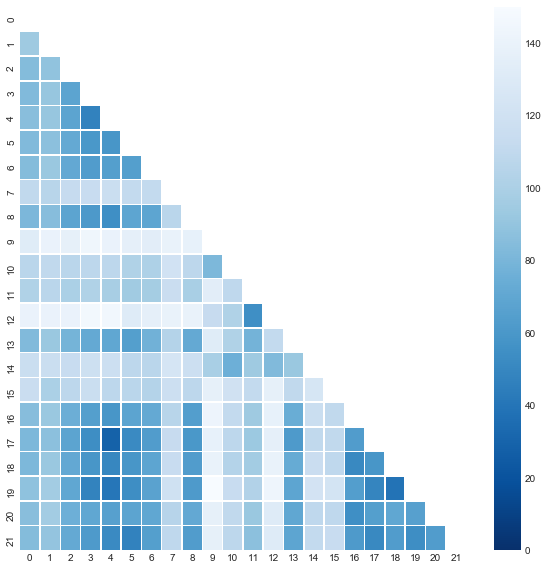


- Mean variance in prototype selection:  89.98347107438016

- Final number of prototypes:  22

# Finished in 0.3956 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 100, 136, 110, 178, 244, 309, 405, 250, 284, 190}
Final:
[3, 13, 17, 21, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 105, 107]

- Prototypes selected
[  3  13  17  21 152  28  30 415  32  34  39  41  44  47  51  59 203  97
 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
152  ->  fahlman  s. e. an empirical study of learning speed in backpropagation networks. nan
28  ->  nan an 

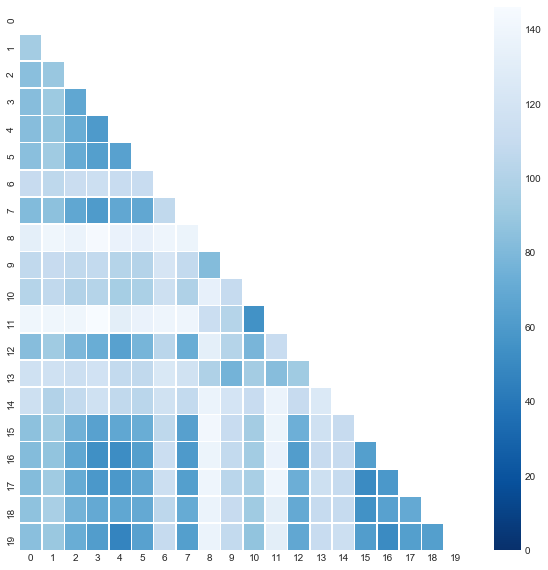


- Mean variance in prototype selection:  92.03

- Final number of prototypes:  20

# Finished in 0.3222 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 21, 405, 152, 28, 284, 415, 160, 419, 41, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 34, 3, 39, 44, 13, 47, 17, 51, 30]

- Prototypes selected
[32 34  3 39 44 13 47 17 51 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
39  ->  m fahle and s edelman. long-term learning in vernier acuity: effects of stimulus orientation  range and of feedback. vision resear

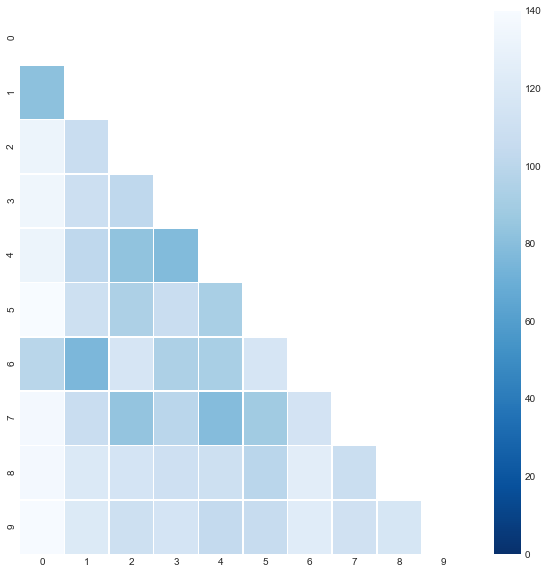


- Mean variance in prototype selection:  97.62

- Final number of prototypes:  10

# Finished in 0.3092 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 13, 17, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 41, 44, 47, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 51, 3, 30]

- Prototypes selected
[32 51  3 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical soc

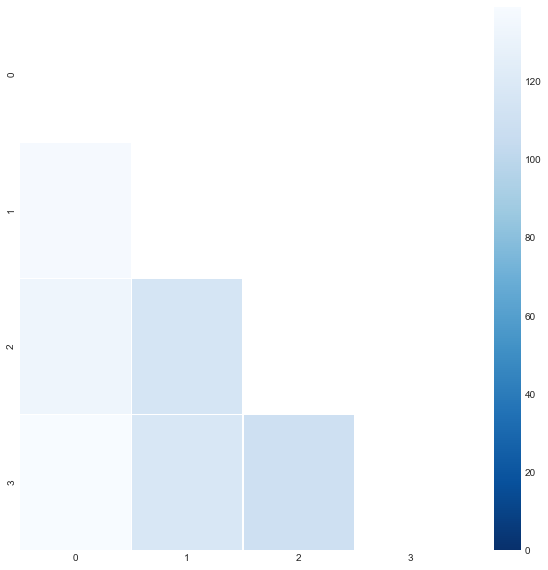


- Mean variance in prototype selection:  93.75

- Final number of prototypes:  4

# Finished in 0.2095 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

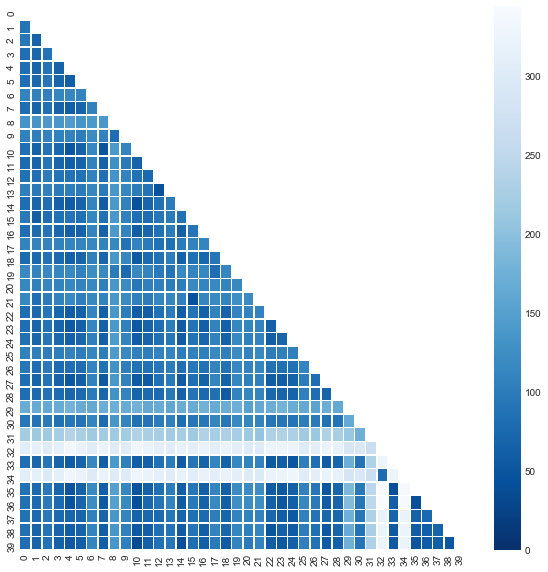


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6150 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

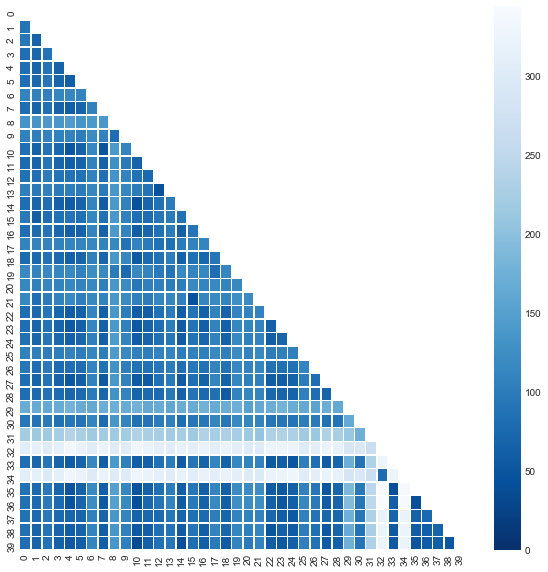


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6189 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{418, 100}
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34  36  38  40 424 426 428  45 430
  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 102 105
 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. act

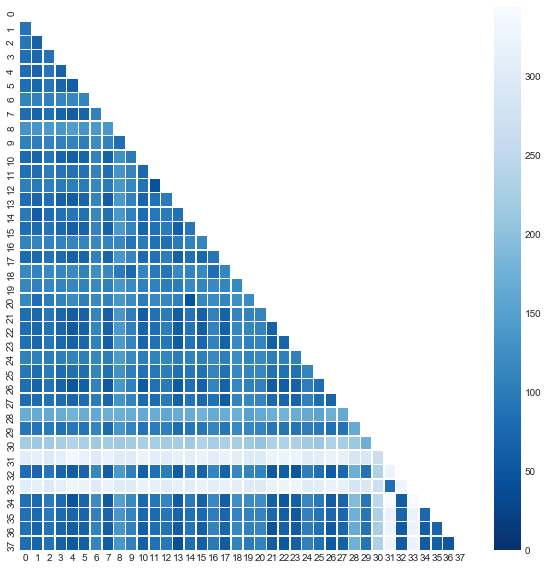


- Mean variance in prototype selection:  121.15789473684211

- Final number of prototypes:  38

# Finished in 0.5924 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{13, 21, 28, 415, 418, 36, 424, 40, 426, 428, 430, 180, 442, 60, 456, 462, 97, 100, 102, 105, 117, 253}
Final:
[32, 480, 34, 3, 451, 453, 38, 482, 9, 45, 47, 432, 17, 51, 467, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453  38 482   9  45  47 432  17  51 467 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the

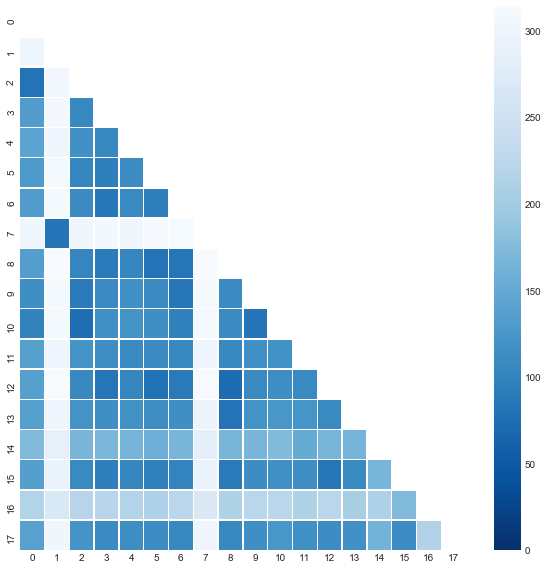


- Mean variance in prototype selection:  155.25925925925927

- Final number of prototypes:  18

# Finished in 0.3059 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{9, 13, 17, 21, 28, 415, 418, 34, 36, 38, 424, 40, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 453, 456, 462, 472, 97, 482, 100, 102, 105, 117, 253}
Final:
[32, 480, 3, 451, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the monk's problems: a performance comparison o

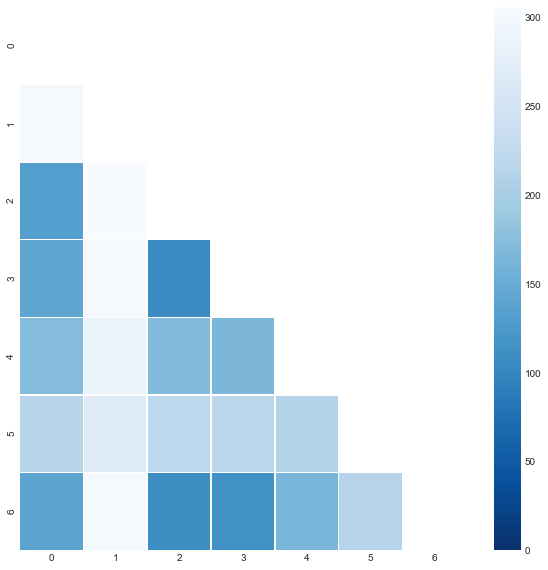


- Mean variance in prototype selection:  173.87755102040816

- Final number of prototypes:  7

# Finished in 0.2306 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

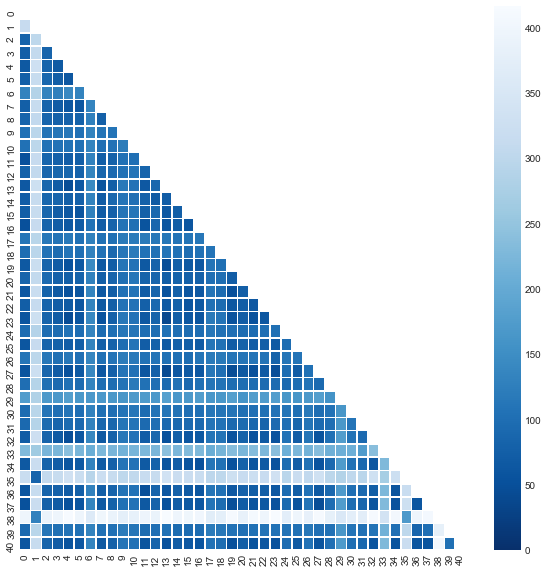


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7438 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

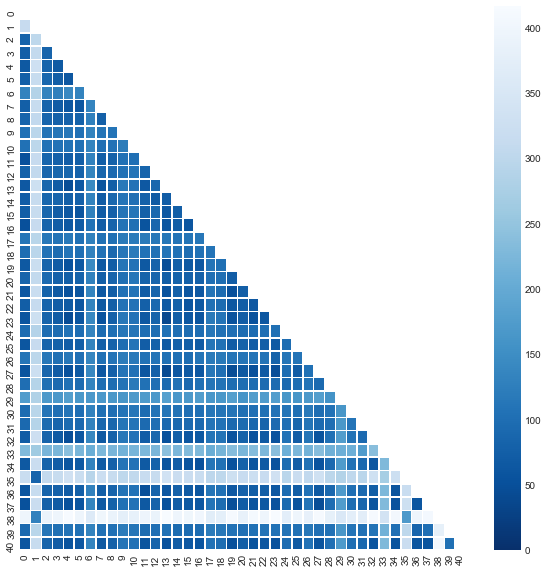


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7079 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

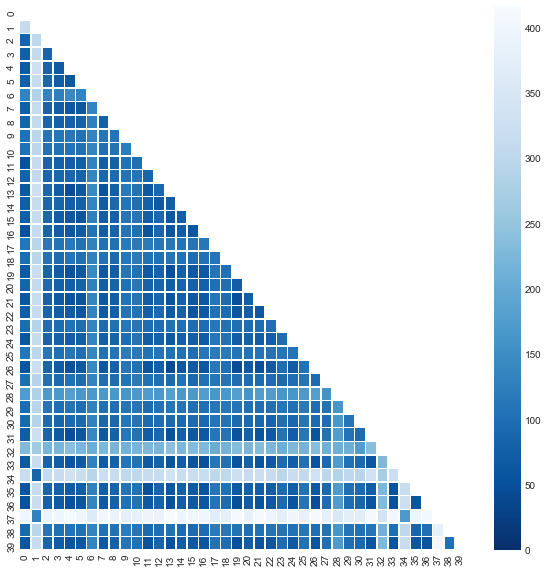


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6878 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

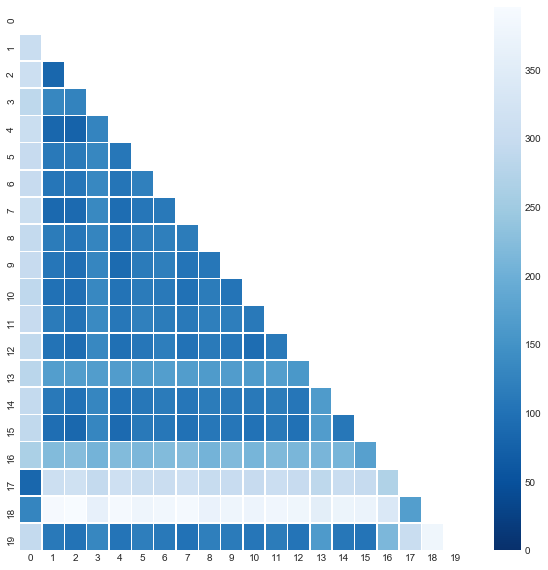


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4122 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

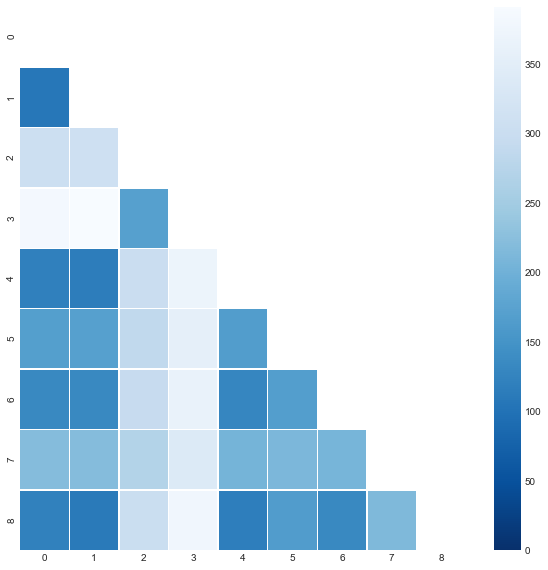


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3449 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

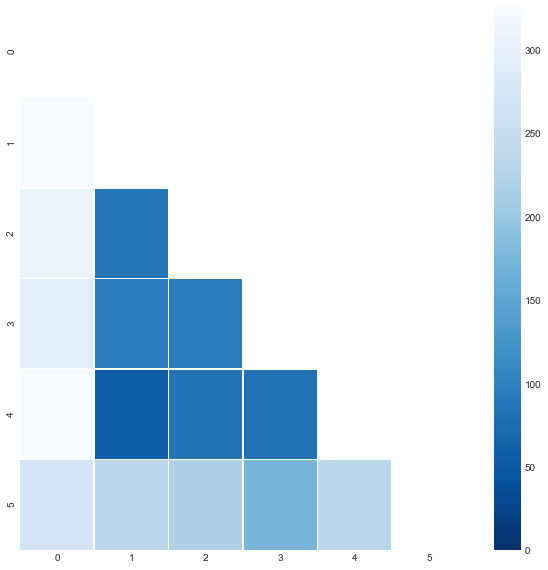


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3009 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

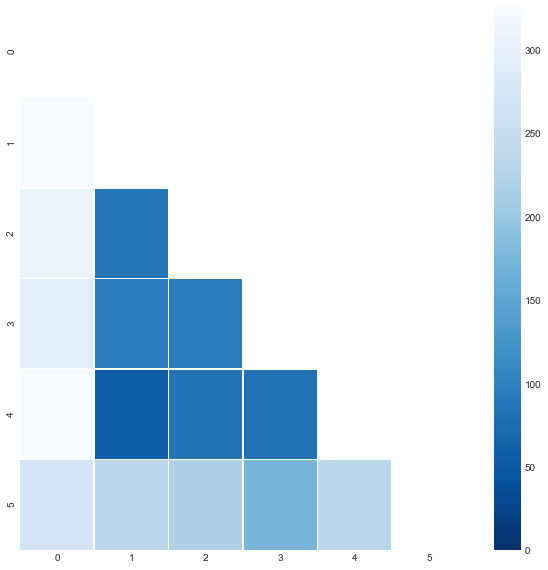


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3569 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

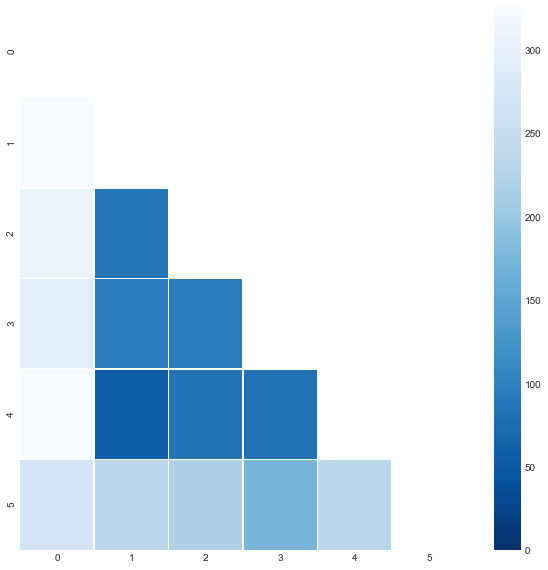


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2828 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

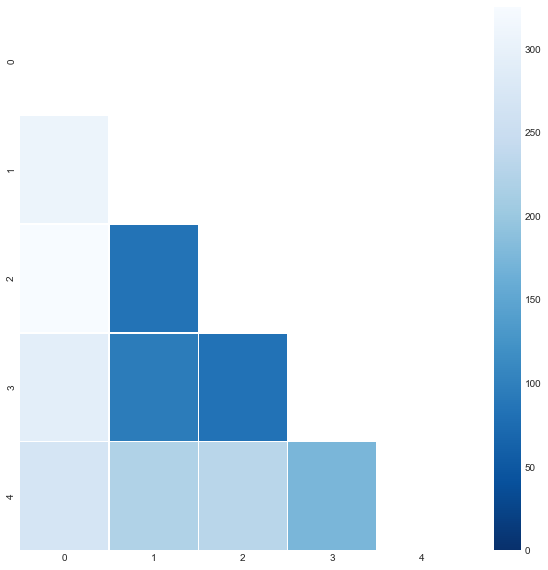


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2562 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


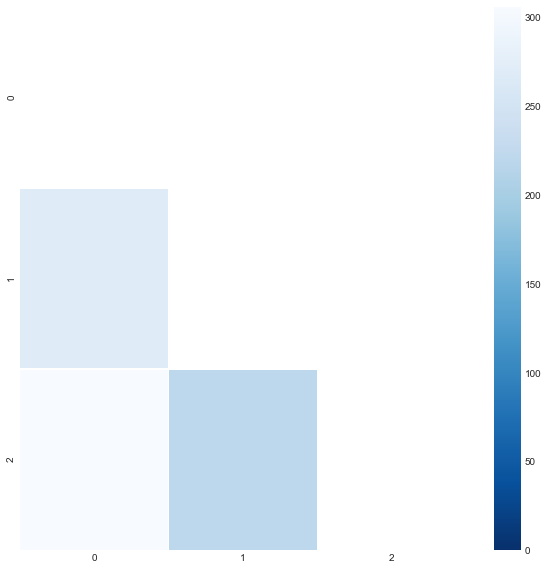


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2481 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 515, 136, 488, 492, 110, 244, 309, 250, 284, 190, 511}
Final:
[384, 3, 518, 13, 525, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 424, 41, 426, 44, 47, 178, 51, 562, 442, 59, 65, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504, 507]

- Prototypes selected
[384   3 518  13 525  17 531  21 405 152  28  30 415  32  34 419  39 424
  41 426  44  47 178  51 562 442  59  65 451 453 456 203 462 472 477 480
  97 482 100 484 486 105 107 496 501 504 507]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. ander

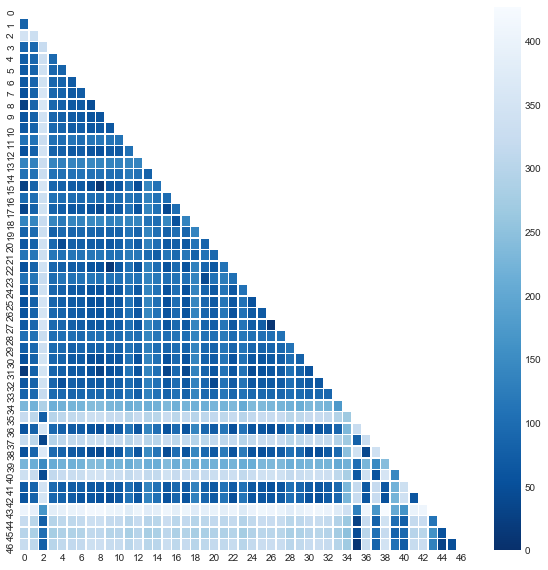


- Mean variance in prototype selection:  161.22951561792667

- Final number of prototypes:  47

# Finished in 0.6003 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 65, 384, 419, 515, 136, 488, 492, 110, 178, 244, 309, 250, 507, 284, 190, 511}
Final:
[3, 518, 525, 13, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 39, 424, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504]

- Prototypes selected
[  3 518 525  13  17 531  21 405 152  28  30 415  32  34  39 424  41 426
  44  47 562  51 442  59 451 453 456 203 462 472 477 480  97 482 100 484
 486 105 107 496 501 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
518  ->  thurn  s. b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  d

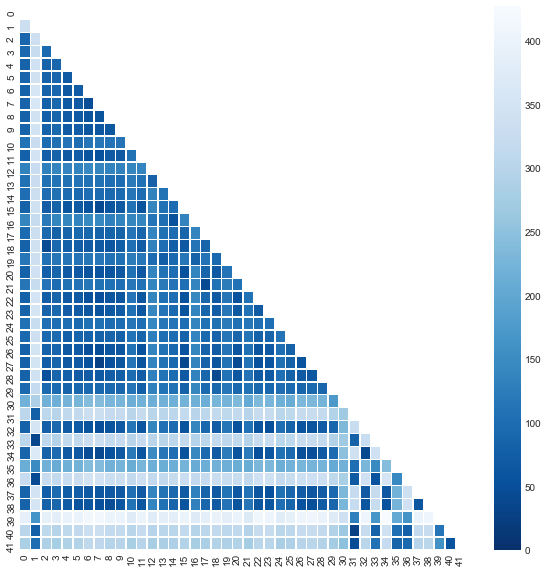


- Mean variance in prototype selection:  162.77324263038548

- Final number of prototypes:  42

# Finished in 0.6472 secs


+ ------------   43    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 405, 284, 160, 419, 424, 178, 309, 190, 65, 100, 488, 492, 110, 244, 501, 250, 507, 511}
Final:
[3, 525, 13, 17, 531, 21, 152, 28, 30, 415, 32, 34, 39, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 484, 486, 105, 107, 496, 504]

- Prototypes selected
[  3 525  13  17 531  21 152  28  30 415  32  34  39  41 426  44  47 562
  51 442  59 451 453 456 203 462 472 477 480  97 482 484 486 105 107 496
 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
525  ->  weiss  y.  edelman  s.  and fahle  m. models of perceptual learning in vernier hyperacuity. neu

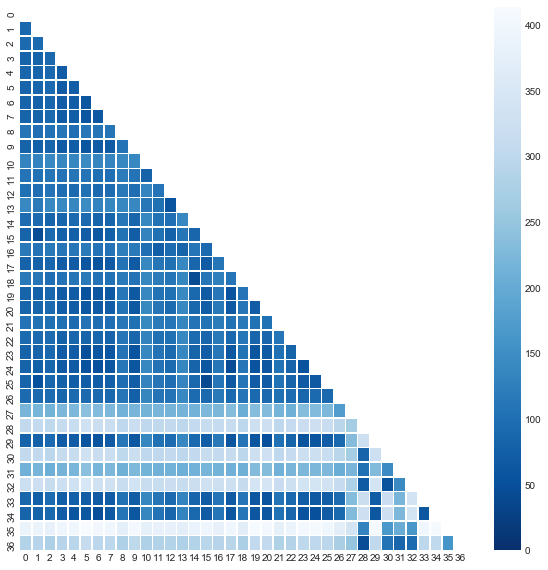


- Mean variance in prototype selection:  155.40102264426588

- Final number of prototypes:  37

# Finished in 0.6171 secs


+ ------------   44    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 525, 531, 21, 405, 152, 28, 284, 415, 160, 419, 424, 41, 426, 178, 562, 309, 442, 59, 190, 65, 456, 203, 462, 97, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 34, 3, 451, 453, 482, 39, 484, 44, 13, 47, 496, 17, 51, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453 482  39 484  44  13  47 496  17  51 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman

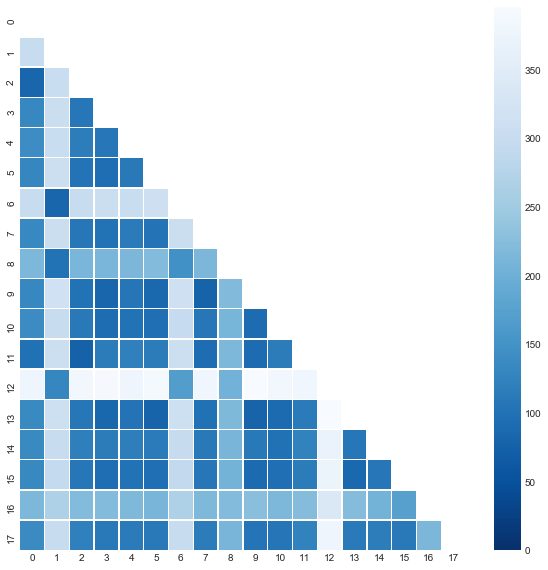


- Mean variance in prototype selection:  177.7716049382716

- Final number of prototypes:  18

# Finished in 0.3469 secs


+ ------------   45    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 13, 525, 17, 531, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 424, 41, 426, 44, 47, 178, 562, 309, 442, 59, 190, 65, 451, 453, 456, 203, 462, 472, 97, 482, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 3, 484, 496, 51, 477, 30]

- Prototypes selected
[ 32 480   3 484 496  51 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. k

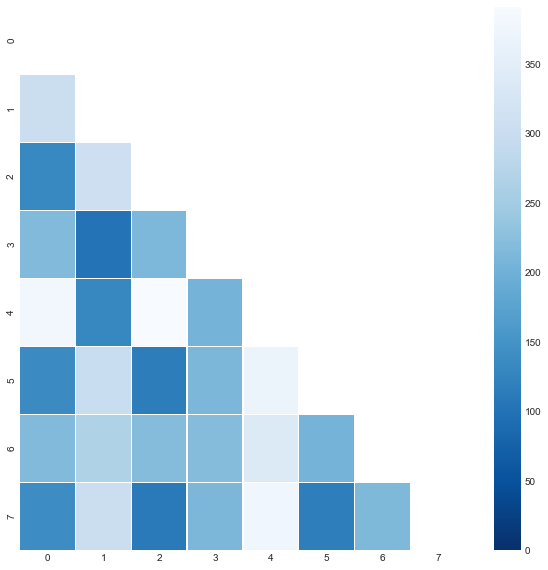


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.3421 secs


+ ------------   46    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 492, 1015, 755, 503, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 842, 852, 857, 603, 97, 867, 100, 102, 105, 874, 883, 117, 888, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 1017, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

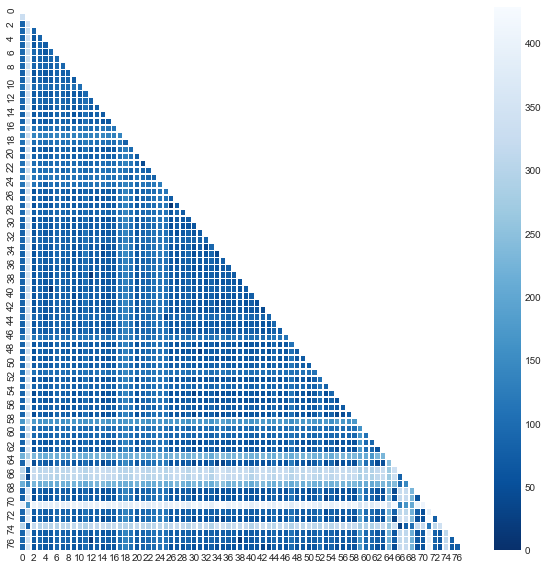


- Mean variance in prototype selection:  121.16995397764629

- Final number of prototypes:  78

# Finished in 0.7640 secs


+ ------------   47    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 842, 492, 883, 1015, 755, 503, 888, 1017, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 852, 857, 603, 97, 867, 100, 102, 105, 874, 117, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

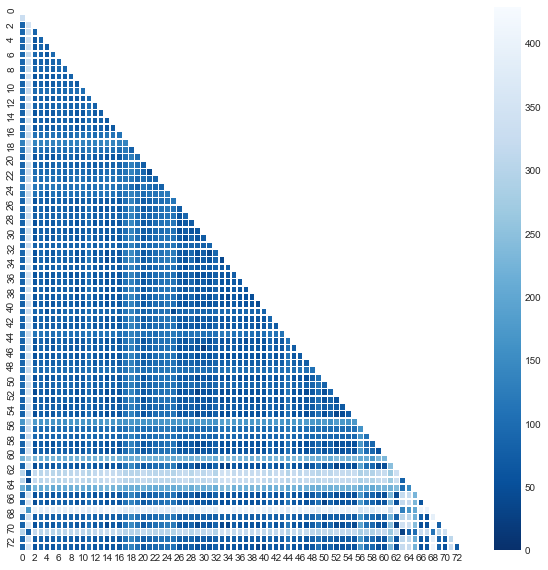


- Mean variance in prototype selection:  123.53287070854638

- Final number of prototypes:  74

# Finished in 0.7430 secs


+ ------------   48    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 418, 948, 713, 842, 720, 857, 734, 503, 100, 488, 492, 1006, 1011, 500, 883, 755, 1015, 888, 1017, 1021, 510}
Final:
[3, 774, 520, 9, 778, 525, 13, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 821, 442, 60, 702, 451, 708, 453, 711, 456, 462, 467, 852, 725, 472, 729, 603, 731, 477, 480, 97, 482, 867, 484, 102, 105, 745, 874, 496, 1009, 117, 1013, 253]

- Prototypes selected
[   3  774  520    9  778  525   13  783  528   17  785  531  788   21
  792   28   

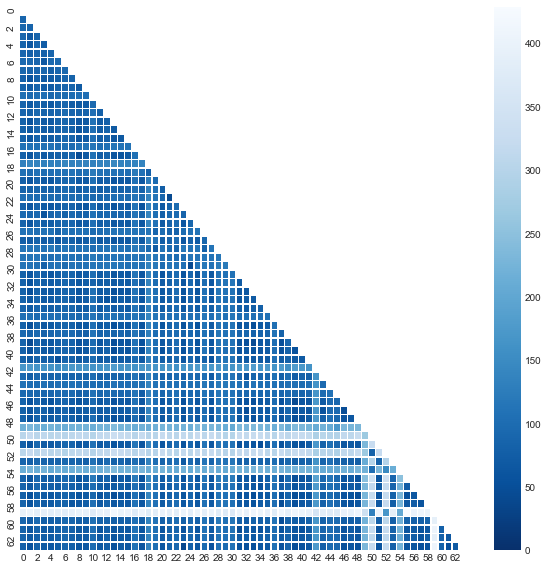


- Mean variance in prototype selection:  118.31640625

- Final number of prototypes:  64

# Finished in 0.6480 secs


+ ------------   49    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 774, 518, 778, 13, 525, 783, 528, 531, 788, 21, 792, 28, 415, 418, 36, 424, 40, 426, 428, 430, 948, 180, 821, 442, 60, 702, 708, 711, 456, 713, 842, 462, 720, 852, 729, 857, 731, 603, 734, 97, 867, 100, 503, 102, 488, 745, 874, 105, 492, 1006, 1009, 1017, 755, 883, 117, 1011, 1013, 1015, 253, 888, 500, 1021, 510}
Final:
[3, 520, 9, 17, 785, 30, 32, 34, 38, 45, 47, 432, 51, 451, 453, 467, 725, 472, 477, 480, 482, 484, 496]

- Prototypes selected
[  3 520   9  17 785  30  32  34  38  45  47 432  51 451 453 467 725 472
 477 480 48

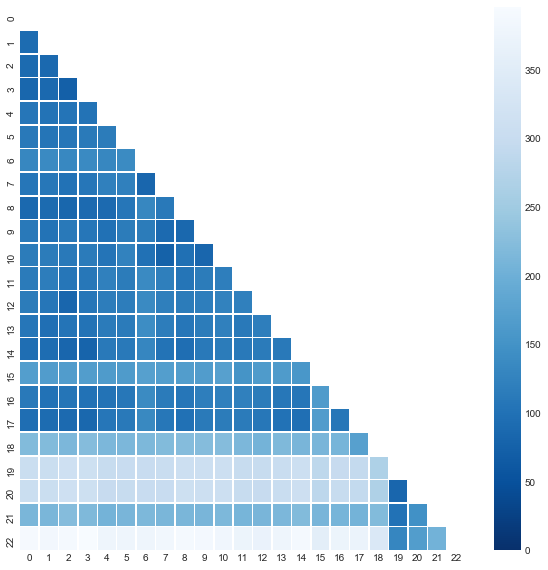


- Mean variance in prototype selection:  169.99243856332703

- Final number of prototypes:  23

# Finished in 0.4441 secs


+ ------------   50    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 520, 9, 13, 525, 528, 17, 531, 21, 28, 34, 36, 38, 40, 45, 47, 51, 60, 603, 97, 100, 102, 105, 117, 180, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 253, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 415, 418, 424, 426, 428, 430, 432, 948, 442, 453, 456, 462, 472, 482, 488, 492, 1006, 1009, 1011, 1015, 1013, 500, 503, 1017, 1021, 510}
Final:
[32, 480, 3, 451, 484, 496, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 484 496 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(

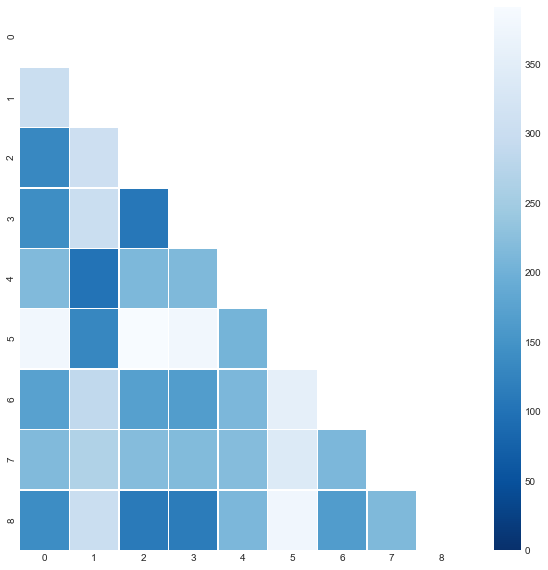


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.3041 secs


+ ------------   51    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

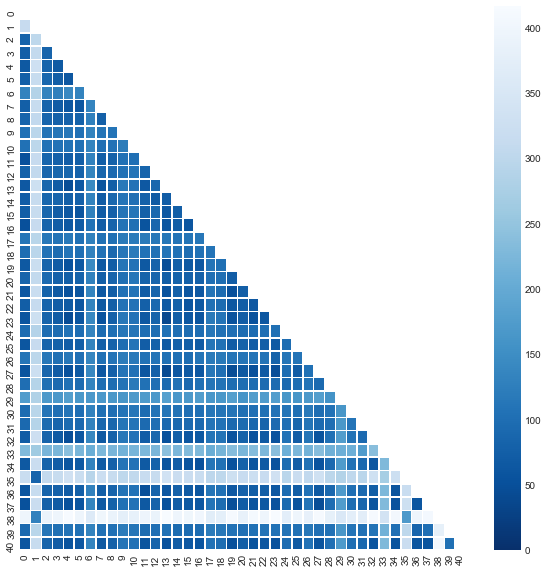


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7164 secs


+ ------------   52    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

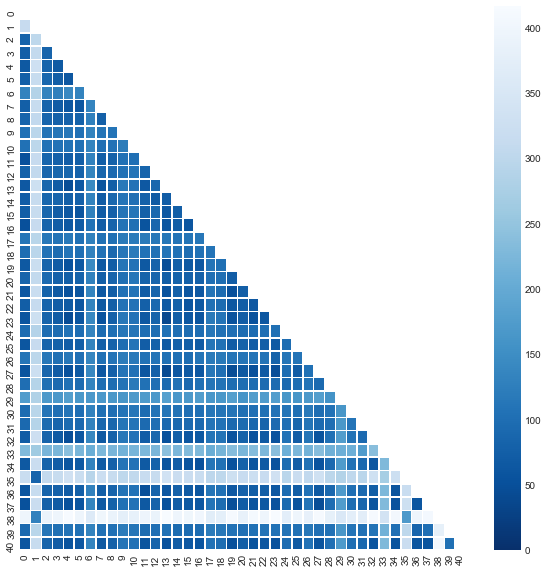


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6705 secs


+ ------------   53    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

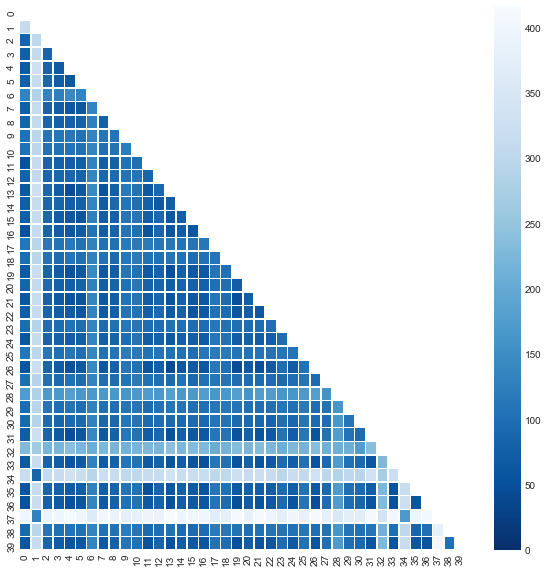


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6384 secs


+ ------------   54    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

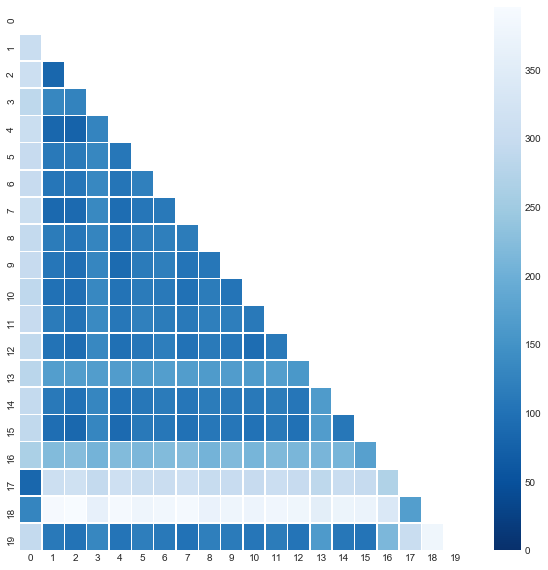


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3688 secs


+ ------------   55    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

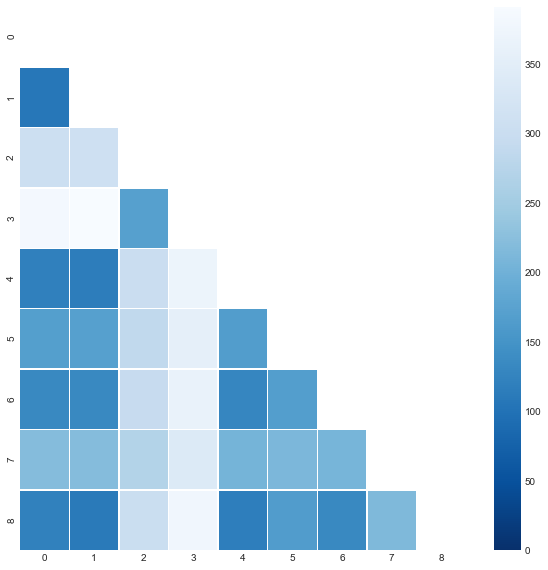


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2869 secs


+ ------------   56    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

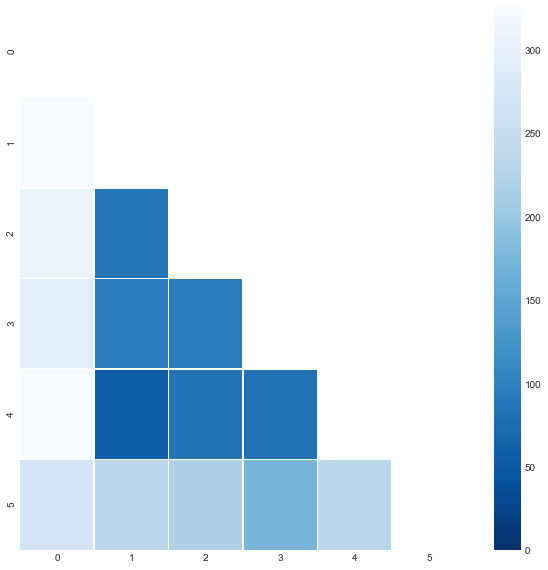


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2642 secs


+ ------------   57    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

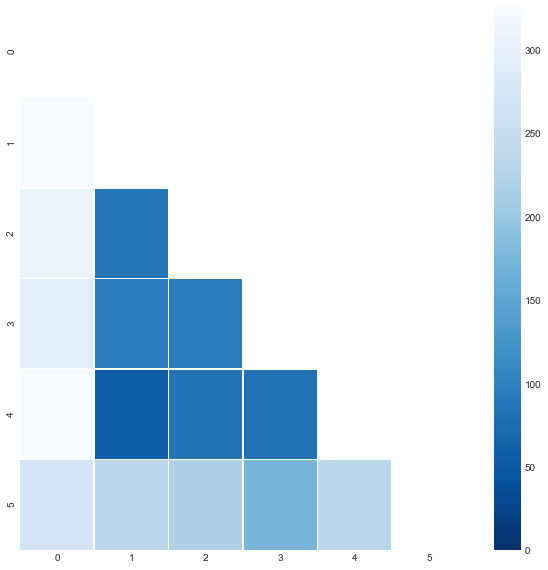


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2682 secs


+ ------------   58    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

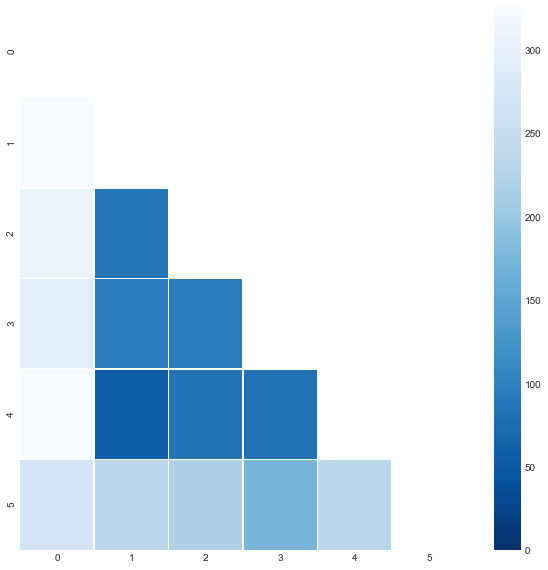


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2649 secs


+ ------------   59    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

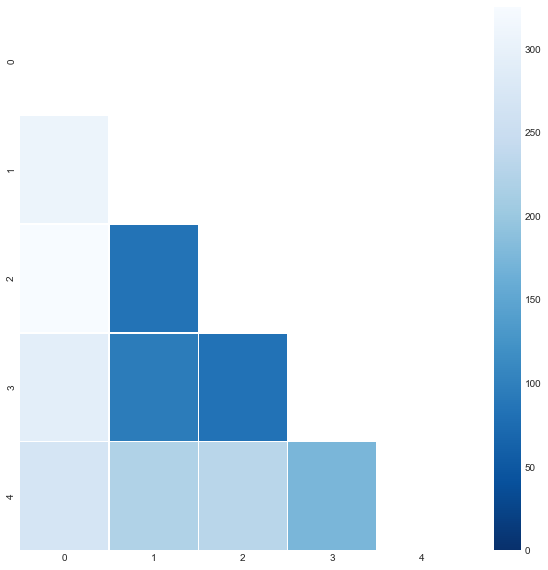


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2611 secs


+ ------------   60    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


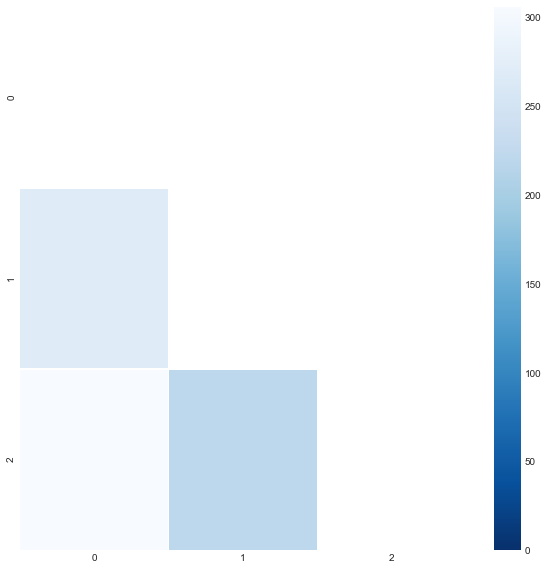


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2938 secs


+ ------------   61    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

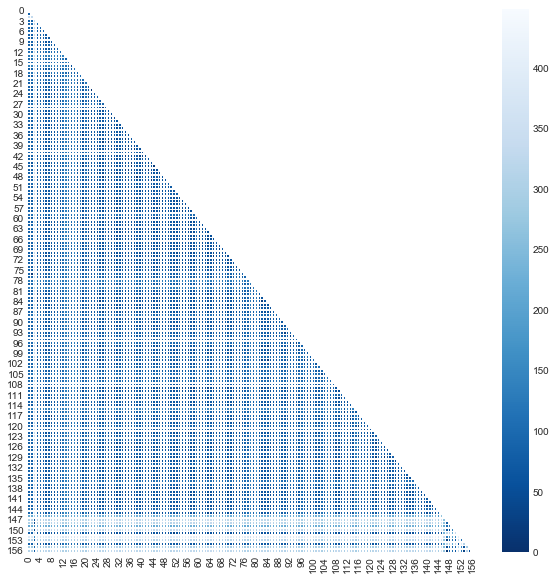


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3190 secs


+ ------------   62    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

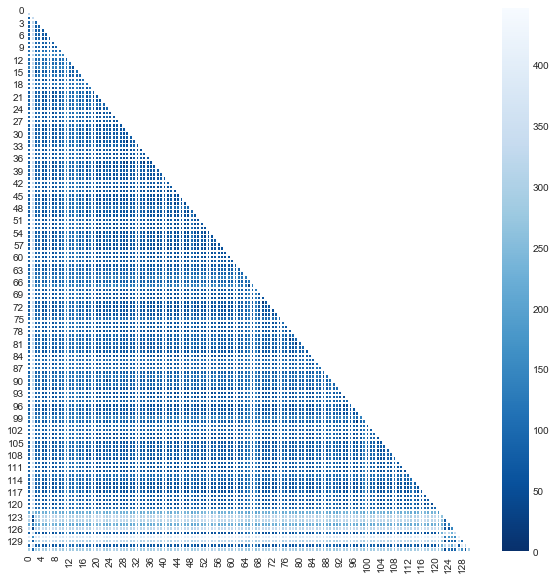


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0455 secs


+ ------------   63    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

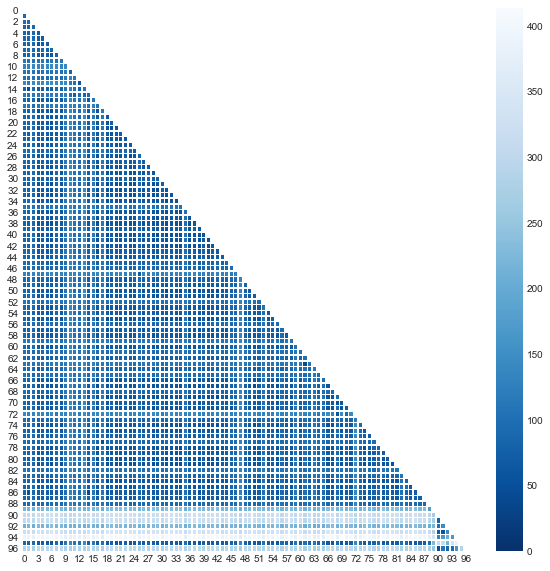


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.0630 secs


+ ------------   64    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

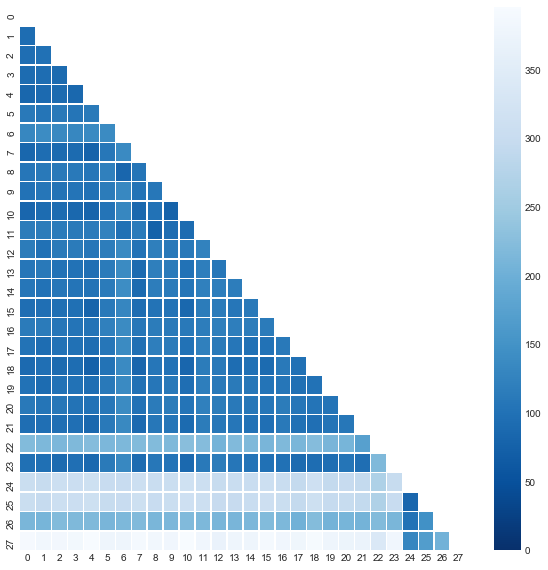


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7680 secs


+ ------------   65    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

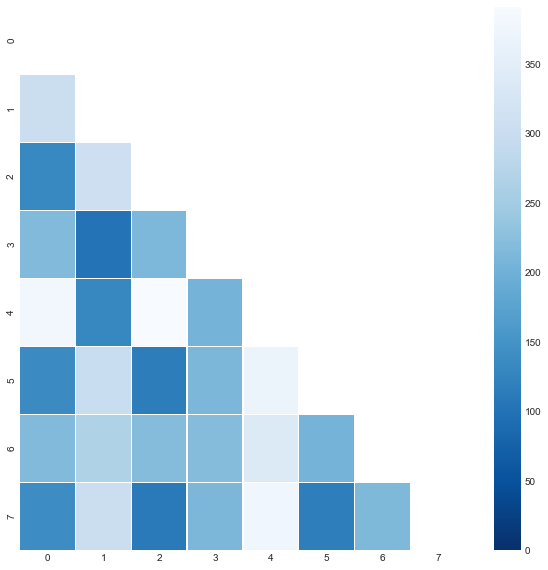


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.7115 secs


+ ------------   66    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

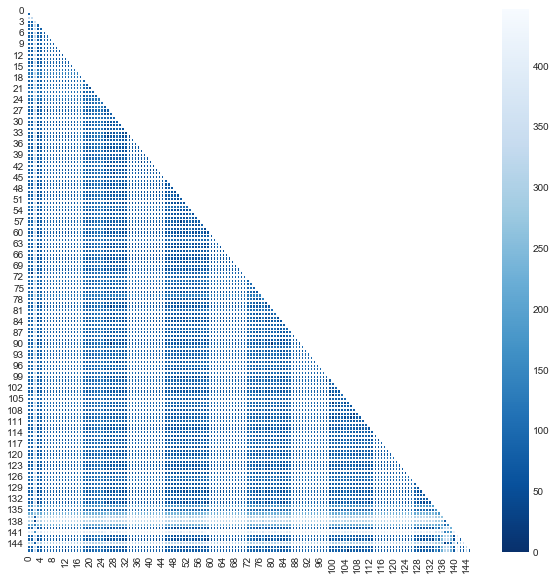


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.6804 secs


+ ------------   67    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

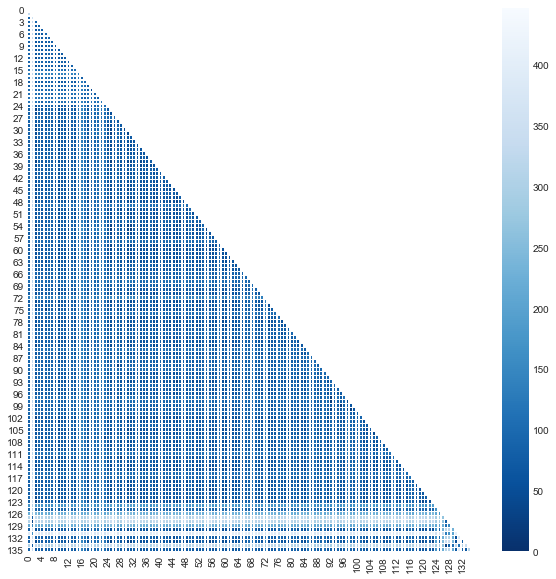


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 2.6691 secs


+ ------------   68    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

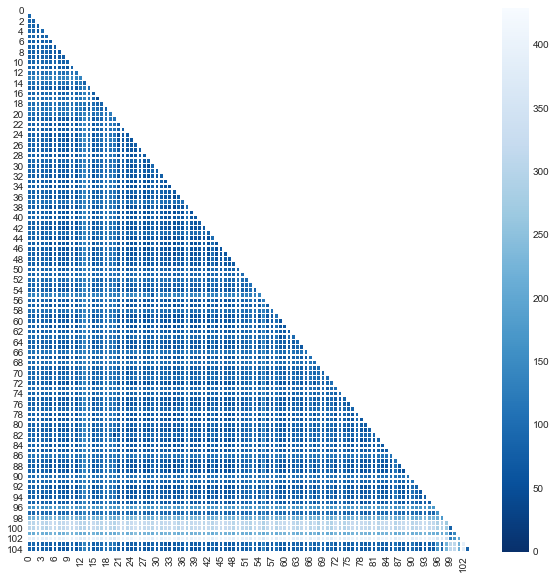


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.3818 secs


+ ------------   69    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

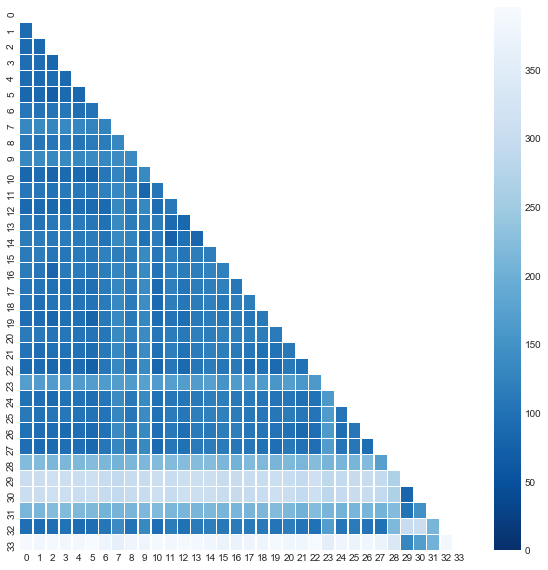


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 1.7068 secs


+ ------------   70    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

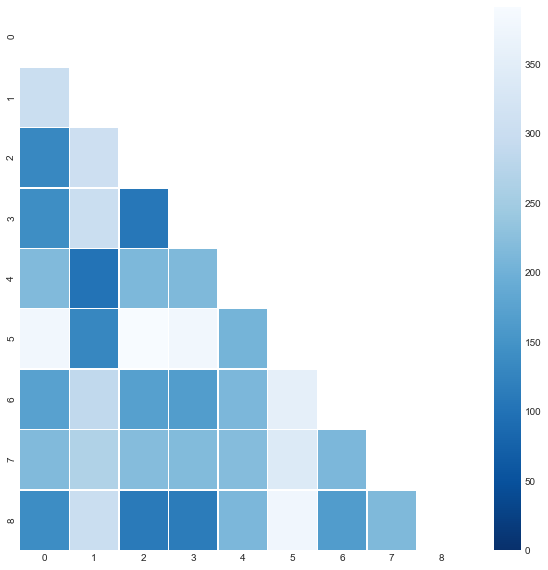


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.8057 secs


+ ------------   71    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

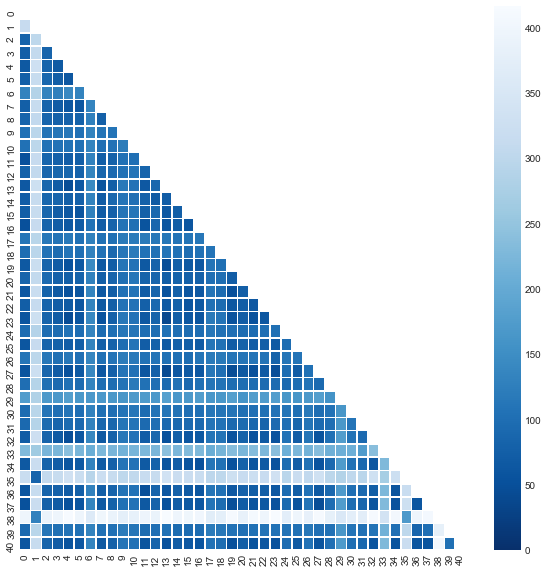


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9068 secs


+ ------------   72    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

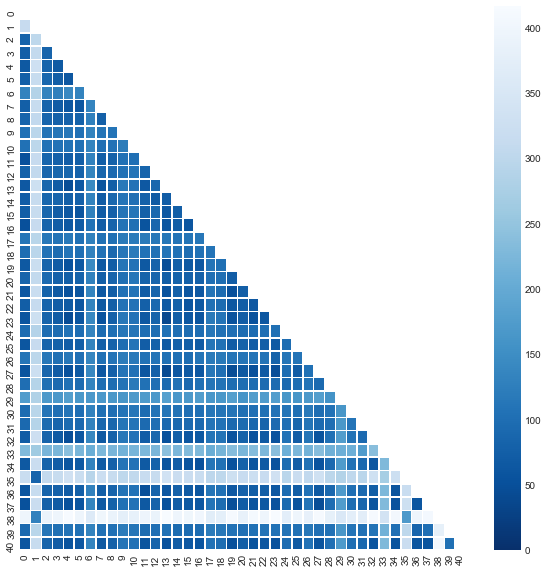


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6513 secs


+ ------------   73    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

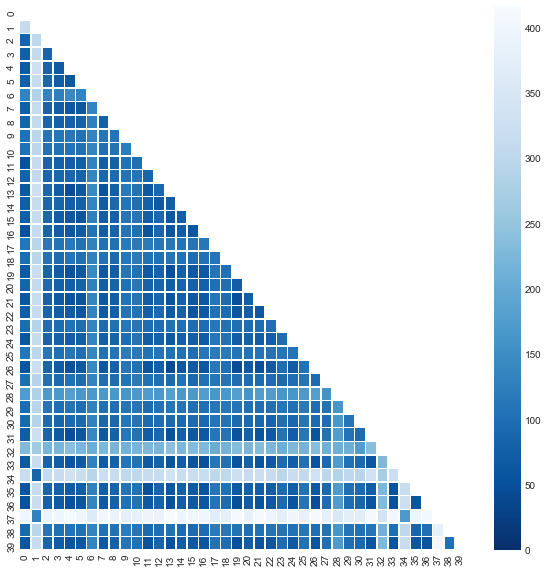


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6598 secs


+ ------------   74    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

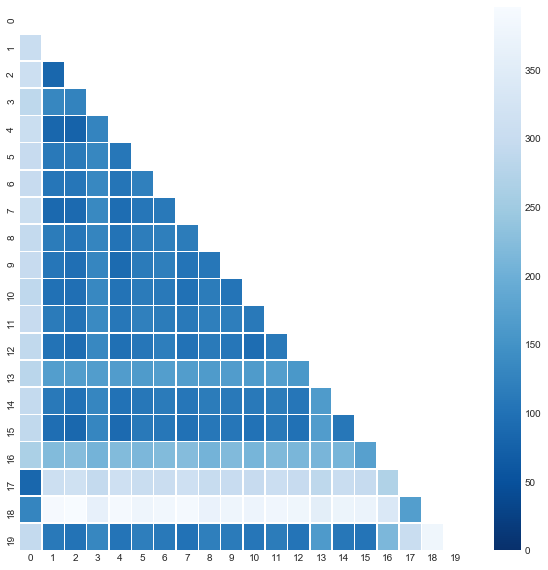


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3801 secs


+ ------------   75    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

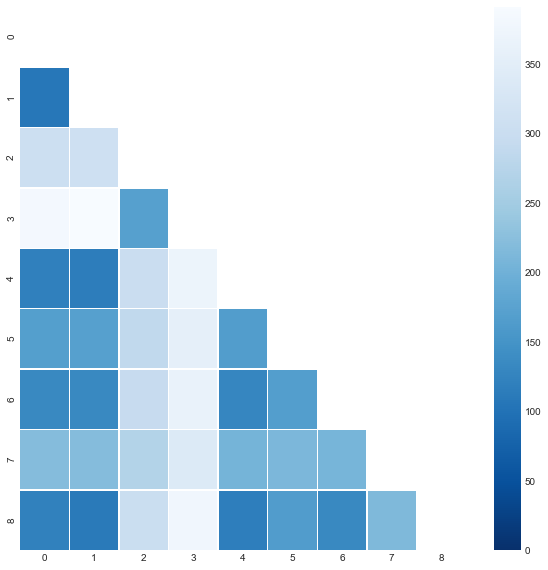


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3136 secs


+ ------------   76    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

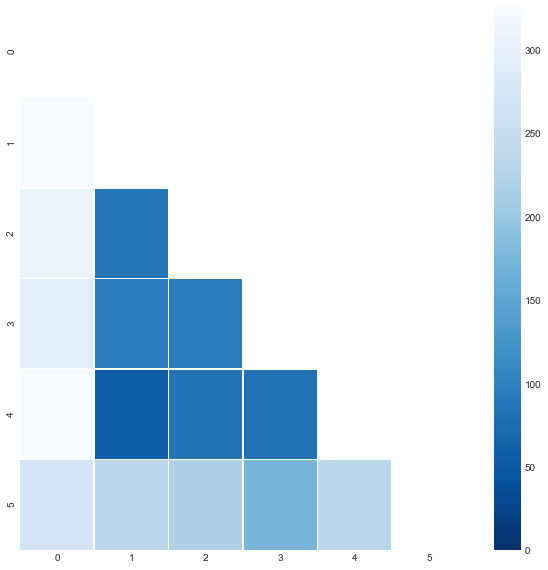


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2939 secs


+ ------------   77    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

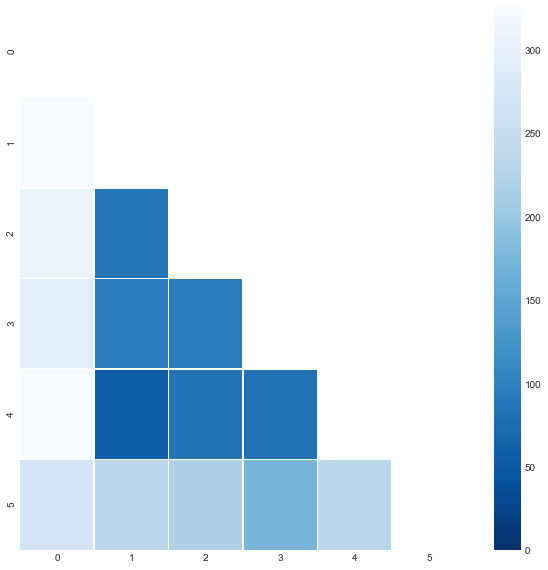


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2740 secs


+ ------------   78    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

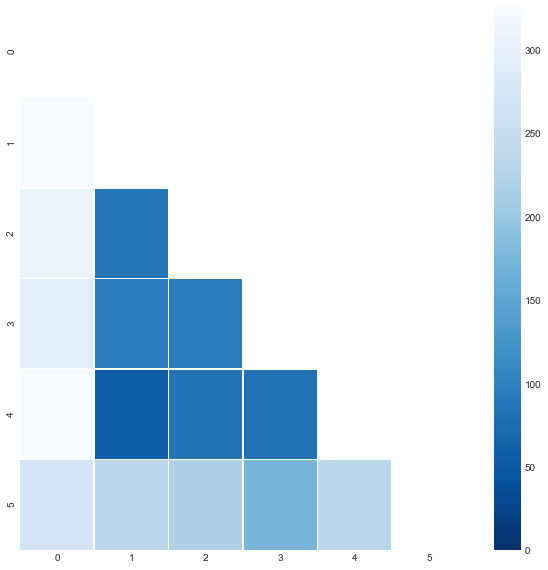


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3549 secs


+ ------------   79    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

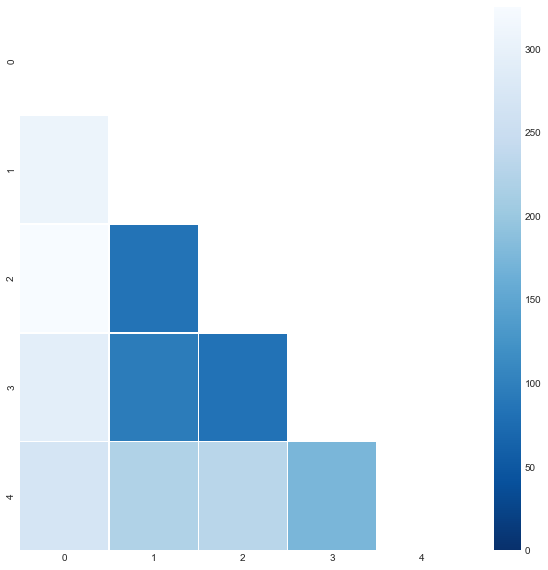


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.3153 secs


+ ------------   80    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


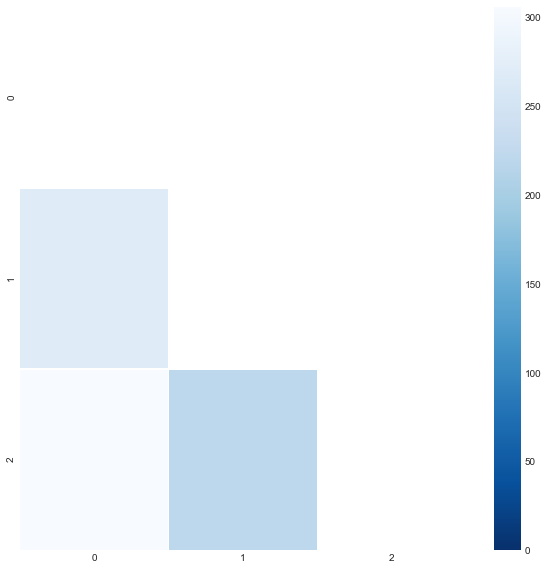


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2838 secs


+ ------------   81    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

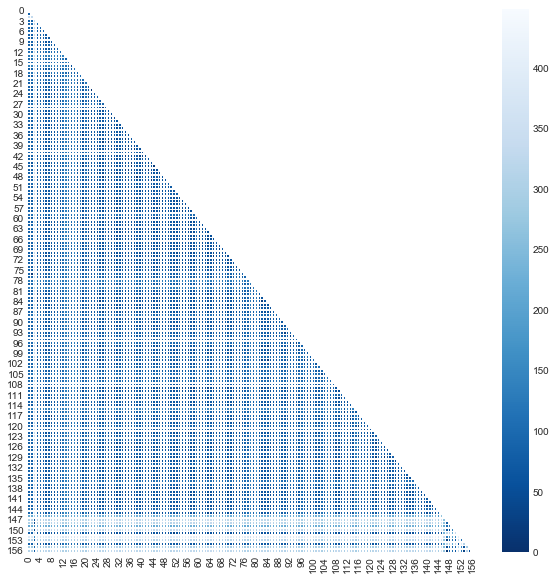


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3497 secs


+ ------------   82    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

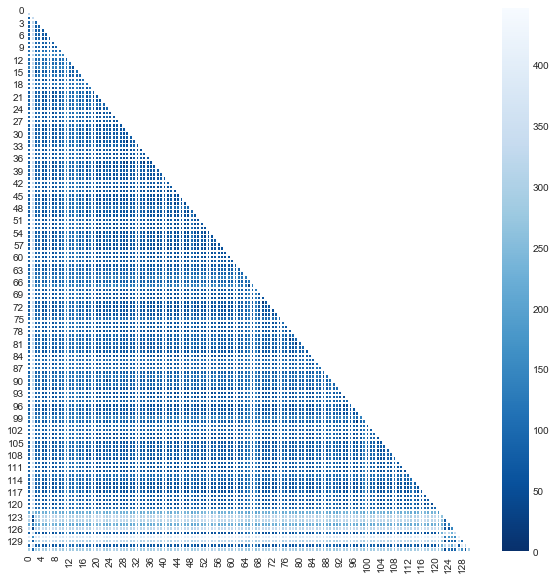


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0559 secs


+ ------------   83    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

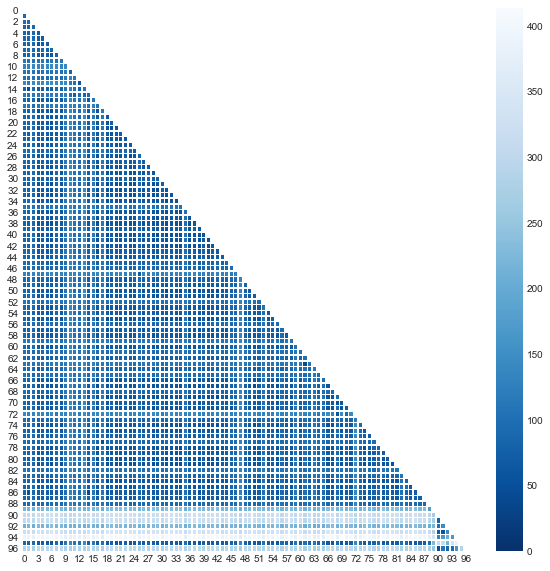


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.2021 secs


+ ------------   84    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

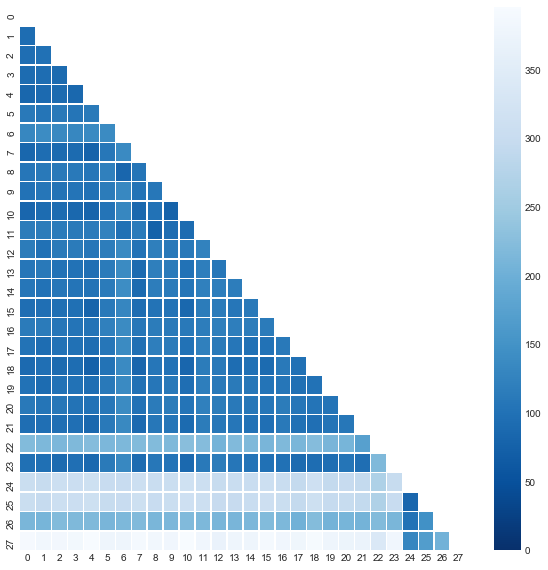


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7937 secs


+ ------------   85    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

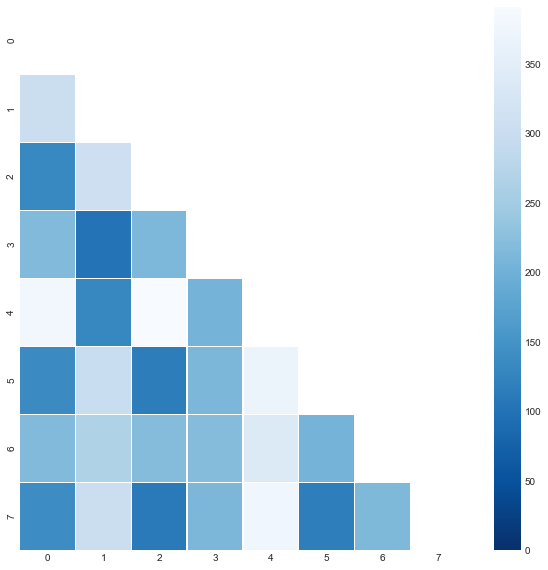


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.5648 secs


+ ------------   86    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

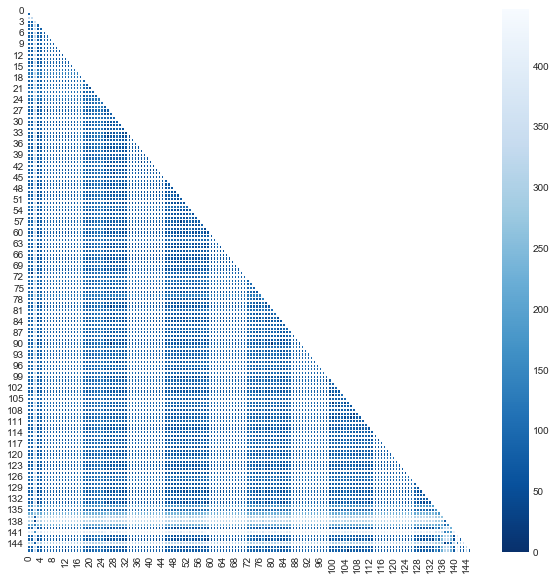


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.0734 secs


+ ------------   87    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

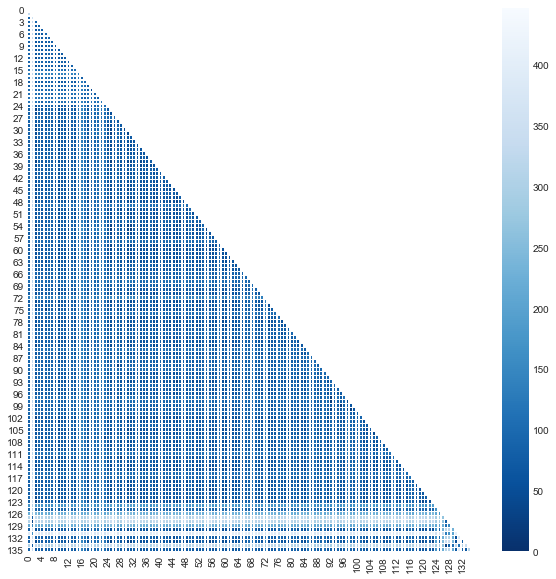


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 0.9877 secs


+ ------------   88    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

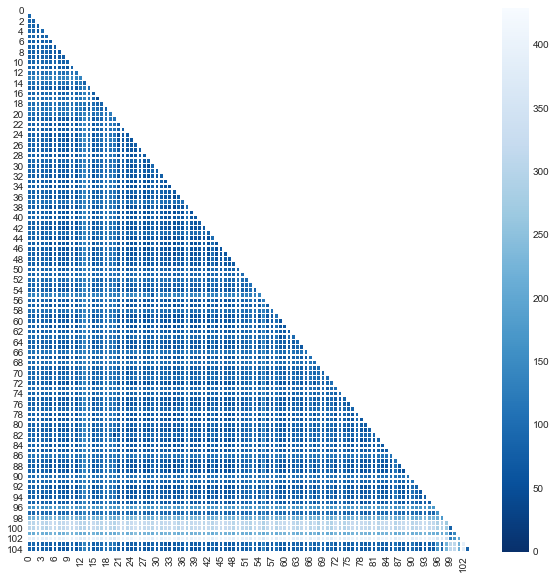


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.2133 secs


+ ------------   89    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

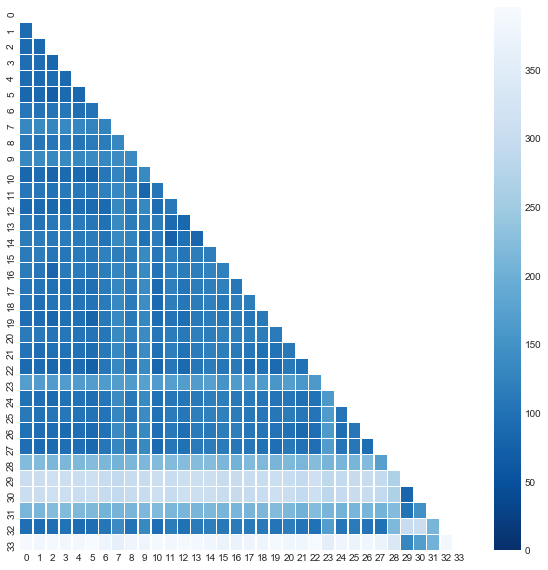


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 0.9140 secs


+ ------------   90    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

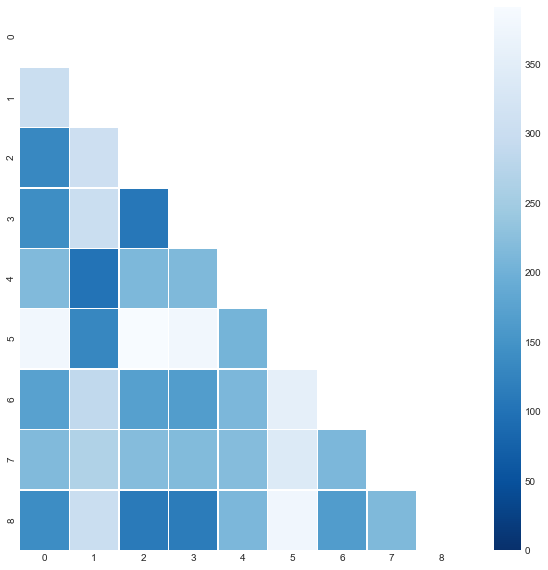


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.7639 secs


+ ------------   91    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

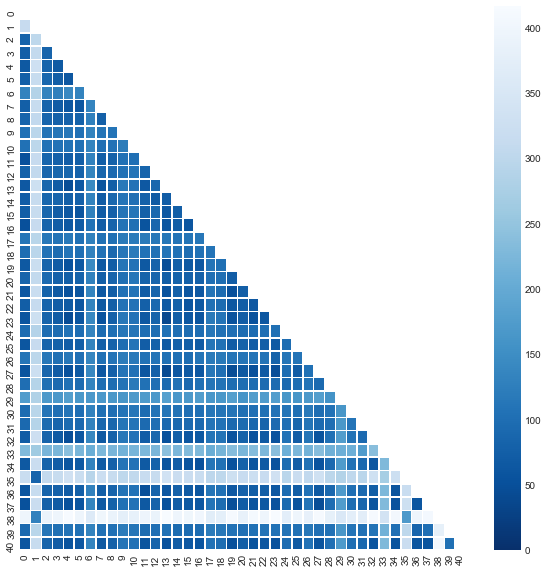


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9022 secs


+ ------------   92    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

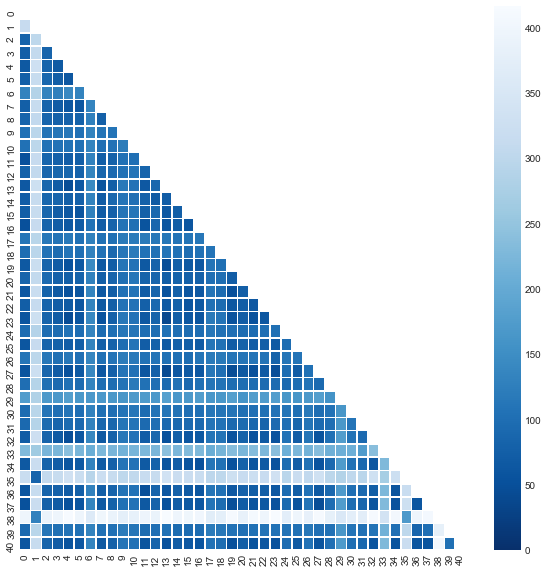


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.8638 secs


+ ------------   93    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

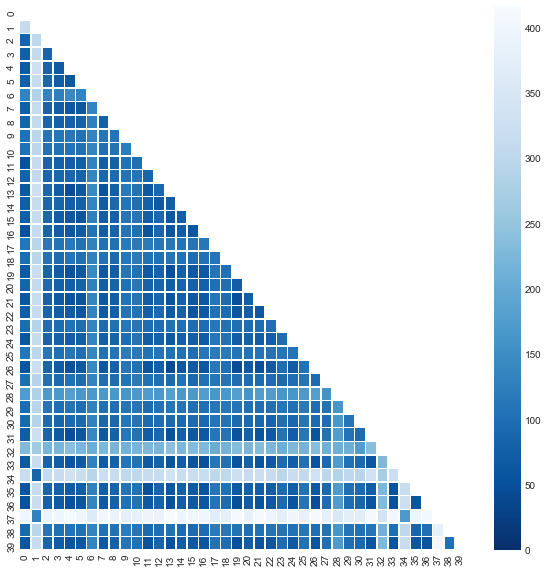


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.7101 secs


+ ------------   94    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

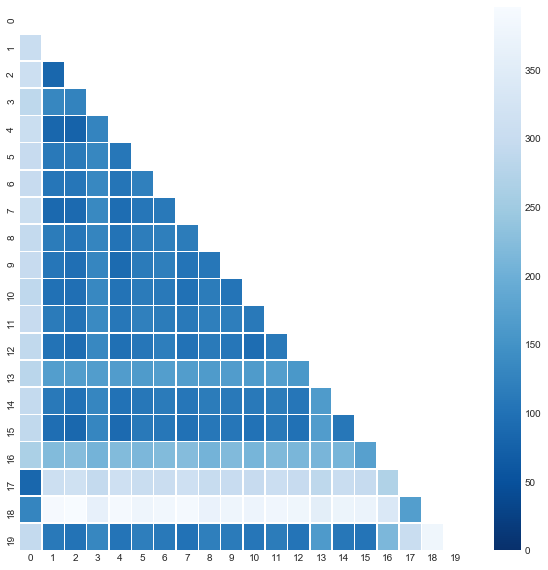


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4699 secs


+ ------------   95    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

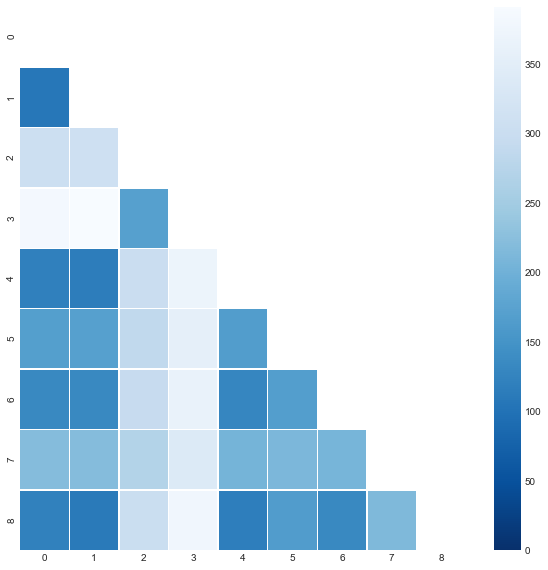


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3231 secs


+ ------------   96    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

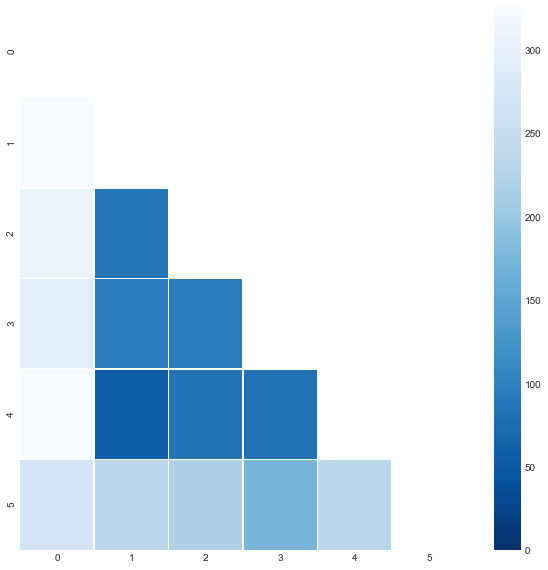


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2958 secs


+ ------------   97    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

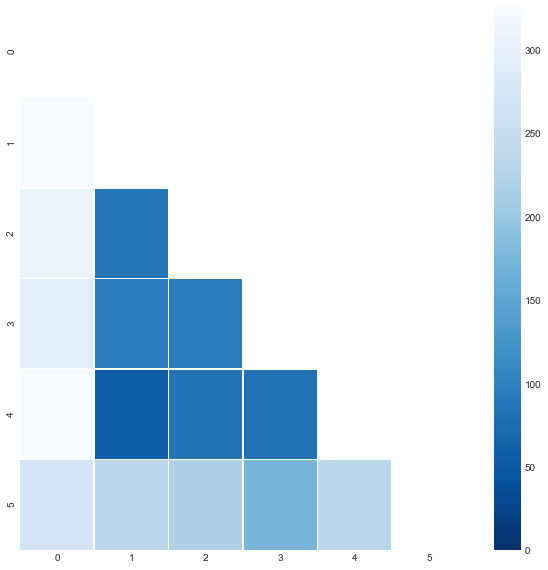


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.4242 secs


+ ------------   98    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

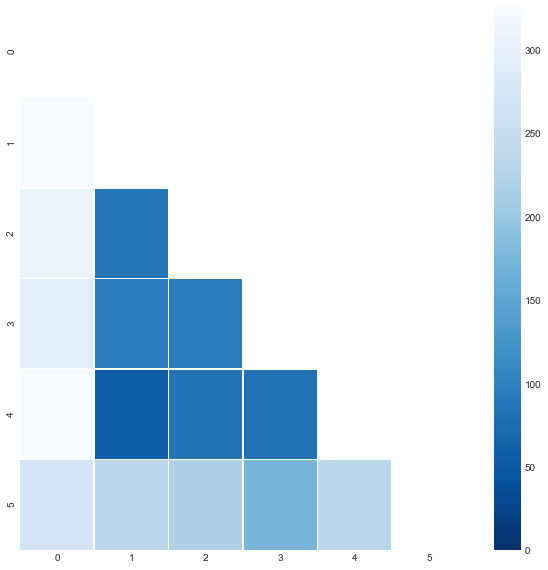


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3237 secs


+ ------------   99    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

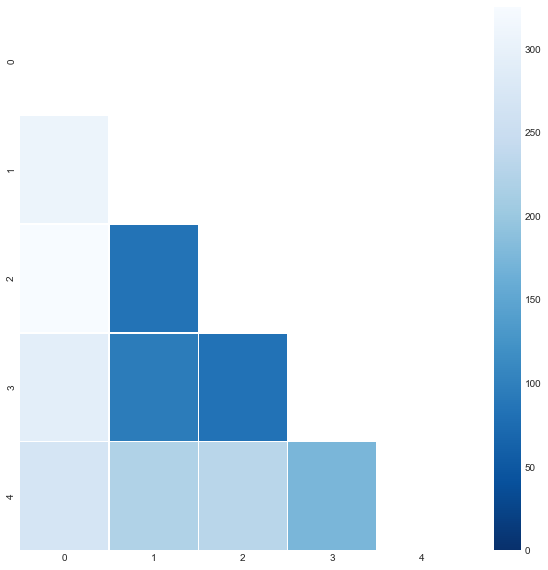


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.4143 secs


+ ------------   100    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


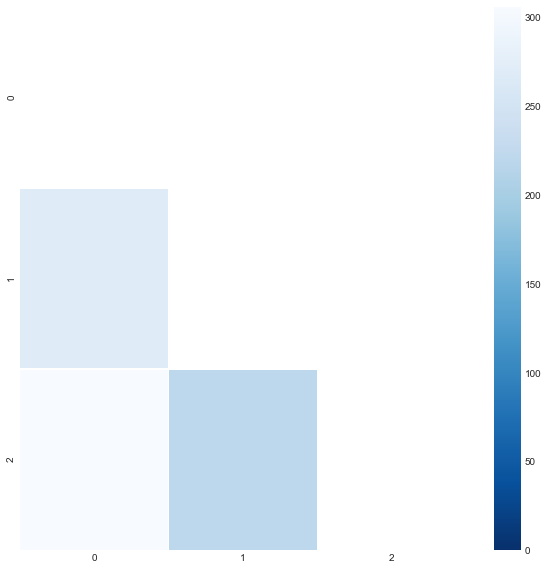


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.3375 secs





In [38]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']


ngramms= [3]  
jaccard_withchars = [False] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [39]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

max_numberOf_clusters max_editDistance prototypesFilterThr numOfPrototypes  \
61                   500               50                  10             157   
81                  1000               50                  10             157   
86                  1000              100                  10             147   
66                   500              100                  10             147   
67                   500              100                  20             136   
87                  1000              100                  20             136   
62                   500               50                  20             132   
82                  1000               50                  20             132   
88                  1000              100                  40             105   
68                   500              100                  40             105   
63                   500               50                  40              97   
83                  1000               50                  40              97   
46                   100              100                  10              78   
47                   100              100                  20              74   
48                   100              100                  40              64   
41                   100               50                  10              47   
42                   100               50                  20              42   
32                    50              200                  20              41   
91                  1000              200                  10              41   
71                   500              200                  10              41   

   protSelectionVariance  
61               108.366  
81               108.366  
86               103.393  
66               103.393  
67               105.506  
87               105.506  
62               110.963  
82               110.963  
88               105.766  
68               105.766  
63               114.566  
83               114.566  
46                121.17  
47               123.533  
48               118.316  
41                161.23  
42               162.773  
32               130.256  
91               130.256  
71               130.256

In [40]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

max_numberOf_clusters max_editDistance prototypesFilterThr  \
50                    100              100                 100   
70                    500              100                 100   
90                   1000              100                 100   
65                    500               50                 100   
45                    100               50                 100   
85                   1000               50                 100   
55                    100              200                 100   
95                   1000              200                 100   
35                     50              200                 100   
75                    500              200                 100   
44                    100               50                  70   
100                  1000              300                 100   
20                     10              300                 100   
40                     50              300                 100   
80                    500              300                 100   
60                    100              300                 100   
30                     50              100                 100   
94                   1000              200                  70   
54                    100              200                  70   
34                     50              200                  70   
74                    500              200                  70   
49                    100              100                  70   
19                     10              300                  70   
59                    100              300                  70   
39                     50              300                  70   
99                   1000              300                  70   
79                    500              300                  70   
42                    100               50                  20   
41                    100               50                  10   
38                     50              300                  40   
56                    100              300                  10   
96                   1000              300                  10   
18                     10              300                  40   
97                   1000              300                  20   
57                    100              300                  20   
36                     50              300                  10   
37                     50              300                  20   
58                    100              300                  40   
76                    500              300                  10   
77                    500              300                  20   
78                    500              300                  40   
16                     10              300                  10   
17                     10              300                  20   
98                   1000              300                  40   
64                    500               50                  70   
84                   1000               50                  70   
43                    100               50                  40   
29                     50              100                  70   
89                   1000              100                  70   
69                    500              100                  70   

    numOfPrototypes protSelectionVariance  
50                9               202.469  
70                9               202.469  
90                9               202.469  
65                8               201.344  
45                8               201.344  
85                8               201.344  
55                9               201.111  
95                9               201.111  
35                9               201.111  
75                9               201.111  
44               18               177.772  
100               3               176.667  
20                3               176.667  
40                3  

##### Jaccard

In [ ]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

### Performance details

#### Embeddings

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

#### Grid Search

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [ ]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)